# Business Problem

A empresa Top Bank atua na Europa tendo como principal produto uma conta bancária. Este produto pode manter o salário do cliente e efetuar pagamentos. Essa conta não tem nenhum custo nos primeiros 12 meses, porém, após esse período, o cliente precisa recontratar o banco para os próximos 12 meses e refazer esse processo todos os anos. Recentemente, a equipe de análise notou que a taxa de churn está aumentando.

## Challenge:
Como Cientista de Dados, você precisa criar um plano de ação para diminuir o número de clientes churn e mostrar o retorno financeiro da sua solução.
Além disso, você precisará fornecer um relatório relatando o desempenho de seu modelo e o impacto financeiro de sua solução.
Perguntas que o CEO e a equipe do Analytics gostariam de ver em seu relatório:

1. Qual é a atual taxa de churn do Top Bank?
2. Qual é o desempenho do modelo na classificação de clientes como churns?
3. Qual é o retorno esperado, em termos de receita, se a empresa utilizar seu modelo para evitar o churn de clientes?

## Note:
Como posso responder os 3 desafios do problema???

    R: Conhecer as variáveis (Data Description) e definir plano de desenvolvimento.

# Imports

In [1]:
#Data Processing
import pandas as pd
import numpy as np
from scipy import stats

#Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt

#Data Preparation
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from imblearn.over_sampling import SMOTE

#Feature Selection
from sklearn.model_selection import train_test_split
from boruta import BorutaPy

#Machine Learning, Metrics and Hyperparameter Optimization
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost.sklearn import XGBClassifier
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import KFold, cross_val_score
from skopt import dummy_minimize, gp_minimize
from skopt.plots import plot_convergence

#Parameter and Model Saving
import pickle

#Display Jupyter
from IPython.core.display import HTML
from IPython.core.display import Image
import warnings
warnings.filterwarnings('ignore')

## Helper Functions

In [2]:
binary_palette = []
sequencial_palette = ['#ffe14d', '#fac04b', '#f59f49', '#f08048', '#eb6246', '#e64545', '#e0435e', '#db4275', '#d6408b', '#d13fa0', '#cc3db4', '#c73cc7']
categorical_palette = ["#fbbd05", "#ff7a5c", "#ff4d4d", "#ff0000", "#c90000"]

def jupyter_settings():
    %matplotlib inline
    #%pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [16, 4]
    plt.rcParams['font.size'] = 24
    
    display(HTML('<style>.container { width:100% !important; }</style>'))
    pd.options.display.max_columns = 50
    pd.options.display.max_rows= False
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    sns.set_palette(categorical_palette)
    
    
def numeric_descriptive_statistical(numeric_attributes):
    mean = pd.DataFrame(numeric_attributes.apply(np.mean)).T
    median = pd.DataFrame(numeric_attributes.apply(np.median)).T
    standard_deviation = pd.DataFrame(numeric_attributes.apply(np.std)).T
    minimum = pd.DataFrame(numeric_attributes.apply(np.min)).T
    maximum = pd.DataFrame(numeric_attributes.apply(np.max)).T
    distance_between_minimum_and_maximum = pd.DataFrame(numeric_attributes.apply(lambda x: x.max() - x.min())).T
    unique = pd.DataFrame(numeric_attributes.apply(lambda x: len(x.unique()))).T
    skewness = pd.DataFrame(numeric_attributes.apply(lambda x: x.skew())).T
    kurtosis = pd.DataFrame(numeric_attributes.apply(lambda x: x.kurtosis())).T
    

    #concatenate
    vizualizer_descriptive_statistical = pd.concat([minimum, maximum, distance_between_minimum_and_maximum, unique, mean, median, standard_deviation, skewness, kurtosis]).T.reset_index()
    vizualizer_descriptive_statistical.columns = ['Variáveis', 'Mínimo', 'Máximo', 'Range', 'Valores Únicos', 'Média', 'Mediana', 'Desv. Padrão', 'Assimetria', 'Curtose']

    return vizualizer_descriptive_statistical


def n_bins(numeric_column):
    n = numeric_column.shape[0]
    k = round(1 + (3.3 * np.log10(n)))    
        
    return k


def plot_univariate_numeric_distributions(dataframe, list_numerical_variables):
    
    for variable in list_numerical_variables:
        
        numeric_column = dataframe[variable]
        
        bins = n_bins(numeric_column)
        
        # Get statistics
        min_val = numeric_column.min()
        max_val = numeric_column.max()
        mean_val = numeric_column.mean()
        med_val = numeric_column.median()
        mod_val = numeric_column.mode()[0]
        first_quartile_val= np.percentile(numeric_column, 25)
        third_quartile_val = np.percentile(numeric_column, 75)

        #print('Mínimo:{:.2f}\nMédia:{:.2f}\nMediana:{:.2f}\nModa:{:.2f}\nMáximo:{:.2f}\nPrimeiro Quartil:{:.2f}\nTerceiro Quartil:{:.2f}'.format(min_val, mean_val,
        #                                                                                                                                         med_val, mod_val, max_val,
        #                                                                                                                                         first_quartile_val,
        #                                                                                                                                         third_quartile_val))
        # programação assincrona p esse print

        # Create a figure for 2 subplots (2 rows, 1 column)
        fig, ax = plt.subplots(2, 1, figsize = (16,4))

        # Plot the histogram   
        ax[0].hist(numeric_column, bins= bins, color= 'salmon')
        ax[0].set_ylabel('frequência')

        # Add lines for the mean, median, and mode
        ax[0].axvline(x=min_val, color = 'gray', linestyle='dashed', linewidth = 2)
        ax[0].axvline(x=first_quartile_val, color = 'yellow', linestyle='dashed', linewidth = 2)
        ax[0].axvline(x=mean_val, color = 'cyan', linestyle='dashed', linewidth = 2)
        ax[0].axvline(x=med_val, color = 'red', linestyle='dashed', linewidth = 2)
        ax[0].axvline(x=mod_val, color = 'green', linestyle='dashed', linewidth = 2)
        ax[0].axvline(x=third_quartile_val, color = 'yellow', linestyle='dashed', linewidth = 2)
        ax[0].axvline(x=max_val, color = 'gray', linestyle='dashed', linewidth = 2)

        # Plot the boxplot   
        ax[1].boxplot(numeric_column, vert=False)
        ax[1].set_xlabel(variable)

        # Add a title to the Figure
        fig.suptitle(f'Frequência de {variable}')

        fig.show()
    
    return  None


def plot_bivariate_numeric_distribuitions(dataframe, list_variables, variable_response, tuple_figsize, order= None):
    
    shape_list = len(list_variables)
    
    for variable in list_variables:

        position_variable = list_variables.index(variable)
        
        plt.figure(figsize= tuple_figsize)
        
        plt.subplot(shape_list, 2, position_variable * 2 + 1)
        sns.boxplot(x= variable, y= variable_response, data= dataframe, orient= 'h', order=order);
        plt.title(f'{variable_response} x {variable}')

        plt.subplot(shape_list, 2, position_variable * 2 + 2)
        sns.distplot(dataframe[(dataframe[variable_response] == 0) | (dataframe[variable_response] == 'no')][variable], label= 'no');
        sns.distplot(dataframe[(dataframe[variable_response] == 1) | (dataframe[variable_response] == 'yes')][variable], label= 'yes');
        plt.legend(title= variable_response);
        plt.title(f'{variable_response} x {variable}')
    
    return None


def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    
    r, k = cm.shape
    
    chi2 = stats.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k - 1)*(r - 1)/(n - 1))
    
    kcorr = k - (k - 1)**2/(n - 1)
    rcorr = r - (r - 1)**2/(n - 1)

    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))

jupyter_settings()

## Load Data

In [3]:
data_raw = pd.read_csv('../data/churn.csv')
data_raw

RowNumber  CustomerId      Surname  CreditScore Geography  Gender  Age  Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  Exited
0             1    15634602     Hargrave          619    France  Female   42       2       0.00              1          1               1        101348.88       1
1             2    15647311         Hill          608     Spain  Female   41       1   83807.86              1          0               1        112542.58       0
2             3    15619304         Onio          502    France  Female   42       8  159660.80              3          1               0        113931.57       1
3             4    15701354         Boni          699    France  Female   39       1       0.00              2          0               0         93826.63       0
4             5    15737888     Mitchell          850     Spain  Female   43       2  125510.82              1          1               1         79084.10       0
5             6    15574012          Chu          645     Spain    Male   44       8  113755.78              2          1               0        149756.71       1
6             7    15592531     Bartlett          822    France    Male   50       7       0.00              2          1               1         10062.80       0
7             8    15656148       Obinna          376   Germany  Female   29       4  115046.74              4          1               0        119346.88       1
8             9    15792365           He          501    France    Male   44       4  142051.07              2          0               1         74940.50       0
...         ...         ...          ...          ...       ...     ...  ...     ...        ...            ...        ...             ...              ...     ...
9991       9992    15769959  Ajuluchukwu          597    France  Female   53       4   88381.21              1          1               0         69384.71       1
9992       9993    15657105  Chukwualuka          726     Spain    Male   36       2       0.00              1          1               0        195192.40       0
9993       9994    15569266       Rahman          644    France    Male   28       7  155060.41              1          1               0         29179.52       0
9994       9995    15719294         Wood          800    France  Female   29       2       0.00              2          0               0        167773.55       0
9995       9996    15606229     Obijiaku          771    France    Male   39       5       0.00              2          1               0         96270.64       0
9996       9997    15569892    Johnstone          516    France    Male   35      10   57369.61              1          1               1        101699.77       0
9997       9998    15584532          Liu          709    France  Female   36       7       0.00              1          0               1         42085.58       1
9998       9999    15682355    Sabbatini          772   Germany    Male   42       3   75075.31              2          1               0         92888.52       1
9999      10000    15628319       Walker          792    France  Female   28       4  130142.79              1          1               0         38190.78       0

[10000 rows x 14 columns]

# Data Description

In [4]:
df2 = data_raw.copy()

## Meaning of Data

- **RowNumber**: o número das colunas
- **CustomerID**: identificador único de clientes
- **Surname**: sobrenome do cliente
- **CreditScore**: pontuação de crédito do cliente para o mercado financeiro (quanto maior o score, é um bom pagador)
- **Geography**: o país do cliente
- **Gender**: o gênero do cliente
- **Age**: a idade do cliente
- **Tenure**: número de anos que o cliente está no banco
- **Balance**: o valor que o cliente tem em sua conta
- **NumOfProducts**: o número de produtos que o cliente possui (no caso, contas)
- **HasCrCard**: se o cliente tiver cartão de crédito
- **IsActiveMember**: se o cliente estiver ativo (nos últimos 12 meses)
- **EstimateSalary**: estimativa de salário anual dos clientes
- **Exited**: se o cliente for churn (*variável resposta*)

## Rename Columns

In [5]:
renamed_columns = ['numero_linha', 'id_cliente', 'sobrenome', 'score_credito', 'geografia', 'genero', 'idade', 'tempo_permanencia', 
                   'saldo', 'numero_de_contas', 'tem_cartao_credito', 'membro_ativo', 'salario_estimado', 'Churn']
df2.columns = renamed_columns

df2.head(1)

numero_linha  id_cliente sobrenome  score_credito geografia  genero  idade  tempo_permanencia  saldo  numero_de_contas  tem_cartao_credito  membro_ativo  salario_estimado  Churn
0             1    15634602  Hargrave            619    France  Female     42                  2    0.0                 1                   1             1         101348.88      1

## Data Dimensions

In [6]:
data_dimensions = df2.shape
print(f'A base de dados possui {data_dimensions[0]} clientes e {data_dimensions[1]} variáveis.')

A base de dados possui 10000 clientes e 14 variáveis.


## Data Types

In [7]:
df2.dtypes

numero_linha            int64
id_cliente              int64
sobrenome              object
score_credito           int64
geografia              object
genero                 object
idade                   int64
tempo_permanencia       int64
saldo                 float64
numero_de_contas        int64
tem_cartao_credito      int64
membro_ativo            int64
salario_estimado      float64
Churn                   int64
dtype: object

### Change Data Types

In [8]:
#Alterando o tipo de dados das colunas binárias: 'tem_cartao_credito', 'membro_ativo' e 'Churn'
categorical_columns = ['tem_cartao_credito', 'membro_ativo', 'Churn']

for columns in categorical_columns:
    df2[columns] = df2[columns].apply(lambda x: 'yes' if x == 1 else 'no')
    
df2.dtypes

numero_linha            int64
id_cliente              int64
sobrenome              object
score_credito           int64
geografia              object
genero                 object
idade                   int64
tempo_permanencia       int64
saldo                 float64
numero_de_contas        int64
tem_cartao_credito     object
membro_ativo           object
salario_estimado      float64
Churn                  object
dtype: object

## Check Duplicates

In [9]:
df2[df2.duplicated('id_cliente', False)]

Empty DataFrame
Columns: [numero_linha, id_cliente, sobrenome, score_credito, geografia, genero, idade, tempo_permanencia, saldo, numero_de_contas, tem_cartao_credito, membro_ativo, salario_estimado, Churn]
Index: []

- A base não possui dados duplicados.

## Check NaN and Null Values

In [10]:
#Dados NaN
df2.isna().sum()

numero_linha          0
id_cliente            0
sobrenome             0
score_credito         0
geografia             0
genero                0
idade                 0
tempo_permanencia     0
saldo                 0
numero_de_contas      0
tem_cartao_credito    0
membro_ativo          0
salario_estimado      0
Churn                 0
dtype: int64

In [11]:
#Dados Null
df2.isnull().sum()

numero_linha          0
id_cliente            0
sobrenome             0
score_credito         0
geografia             0
genero                0
idade                 0
tempo_permanencia     0
saldo                 0
numero_de_contas      0
tem_cartao_credito    0
membro_ativo          0
salario_estimado      0
Churn                 0
dtype: int64

- A base não possui dados faltantes.

## Check Zero Values

In [12]:
df2.dtypes

numero_linha            int64
id_cliente              int64
sobrenome              object
score_credito           int64
geografia              object
genero                 object
idade                   int64
tempo_permanencia       int64
saldo                 float64
numero_de_contas        int64
tem_cartao_credito     object
membro_ativo           object
salario_estimado      float64
Churn                  object
dtype: object

In [13]:
#Transfomando valores diferentes de 0 em "another value" em todas as variáveis numéricas
numerical_variables = df2.select_dtypes(include= ['int64', 'float64']).columns
numerical_variables_verify = df2[numerical_variables]

for column in numerical_variables_verify.columns:
    numerical_variables_verify[column] = numerical_variables_verify[column].apply(lambda x: '0' if x == 0 else 'another value')

In [14]:
numerical_variables_verify.apply(lambda x: x.unique())

numero_linha            [another value]
id_cliente              [another value]
score_credito           [another value]
idade                   [another value]
tempo_permanencia    [another value, 0]
saldo                [0, another value]
numero_de_contas        [another value]
salario_estimado        [another value]
dtype: object

- Apenas as variáveis 'tempo_permanencia' e 'saldo' possuem valores declarados como 0.

De fato, apenas as colunas 'score_credito' (dependendo da regra de negócio), 'tempo_permanencia' e 'saldo' fazem sentido terem valores iguais a 0, mas ainda cabe análise.

In [15]:
percentage_0_in_saldo = numerical_variables_verify['saldo'].value_counts()[1] / numerical_variables_verify.shape[0] * 100
percentage_0_in_tenure = numerical_variables_verify['tempo_permanencia'].value_counts()[1] / numerical_variables_verify.shape[0] * 100
print(f'A coluna \'saldo\' possui {percentage_0_in_saldo}% registros zerados')
print(f'A coluna \'tempo_permanencia\' possui {percentage_0_in_tenure:.2f}% registros zerados')

A coluna 'saldo' possui 36.17% registros zerados
A coluna 'tempo_permanencia' possui 4.13% registros zerados


### *saldo*

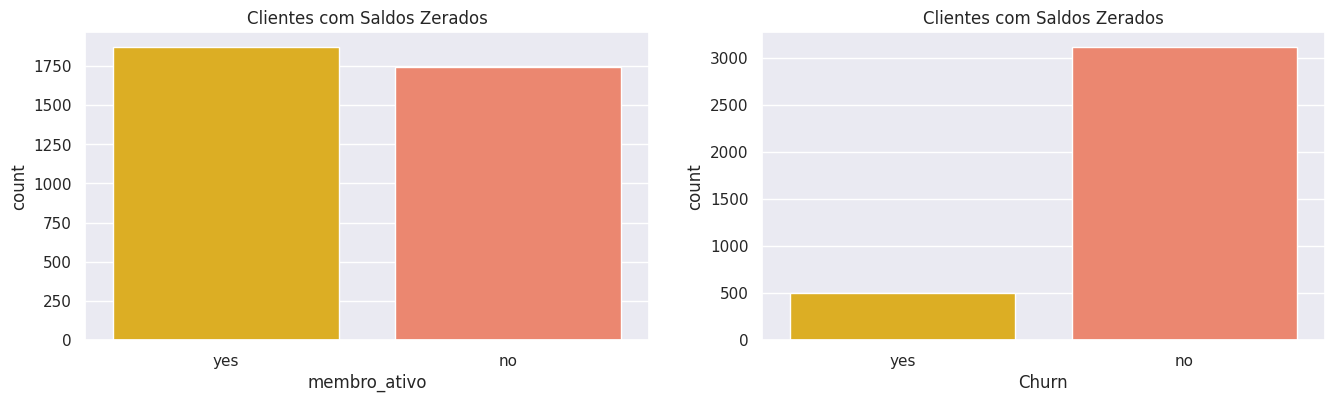

In [16]:
df_zero_balance = df2[['saldo', 'tempo_permanencia', 'membro_ativo', 'Churn']].loc[df2['saldo'] == 0]

plt.subplot(1, 2, 1)
sns.countplot(x= df_zero_balance['membro_ativo']);
plt.title("Clientes com Saldos Zerados");

plt.subplot(1, 2, 2)
sns.countplot(x= df_zero_balance['Churn']);
plt.title("Clientes com Saldos Zerados");

In [17]:
df_aux = df_zero_balance[['saldo', 'tempo_permanencia']].groupby('tempo_permanencia').count()
df_aux2 = df_zero_balance[['saldo', 'tempo_permanencia']].groupby('tempo_permanencia').count() / df_zero_balance.shape[0]

pd.concat([df_aux, df_aux2], axis= 1, keys= ['saldo_abs', 'saldo_perc'])

saldo_abs saldo_perc
                      saldo      saldo
tempo_permanencia                     
0                       137   0.037877
1                       349   0.096489
2                       382   0.105612
3                       352   0.097318
4                       369   0.102018
5                       374   0.103401
6                       367   0.101465
7                       386   0.106718
8                       363   0.100359
9                       360   0.099530
10                      178   0.049212

In [18]:
mean = round(df_zero_balance['tempo_permanencia'].mean(), 2)
print(f'A média do tempo de permanência para contas com saldo zerado é de {mean} anos')

A média do tempo de permanência para contas com saldo zerado é de 5.07 anos


### 'tempo_de_permanencia' zerados:

**Suposição principal**: Como o conjunto de dados não possui dados temporais e registros zerados representam um pequena parte dos dados, vamos assumir que valores zerados nessa variável representam clientes que ainda não possuem 1 ano de empresa.

### 'saldo' zerados:

    1. praticamente se divide igualmentente em membros ativos e não ativos;
    2. de 3617 saldos zerados, apenas 500 são de clientes que irão dar Churn
    3. a média do tempo de permanência para contas com saldo zerado é de 5 anos
    4. a menor frequência de saldos zerados, são para clientes que adquiriram o em menos de 1 ano.

Logo é possível determinar:

    - saldos zerados não siginificam que são de contas pré criadas (obs. 4)
    - saldos zerados não possuem relação clara com membros ativos e inativos.
    
**Suposição principal**: Ignorar os questionamentos levantados na V1. Saldos zerados, representam de fato, contas sem capital disponível.

## Note:
Observações importantes:

Como não existe variável temporal, identificando o momento da extração dos dados, nasce alguns questionamentos:

	1. Qual ponto no tempo a extração de dados foi feita? Qual é a relevância desse período?

	2. Se os dados foi extraído como o resumo de 1 ano, o valor de saldo representa o valor presente na conta(s) no momento da extração, o somátorio de saldo presente na(s) conta(s) durante 1 ano ou o valor máximo do saldo presente nesse período.

	3. A variável Churn significa que o cliente de fato saiu da empresa ou possui a vontade de sair. Pois se o cliente de fato saiu da empresa, existe clientes que saíram do banco, mas que ainda possuiam saldo em sua(s) conta(s).

	4. O que seria de fato 'membro_ativo', clientes que fizeram transações em todos os meses do ano, ou pelo menos uma vez durante o período de extração?

Pra esse projeto, irei modelar sem a resposta dessas questões, embora, ter o contexto melhora o entendimento do problema e possivelmente melhores resultados na modelagem dos dados.


Solução do problema de negócio:
    
1. Qual é a atual taxa de Churn do Top Bank?

        S: Análise Univariada da variável resposta 'Churn' > plotar gráfico de barras de churns e não-churns e printar porcentagem da relação das classes (concluído)

        
2. Qual é o desempenho do modelo na classificação de clientes como churns?

        S: Criar modelo de classificação com as variáveis selecionadas por relevância (Análise Bivariada) e pelo Boruta. (em progresso)
        
3. Qual é o retorno esperado, em termos de receita, se a empresa utilizar seu modelo para evitar o churn de clientes?

        S: Com o modelo criado, é possível estimar o retorno esperado, criando casos de deduções sobre os salários de cada cliente. (em progresso)

# Creation of New Variables

In [19]:
df3 = df2.copy()

In [20]:
#Escala FICO
df3['escala_fico'] = df3['score_credito'].apply(lambda x: 'too bad' if x < 580 else 'bad' if x < 670 else 'good' if x < 740 else 'very good' if x < 800 else 'excellent')


# Exploratory Data Analysis

In [21]:
df4 = df3.copy()

## Defining Variables for Analysis

In [22]:
#Response Variable
response_variable = df4['Churn']

#Numeric Variables
numeric_attributes = df4.select_dtypes(include= ['int64', 'float64'])

#Categorical Variables
categorical_attributes = df4.select_dtypes(exclude= ['int64', 'float64'])

## Univariate Analysis

### Response Variable

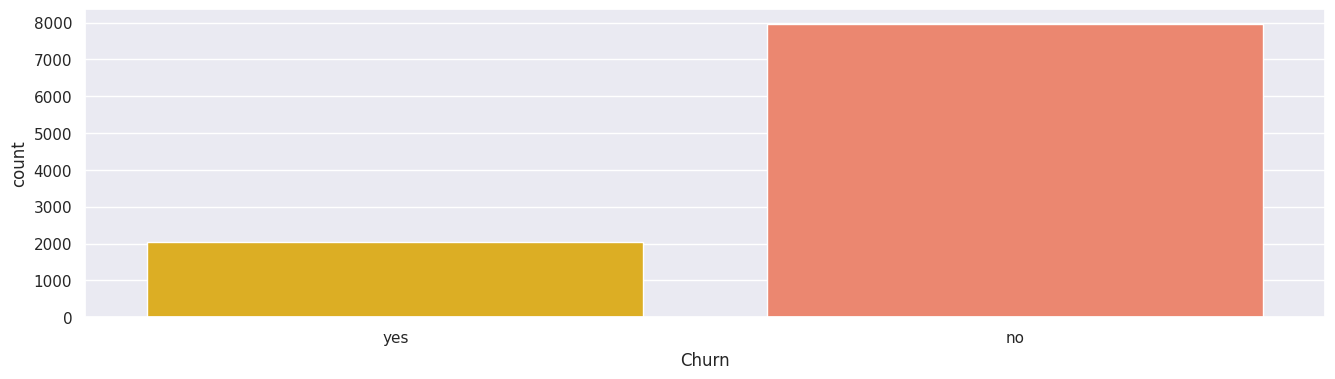

In [23]:
sns.countplot(x= response_variable);

In [24]:
percentage_no_churn = df4[['id_cliente', 'Churn']].loc[df4['Churn'] == 'no'].shape[0] / df4.shape[0] * 100
percentage_yes_churn = df4[['id_cliente', 'Churn']].loc[df4['Churn'] == 'yes'].shape[0] / df4.shape[0] * 100
print(f'Clientes que irão dar Churn correspondem a {percentage_yes_churn:.2f}%  da base de dados e clientes que não irão dar Churn correspondem a {percentage_no_churn:.2f}% da base de dados.')

Clientes que irão dar Churn correspondem a 20.37%  da base de dados e clientes que não irão dar Churn correspondem a 79.63% da base de dados.


- É evidente que a variável resposta possui classes desbalanceadas

### Numeric Variables

In [25]:
numeric_attributes.drop(columns= ['numero_linha', 'id_cliente'], inplace= True)
numeric_descriptive_statistical(numeric_attributes)

Variáveis  Mínimo     Máximo      Range  Valores Únicos          Média     Mediana  Desv. Padrão  Assimetria   Curtose
0      score_credito  350.00     850.00     500.00           460.0     650.528800     652.000     96.648466   -0.071607 -0.425726
1              idade   18.00      92.00      74.00            70.0      38.921800      37.000     10.487282    1.011320  1.395347
2  tempo_permanencia    0.00      10.00      10.00            11.0       5.012800       5.000      2.892030    0.010991 -1.165225
3              saldo    0.00  250898.09  250898.09          6382.0   76485.889288   97198.540  62394.285254   -0.141109 -1.489412
4   numero_de_contas    1.00       4.00       3.00             4.0       1.530200       1.000      0.581625    0.745568  0.582981
5   salario_estimado   11.58  199992.48  199980.90          9999.0  100090.239881  100193.915  57507.617221    0.002085 -1.181518

- **Muitos valores distintos**: *score_credito, idade, saldo, salário estimado.
- **Poucos valores distintos**: *tempo_permanencia, numero_de_contas*;

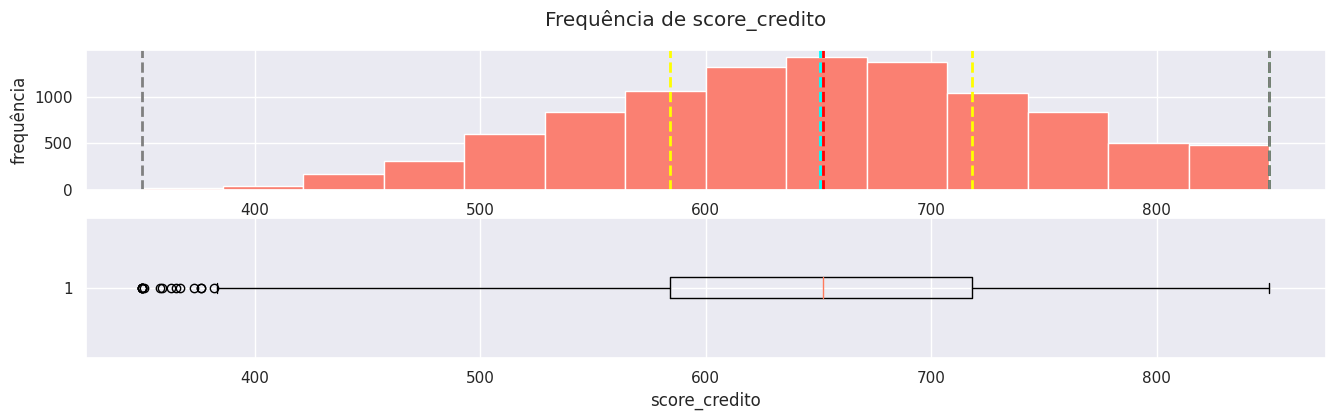

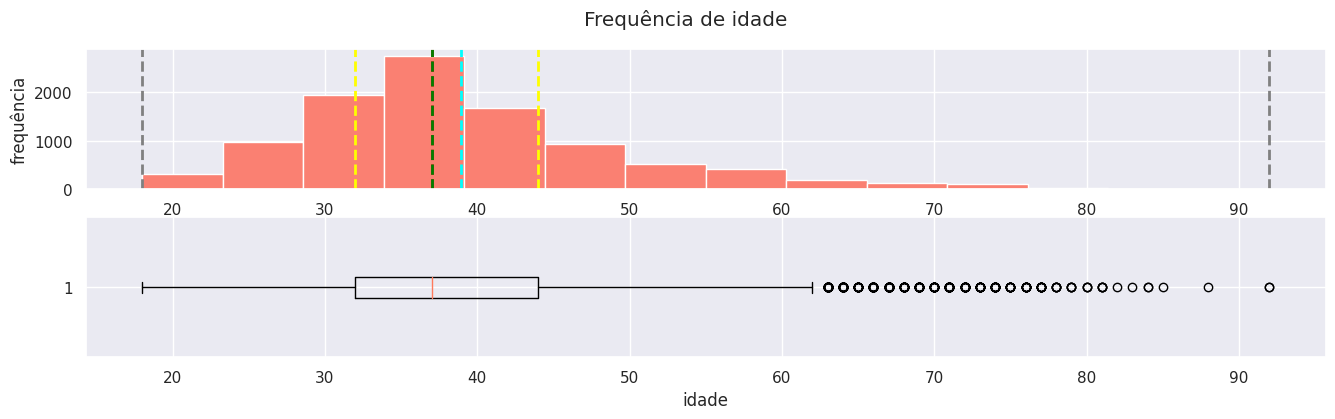

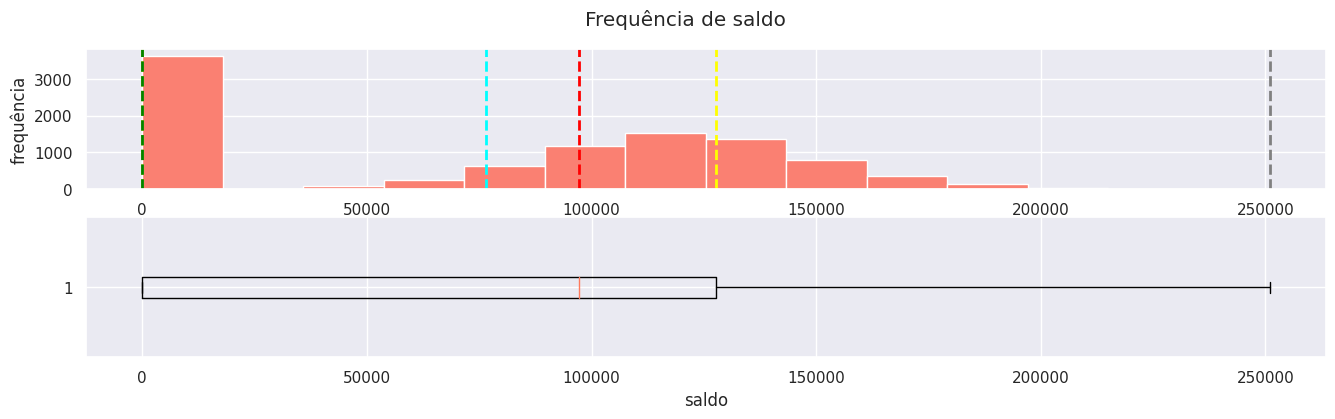

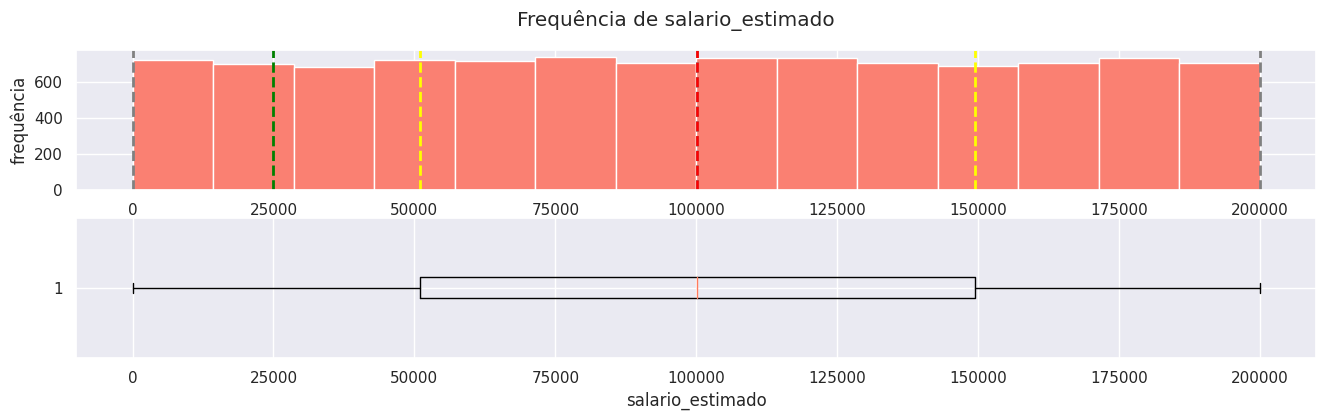

In [26]:
list_numerical_variables = ['score_credito', 'idade', 'saldo', 'salario_estimado']
plot_univariate_numeric_distributions(numeric_attributes, list_numerical_variables= list_numerical_variables)

#### Notes:

In [27]:
# Score de Crédito

# Note: 
	# segundo os intervalos de scores de crédito da FICO:
    	# 300 - 580: muito baixo;
        # 580 - 670: baixo;
        # 670 - 740: bom;
        # 740 - 800: muito bom;
        # 800 - 850: excelente;
        
    # é possível observar outliers para scores que se aproximam do valor mínimo (350) através do boxplot, mas com a curtose em -0.42 indicando que a distribuição tem uma pequena chance de ocorrência de
#outliers, logo o banco possui pouquíssimos clientes se aproximando do mínimo score_permitido pelo banco (aproximadamente uns 10).
    # a moda é igual ao valor máximo, o que pode evidênciar que o banco possui um grupo seleto de cliente que são bons pagadores. (vale criação de caso para esse grupo)
    # com assimetria em -0.07 evidencia que a distribuição de score está um pouco assimétrica à esquerda, logo existe uma maior concentração de valores na zona de valores mais elevados da amostra.
    # hipótese: 'clientes que são bons pagadores, possuem o salário mais alto?' ou 'clentes que possuem salários altos, são bons pagadores?'

In [28]:
# Idade

# Note
    # com a curtose positiva em 1.39 indica uma grande chance de existir outliers, evidenciado pelo boxplot que existe outlier para idade maiores de 62 anos. 
    # a mediana = moda > média, junto com a assimetria  em 1.011, evidencia que a distribuição de idade é assimétrica à direita, possuindo maior concentração de dados na zona de valores mais reduzidos da amostra. 

In [29]:
# Saldo

# Note
	# com a curtose negativa, evidencia que existe uma pequena possibilidade de haver outliers. já o boxplot afirma que não existe outliers nesse conjunto.
    # com assimetria em -0.14, evidencia que a distribuição de score está um pouco assimétrica à esquerda, logo existe uma maior concentração de valores na zona de valores mais elevados da amostra,
#por mais que exista uma alta concentração de dados com valores 0, mostrado no gráfico e abordado na checagem de valores zerados.
	# mais de 36% dos clientes possuem contas zeradas.

In [30]:
# Salário Estimado

# Note:
	# a distribuição dos salários é praticamente simétrica (evidenciado pelo valor da assimetria e pelos gráficos acima).
    # a distribuição dos salários também possui pouca chance de possuir valores dispersos, outliers (evidenciado pelo valor negativo da curtose e pelos gráficos acima).

#### *tempo_permanencia*

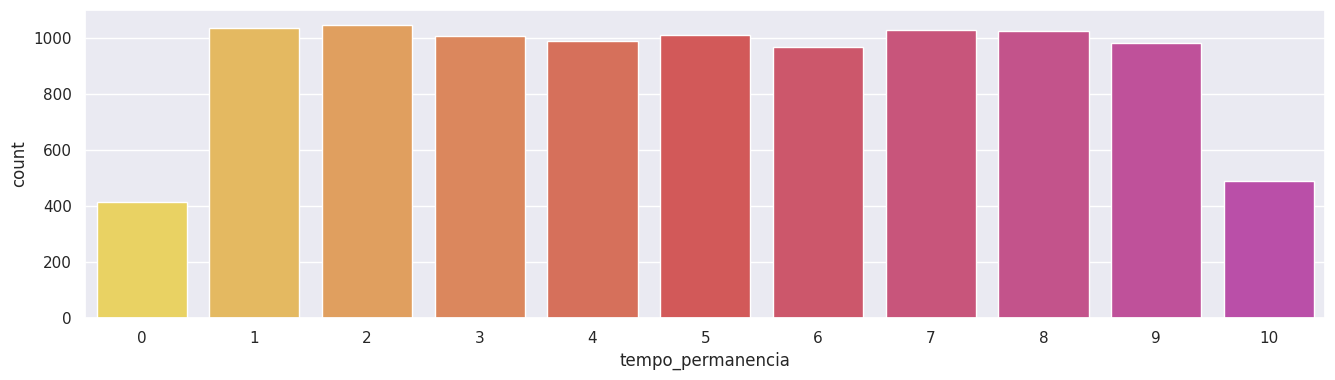

In [31]:
sns.countplot(x= df4['tempo_permanencia'], palette= sequencial_palette);

In [32]:
pd.DataFrame({'absoluto': df4['tempo_permanencia'].value_counts(), 'percentual (%)': df4['tempo_permanencia'].value_counts(normalize= True) * 100})

absoluto  percentual (%)
2       1048           10.48
1       1035           10.35
7       1028           10.28
8       1025           10.25
5       1012           10.12
3       1009           10.09
4        989            9.89
9        984            9.84
6        967            9.67
10       490            4.90
0        413            4.13

#### *numero_de_contas*

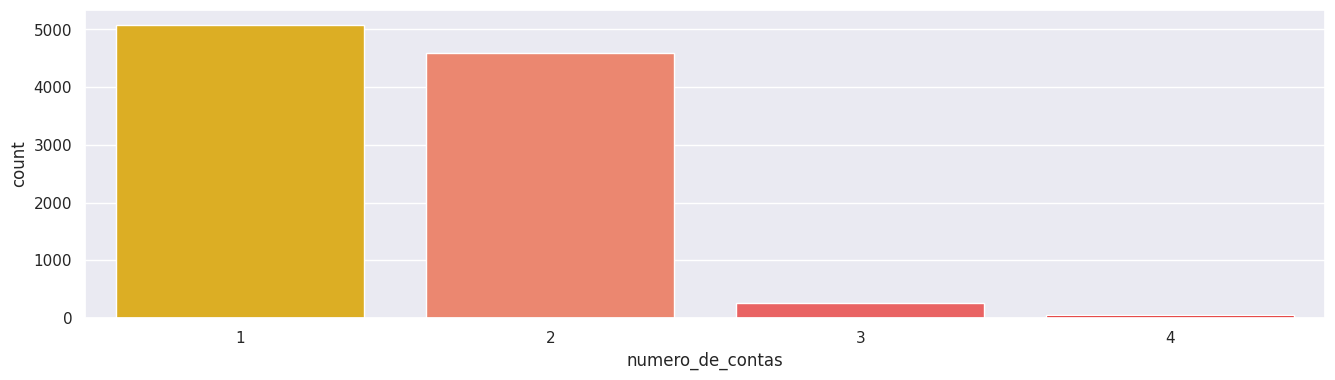

In [33]:
sns.countplot(x= df4['numero_de_contas']);

In [34]:
pd.DataFrame({'absoluto': df4['numero_de_contas'].value_counts(), 'percentual (%)': df4['numero_de_contas'].value_counts(normalize= True) * 100})

absoluto  percentual (%)
1      5084           50.84
2      4590           45.90
3       266            2.66
4        60            0.60

### Categorical Variables

#### *geografia*

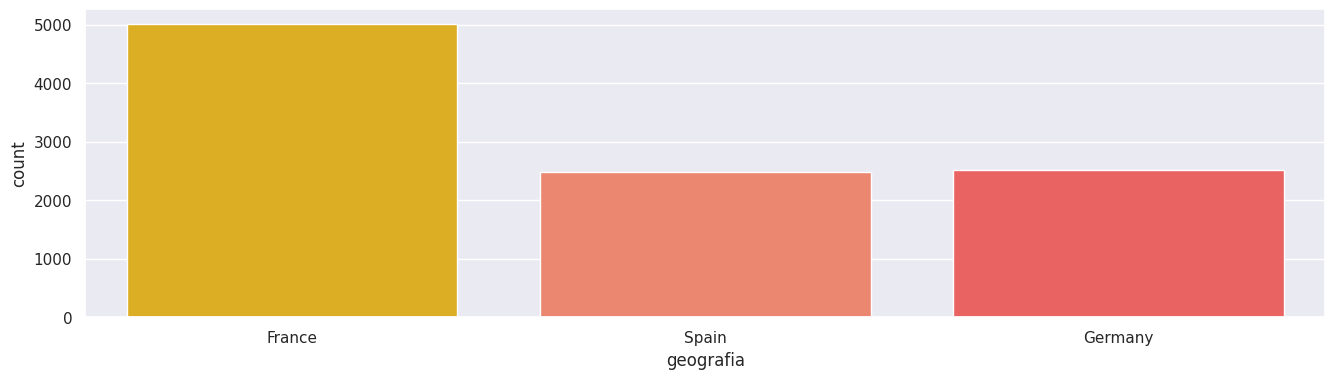

In [35]:
sns.countplot(x= df4['geografia'], palette= categorical_palette);

In [36]:
pd.DataFrame({'absoluto': df4['geografia'].value_counts(), 'percentual (%)': df4['geografia'].value_counts(normalize= True) * 100})

absoluto  percentual (%)
France       5014           50.14
Germany      2509           25.09
Spain        2477           24.77

#### *genero*

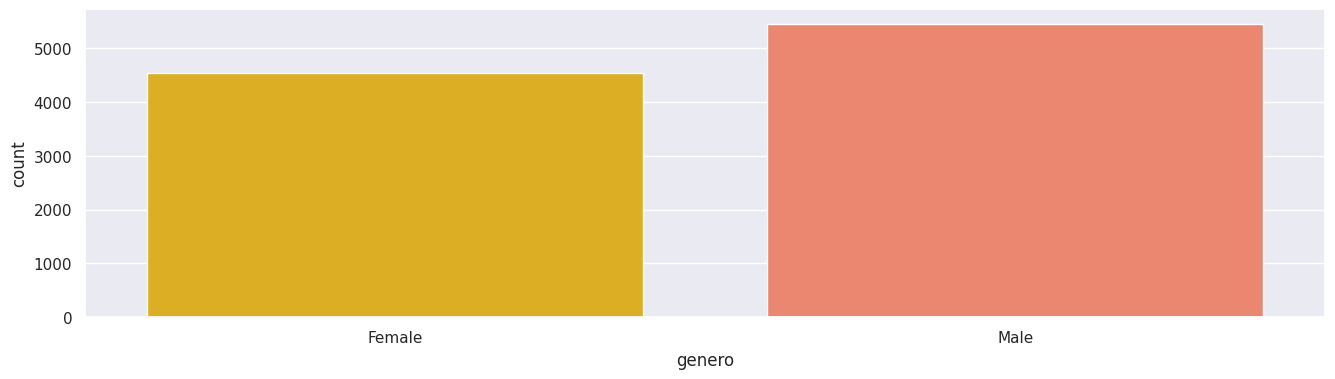

In [37]:
sns.countplot(x= df4['genero'], palette= categorical_palette);

In [38]:
pd.DataFrame({'absoluto': df4['genero'].value_counts(), 'percentual (%)': df4['genero'].value_counts(normalize= True) * 100})

absoluto  percentual (%)
Male        5457           54.57
Female      4543           45.43

#### *tem_cartao_credito*

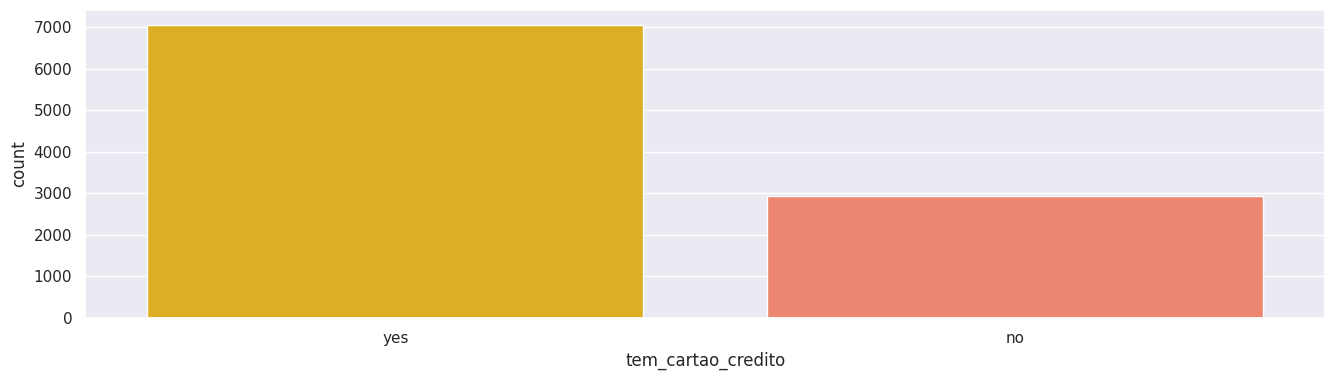

In [39]:
sns.countplot(x= df4['tem_cartao_credito'], palette= categorical_palette);

In [40]:
pd.DataFrame({'absoluto': df4['tem_cartao_credito'].value_counts(), 'percentual (%)': df4['tem_cartao_credito'].value_counts(normalize= True) * 100})

absoluto  percentual (%)
yes      7055           70.55
no       2945           29.45

#### *membro_ativo*

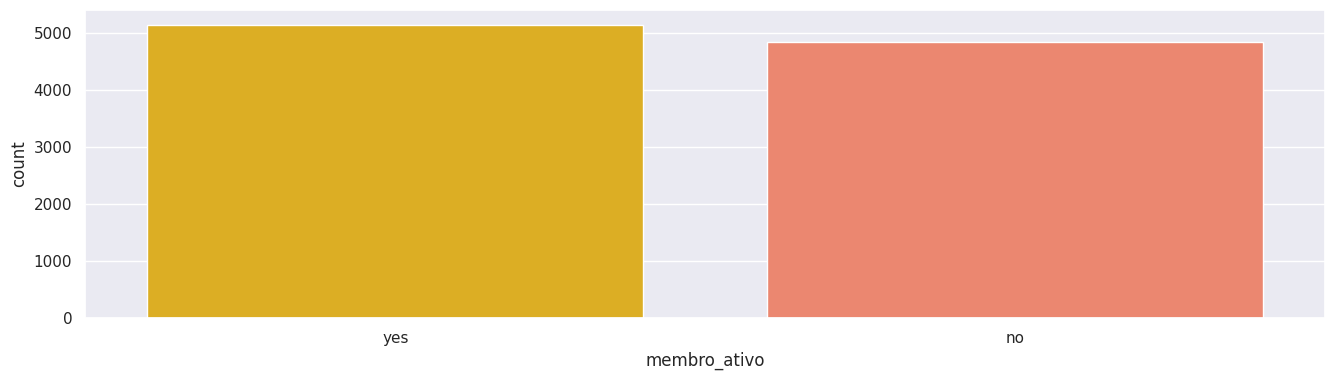

In [41]:
sns.countplot(x= df4['membro_ativo'], palette= categorical_palette);

In [42]:
pd.DataFrame({'absoluto': df4['membro_ativo'].value_counts(), 'percentual (%)': df4['membro_ativo'].value_counts(normalize= True) * 100})

absoluto  percentual (%)
yes      5151           51.51
no       4849           48.49

#### *escala_fico*

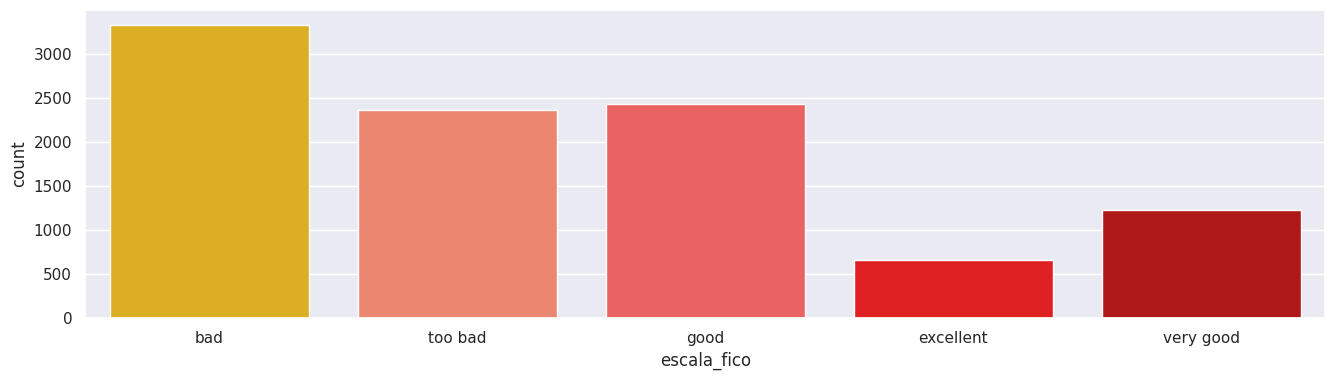

In [43]:
sns.countplot(x= df4['escala_fico'], palette= categorical_palette);

In [44]:
pd.DataFrame({'absoluto': df4['escala_fico'].value_counts(), 'percentual (%)': df4['escala_fico'].value_counts(normalize= True) * 100})

absoluto  percentual (%)
bad            3331           33.31
good           2428           24.28
too bad        2362           23.62
very good      1224           12.24
excellent       655            6.55

## Bivariate and Multivariate Analysis

### Response Variable x Numeric Variables (lots and few distinct values)

#### *score_credito, idade, saldo, salario_estimado*

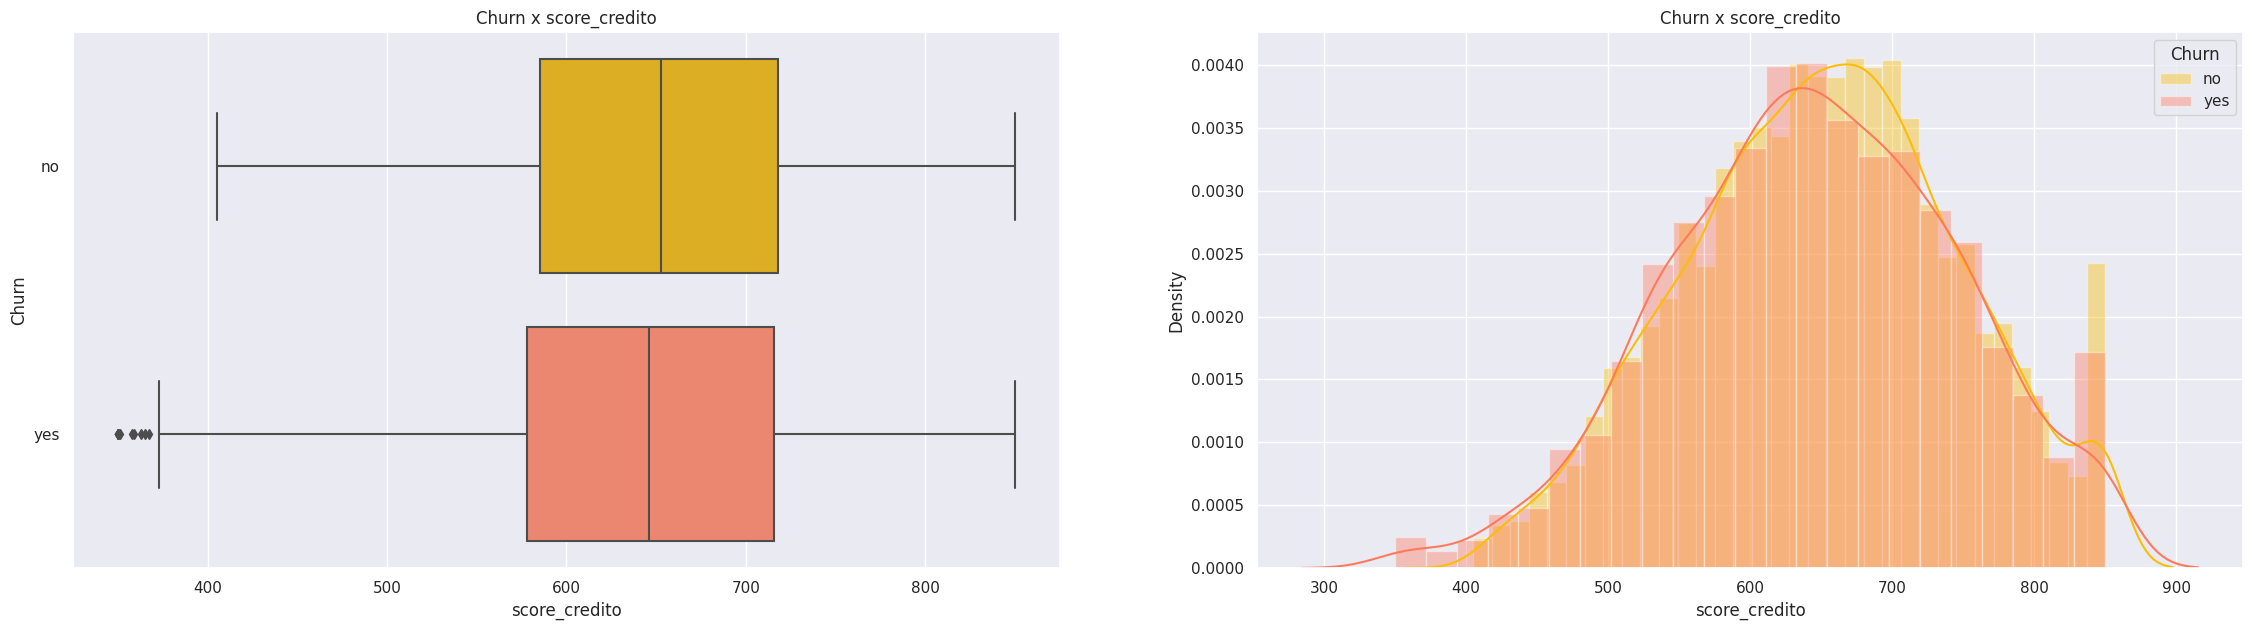

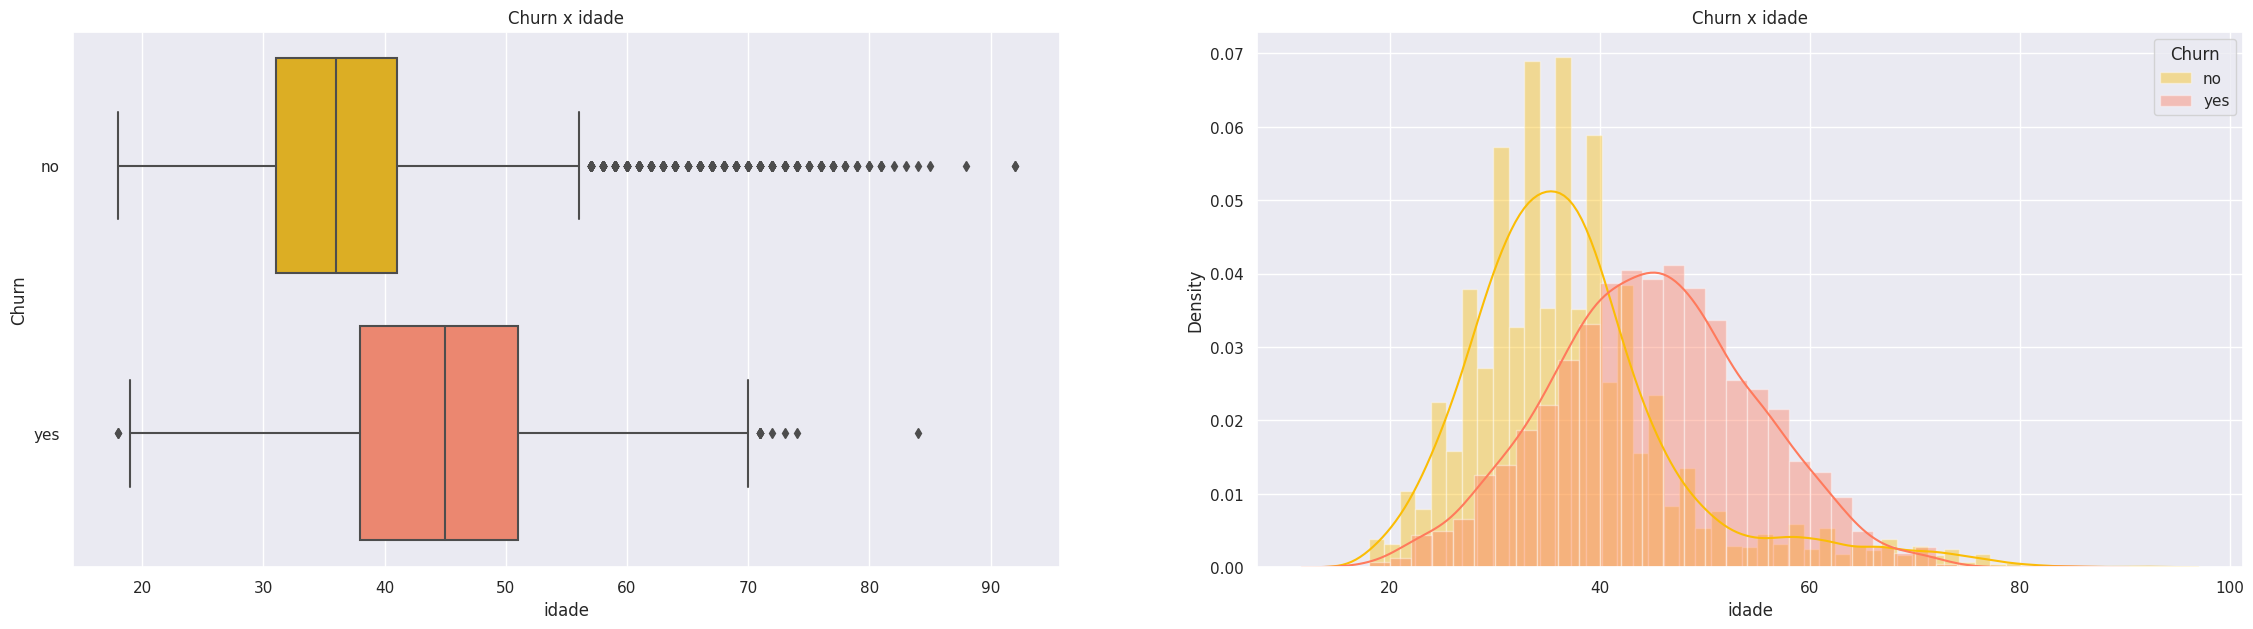

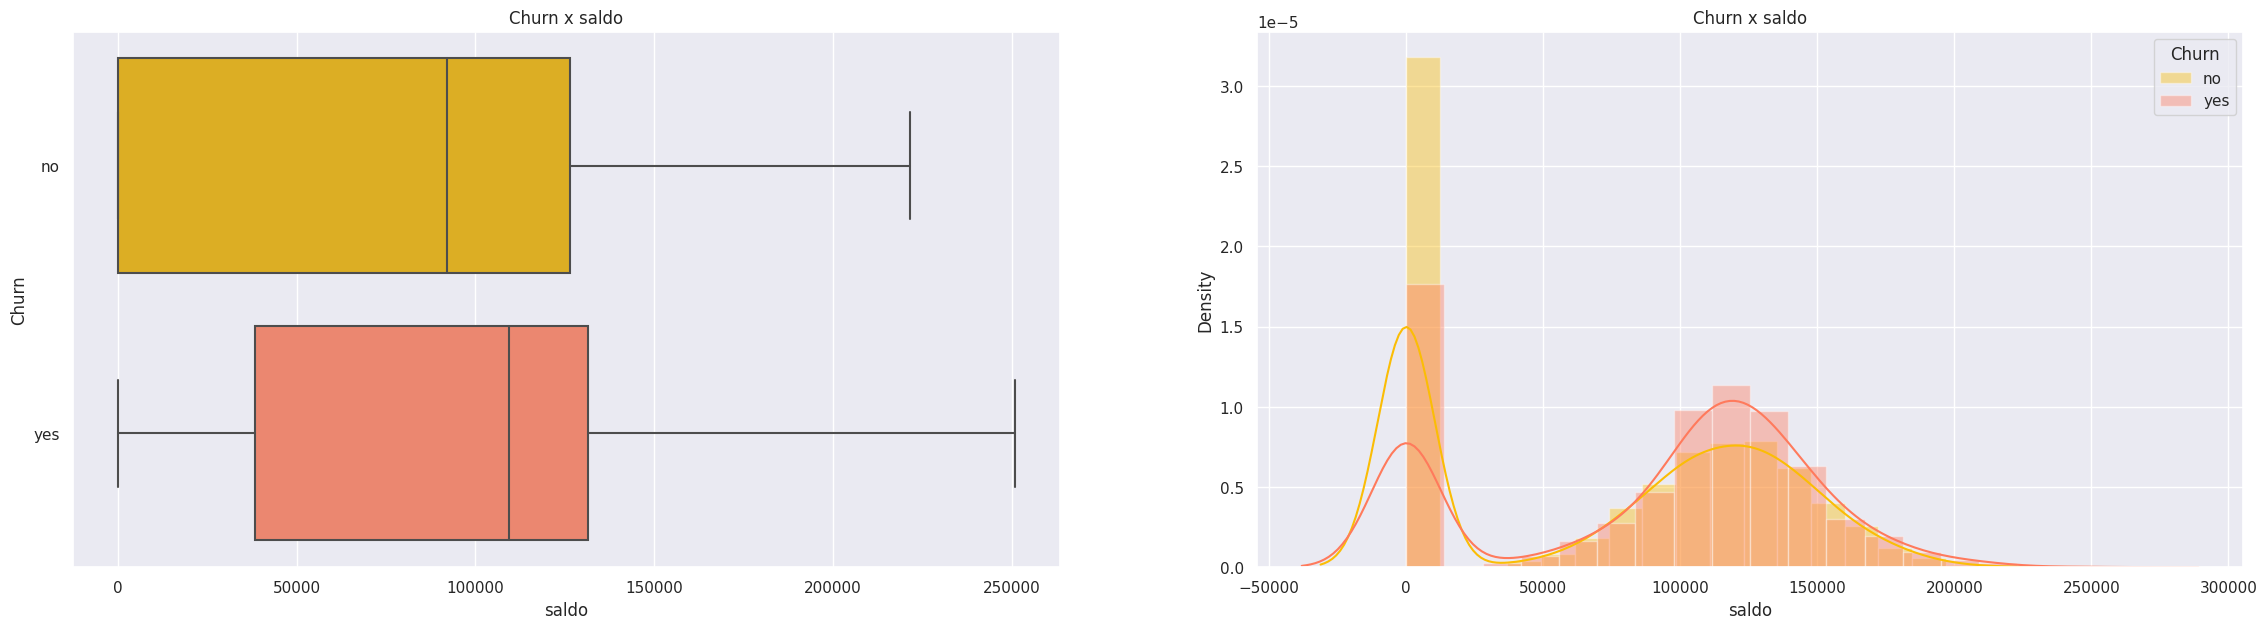

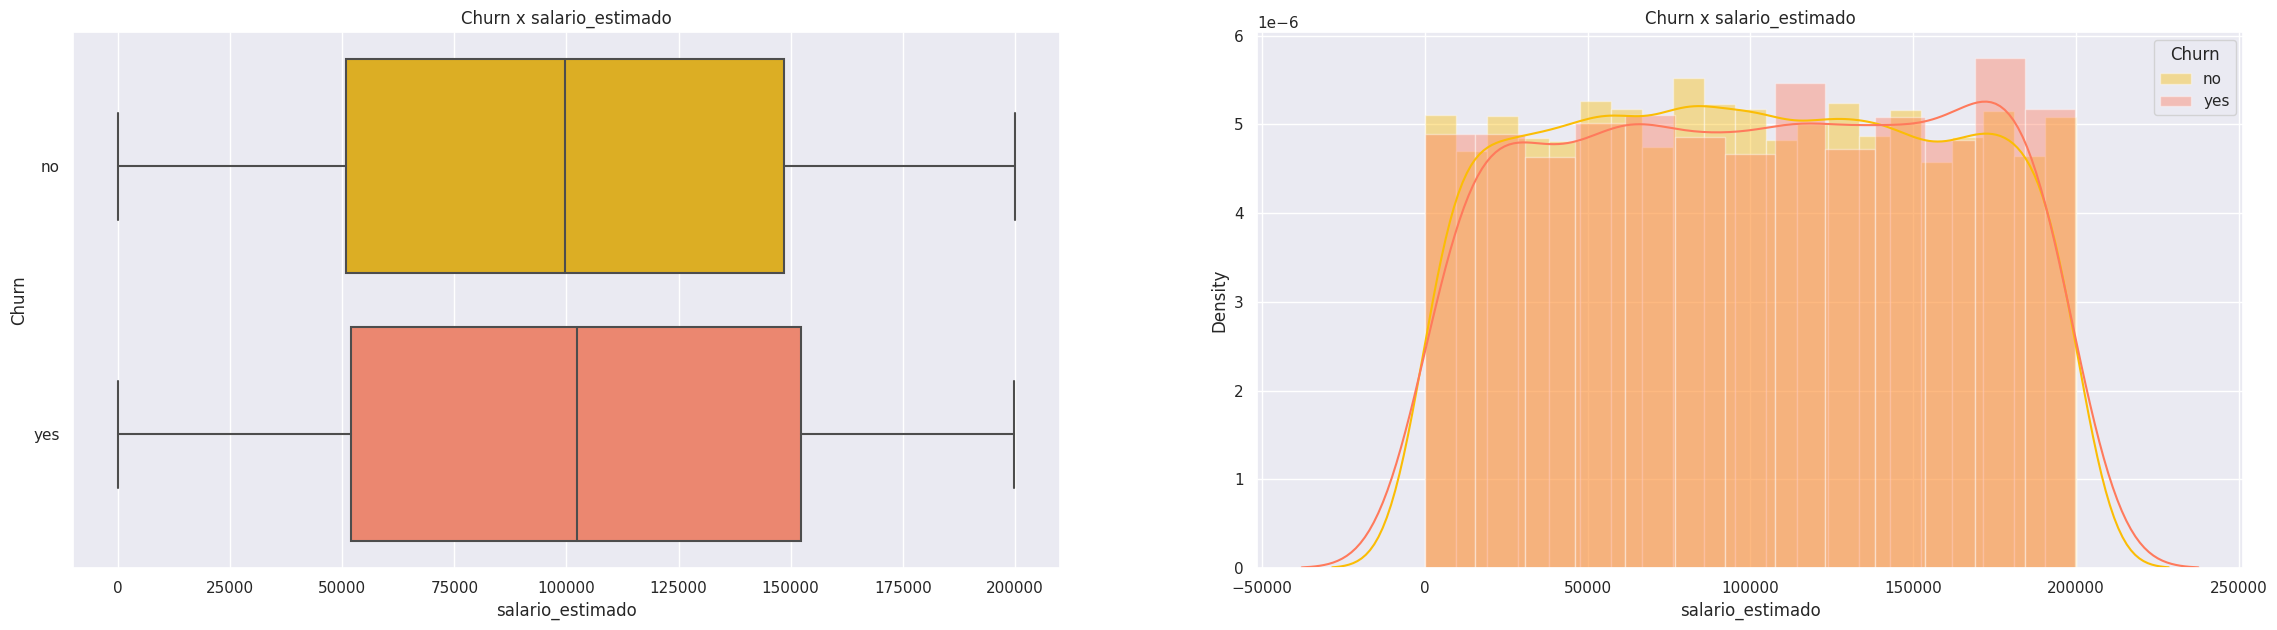

In [45]:
list_variables = ['score_credito', 'idade', 'saldo', 'salario_estimado']
order = ['no', 'yes']
tuple_figsize = (28, 32)
                         
plot_bivariate_numeric_distribuitions(df4, list_variables, 'Churn', tuple_figsize, order= order)

#### *tempo_permanencia*

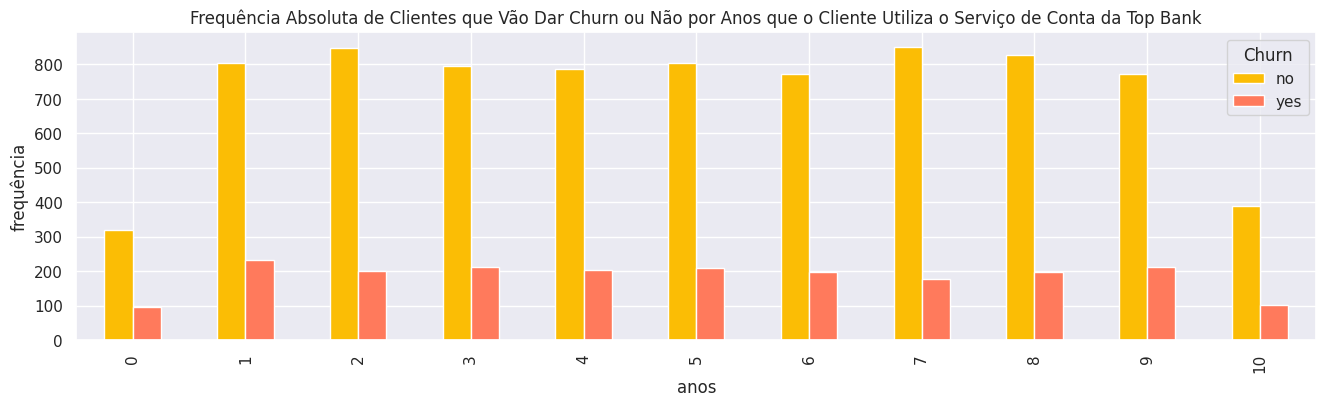

In [46]:
df_aux = df4[['id_cliente','Churn', 'tempo_permanencia']].groupby(['Churn','tempo_permanencia']).count()
df_aux.reset_index().pivot(index='tempo_permanencia', columns='Churn', values='id_cliente').plot(kind='bar')

# Adiciona títulos e etiquetas
plt.title('Frequência Absoluta de Clientes que Vão Dar Churn ou Não por Anos que o Cliente Utiliza o Serviço de Conta da Top Bank')
plt.xlabel('anos')
plt.ylabel('frequência')
plt.legend(title= 'Churn');

# Exibe o gráfico
plt.show()

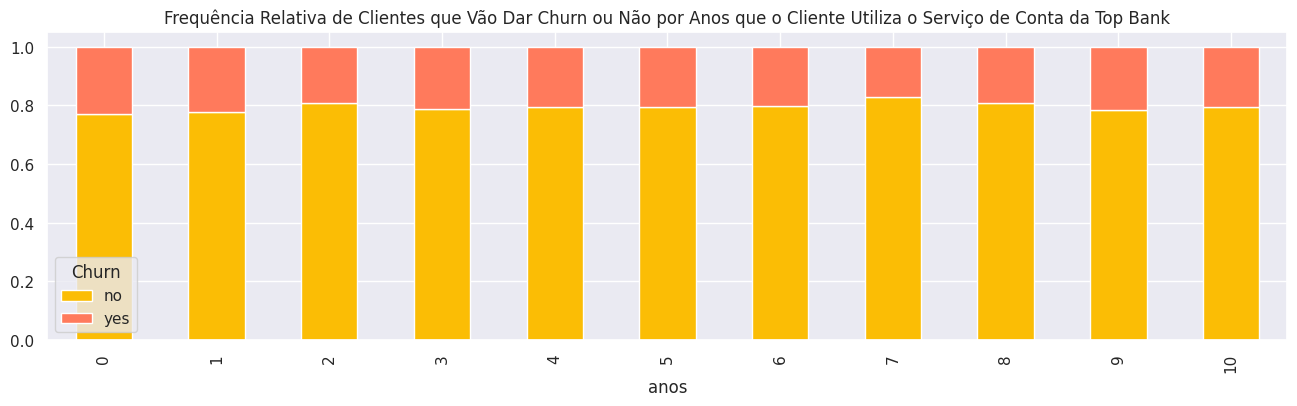

In [47]:
table = pd.crosstab(df4['tempo_permanencia'], df4['Churn'], normalize='index')
table = table.div(table.sum(1), axis=0)
table.plot(kind='bar', stacked=True)

# Adiciona títulos e etiquetas
plt.title('Frequência Relativa de Clientes que Vão Dar Churn ou Não por Anos que o Cliente Utiliza o Serviço de Conta da Top Bank')
plt.xlabel('anos')

# Exibe o gráfico
plt.show()

#### numero_de_contas

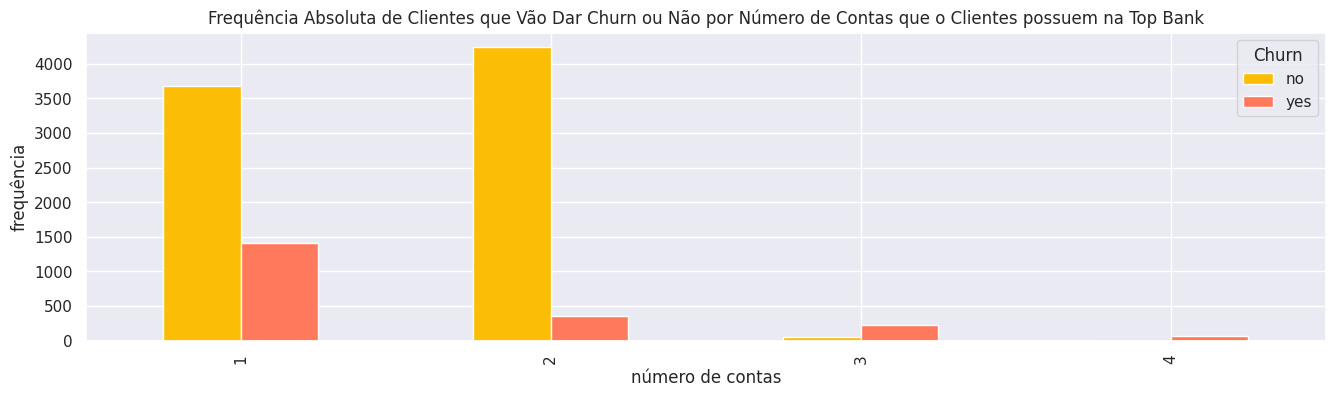

In [48]:
df_aux = df4[['id_cliente','Churn', 'numero_de_contas']].groupby(['Churn','numero_de_contas']).count()
df_aux.reset_index().pivot(index='numero_de_contas', columns='Churn', values='id_cliente').plot(kind='bar')

# Adiciona títulos e etiquetas
plt.title('Frequência Absoluta de Clientes que Vão Dar Churn ou Não por Número de Contas que o Clientes possuem na Top Bank')
plt.xlabel('número de contas')
plt.ylabel('frequência')
plt.legend(title= 'Churn');

# Exibe o gráfico
plt.show()

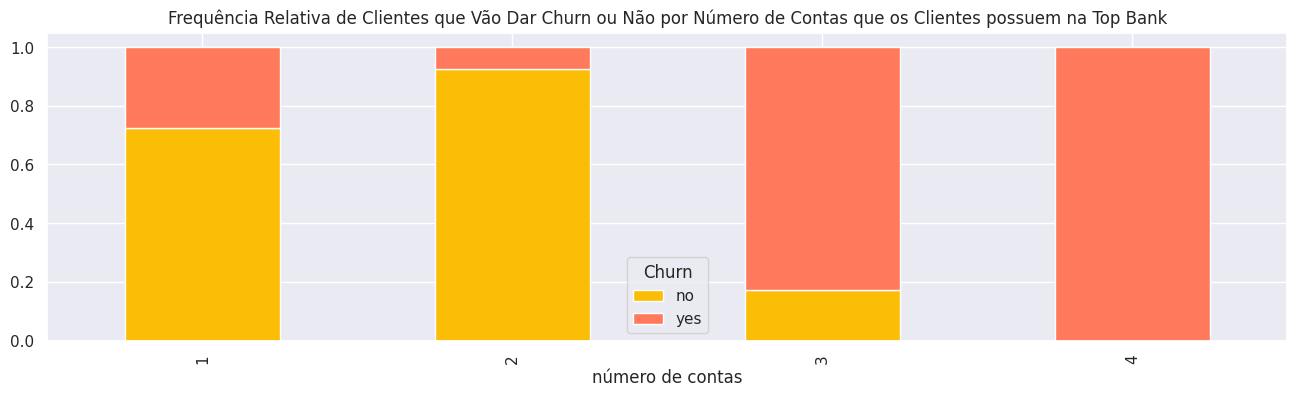

In [49]:
table = pd.crosstab(df4['numero_de_contas'], df4['Churn'], normalize='index')
table = table.div(table.sum(1), axis=0)
table.plot(kind='bar', stacked=True)

# Adiciona títulos e etiquetas
plt.title('Frequência Relativa de Clientes que Vão Dar Churn ou Não por Número de Contas que os Clientes possuem na Top Bank')
plt.xlabel('número de contas')

# Exibe o gráfico
plt.show()

### Response Variable x Categorical Variables

#### *geografia*

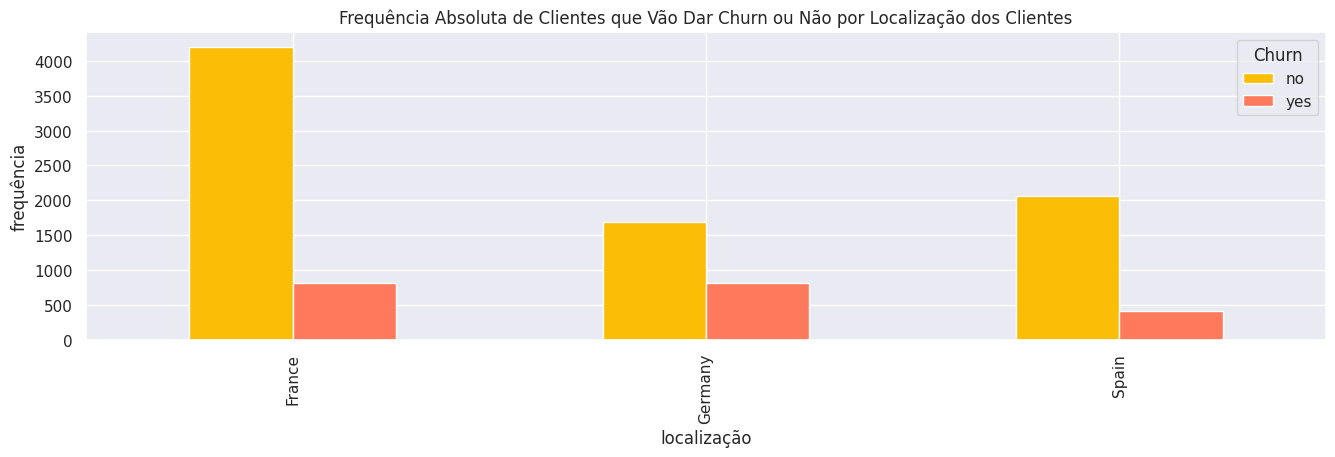

In [50]:
df_aux = df4[['id_cliente','Churn', 'geografia']].groupby(['Churn','geografia']).count()
df_aux.reset_index().pivot(index='geografia', columns='Churn', values='id_cliente').plot(kind='bar')

# Adiciona títulos e etiquetas
plt.title('Frequência Absoluta de Clientes que Vão Dar Churn ou Não por Localização dos Clientes')
plt.xlabel('localização')
plt.ylabel('frequência')
plt.legend(title= 'Churn');

# Exibe o gráfico
plt.show()

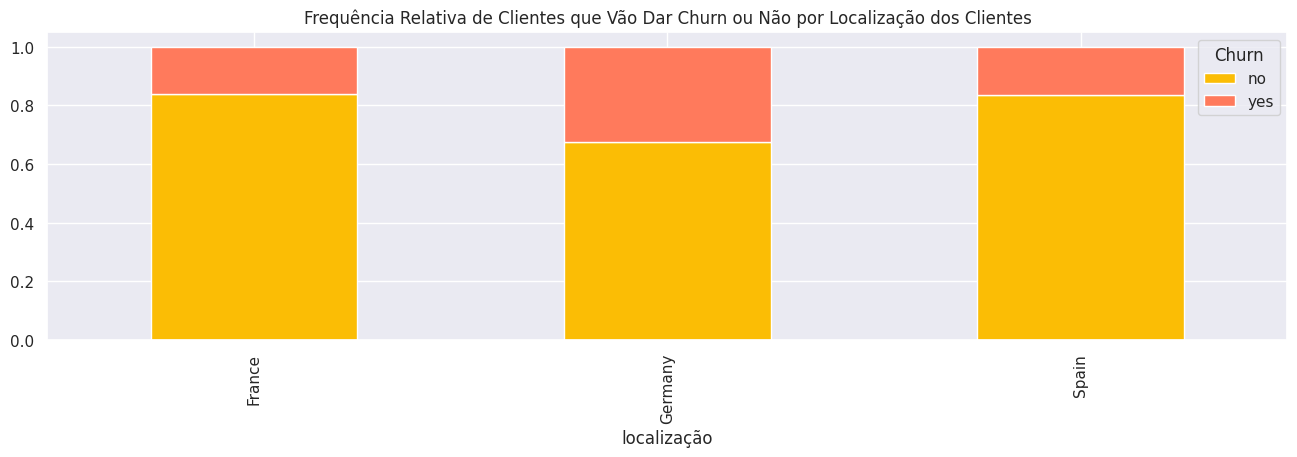

In [51]:
table = pd.crosstab(df4['geografia'], df4['Churn'], normalize='index')
table = table.div(table.sum(1), axis=0)
table.plot(kind='bar', stacked=True)

# Adiciona títulos e etiquetas
plt.title('Frequência Relativa de Clientes que Vão Dar Churn ou Não por Localização dos Clientes')
plt.xlabel('localização')

# Exibe o gráfico
plt.show()

#### *genero*

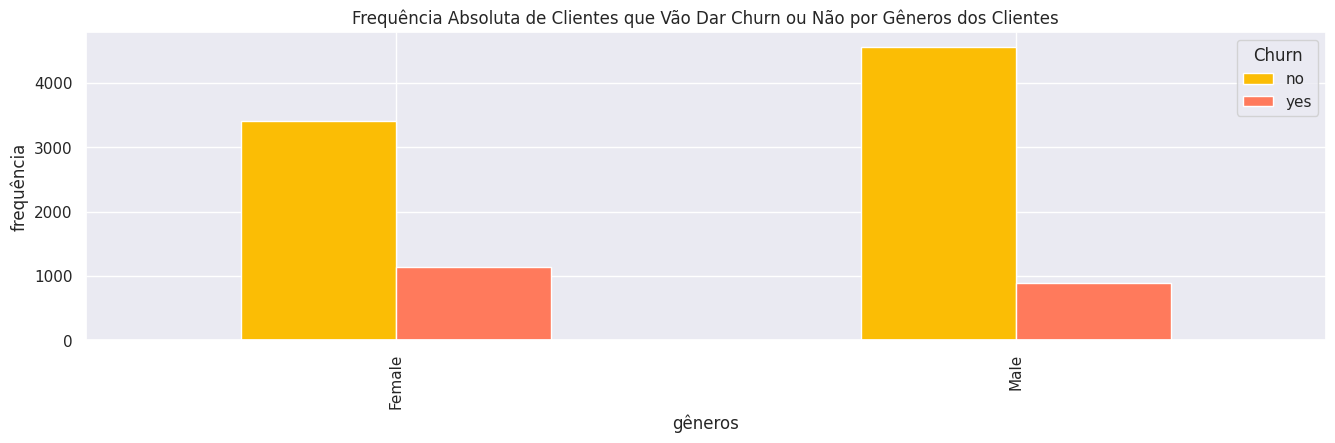

In [52]:
df_aux = df4[['id_cliente','Churn', 'genero']].groupby(['Churn','genero']).count()
df_aux.reset_index().pivot(index='genero', columns='Churn', values='id_cliente').plot(kind='bar')

# Adiciona títulos e etiquetas
plt.title('Frequência Absoluta de Clientes que Vão Dar Churn ou Não por Gêneros dos Clientes')
plt.xlabel('gêneros')
plt.ylabel('frequência')
plt.legend(title= 'Churn');

# Exibe o gráfico
plt.show()

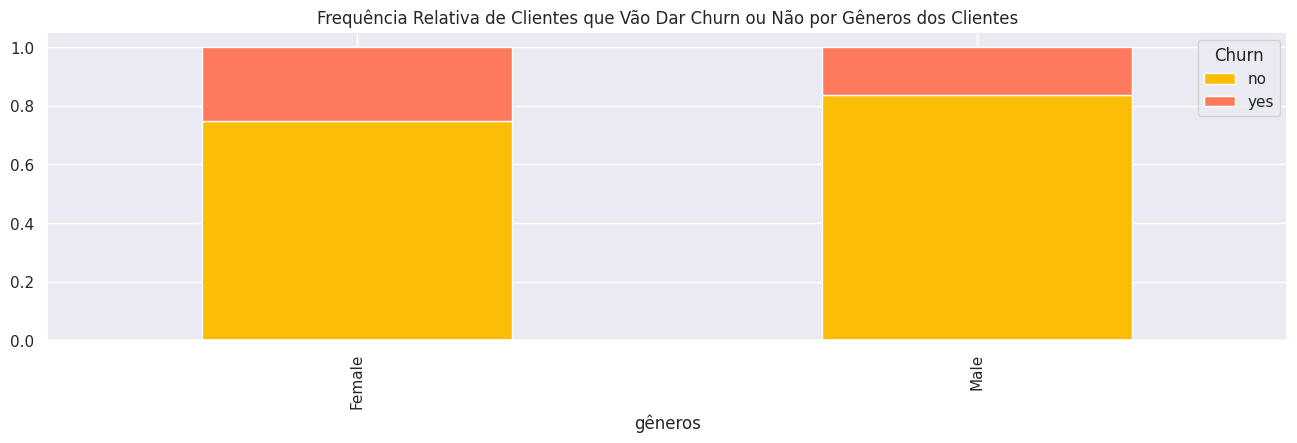

In [53]:
table = pd.crosstab(df4['genero'], df4['Churn'], normalize='index')
table = table.div(table.sum(1), axis=0)
table.plot(kind='bar', stacked=True)

# Adiciona títulos e etiquetas
plt.title('Frequência Relativa de Clientes que Vão Dar Churn ou Não por Gêneros dos Clientes')
plt.xlabel('gêneros')

# Exibe o gráfico
plt.show()

#### *tem_cartao_credito*

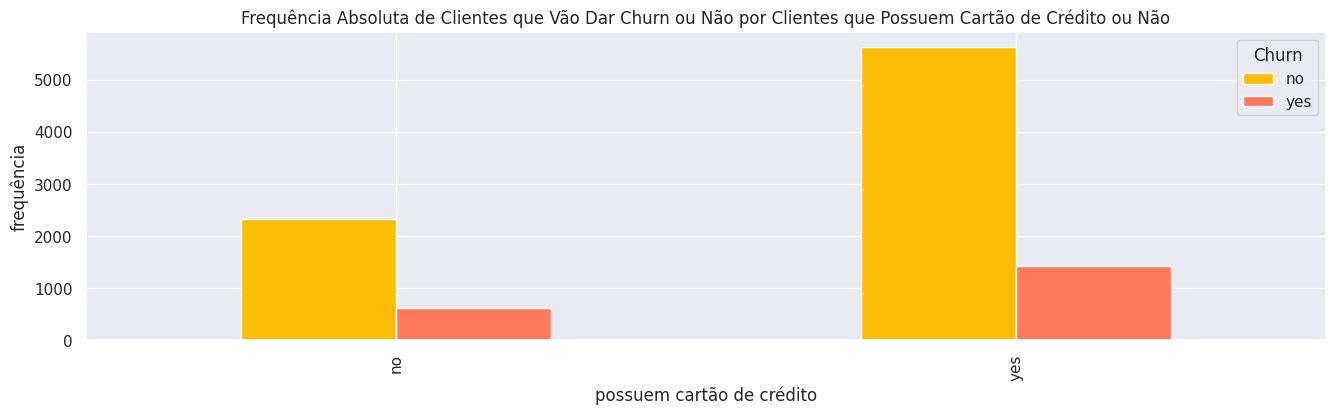

In [54]:
df_aux = df4[['id_cliente','Churn', 'tem_cartao_credito']].groupby(['Churn','tem_cartao_credito']).count()
df_aux.reset_index().pivot(index='tem_cartao_credito', columns='Churn', values='id_cliente').plot(kind='bar')

# Adiciona títulos e etiquetas
plt.title('Frequência Absoluta de Clientes que Vão Dar Churn ou Não por Clientes que Possuem Cartão de Crédito ou Não')
plt.xlabel('possuem cartão de crédito')
plt.ylabel('frequência')
plt.legend(title= 'Churn');

# Exibe o gráfico
plt.show()

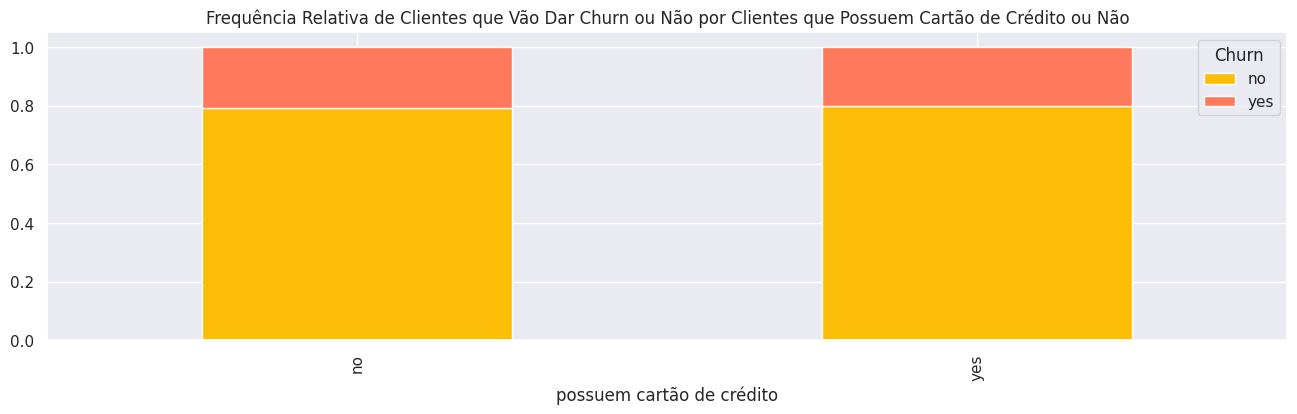

In [55]:
table = pd.crosstab(df4['tem_cartao_credito'], df4['Churn'], normalize='index')
table = table.div(table.sum(1), axis=0)
table.plot(kind='bar', stacked=True)

# Adiciona títulos e etiquetas
plt.title('Frequência Relativa de Clientes que Vão Dar Churn ou Não por Clientes que Possuem Cartão de Crédito ou Não')
plt.xlabel('possuem cartão de crédito')

# Exibe o gráfico
plt.show()

#### *membro_ativo*

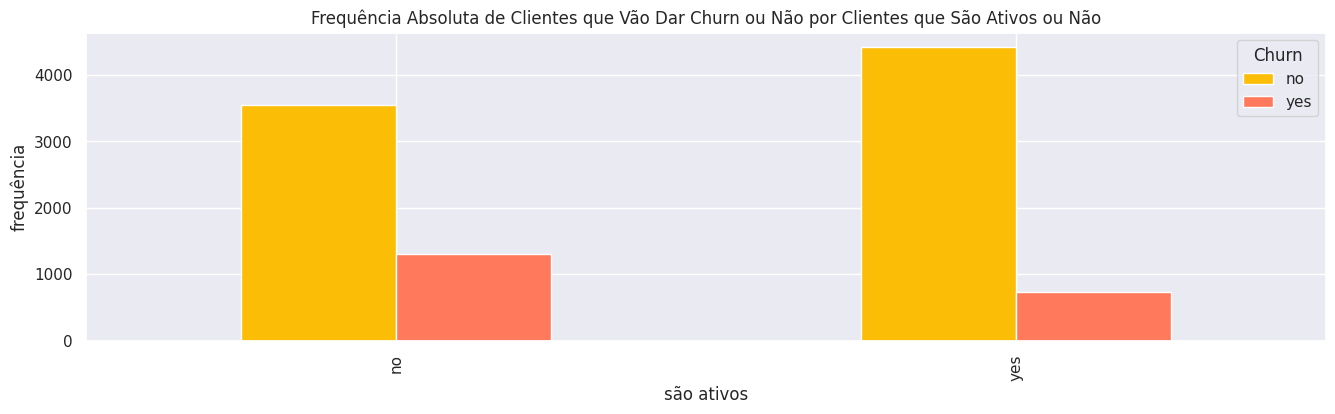

In [56]:
df_aux = df4[['id_cliente','Churn', 'membro_ativo']].groupby(['Churn','membro_ativo']).count()
df_aux.reset_index().pivot(index='membro_ativo', columns='Churn', values='id_cliente').plot(kind='bar')

# Adiciona títulos e etiquetas
plt.title('Frequência Absoluta de Clientes que Vão Dar Churn ou Não por Clientes que São Ativos ou Não')
plt.xlabel('são ativos')
plt.ylabel('frequência')
plt.legend(title= 'Churn');

# Exibe o gráfico
plt.show()

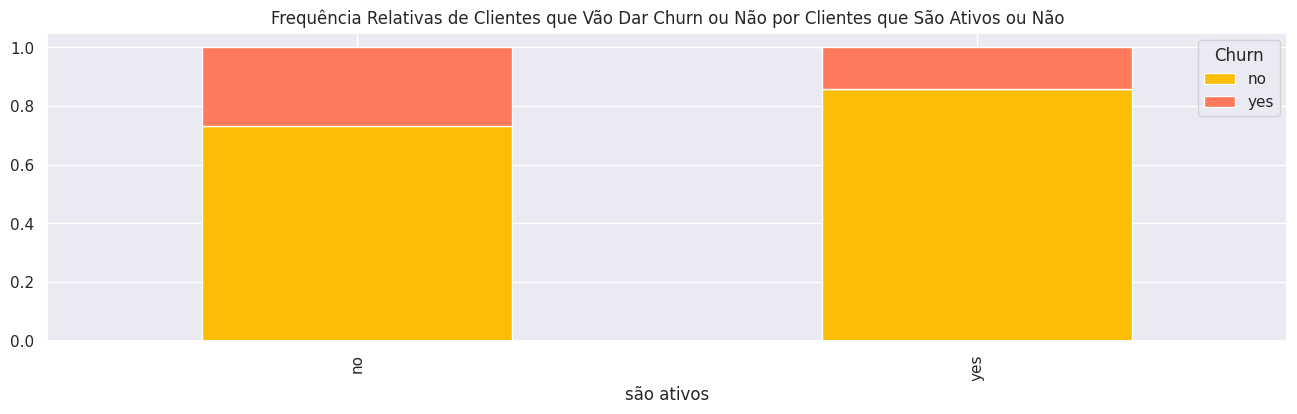

In [57]:
table = pd.crosstab(df4['membro_ativo'], df4['Churn'], normalize='index')
table = table.div(table.sum(1), axis=0)
table.plot(kind='bar', stacked=True)

# Adiciona títulos e etiquetas
plt.title('Frequência Relativas de Clientes que Vão Dar Churn ou Não por Clientes que São Ativos ou Não')
plt.xlabel('são ativos')

# Exibe o gráfico
plt.show()

#### *escala_fico*

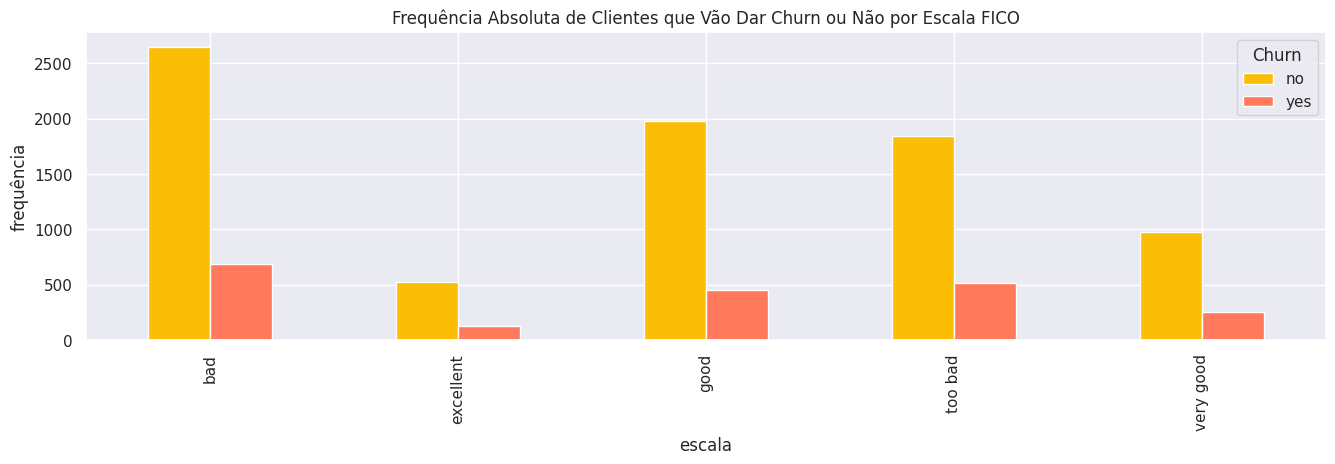

In [58]:
df_aux = df4[['id_cliente','Churn', 'escala_fico']].groupby(['Churn','escala_fico']).count()
df_aux.reset_index().pivot(index='escala_fico', columns='Churn', values='id_cliente').plot(kind='bar')

# Adiciona títulos e etiquetas
plt.title('Frequência Absoluta de Clientes que Vão Dar Churn ou Não por Escala FICO')
plt.xlabel('escala')
plt.ylabel('frequência')
plt.legend(title= 'Churn');

# Exibe o gráfico
plt.show()

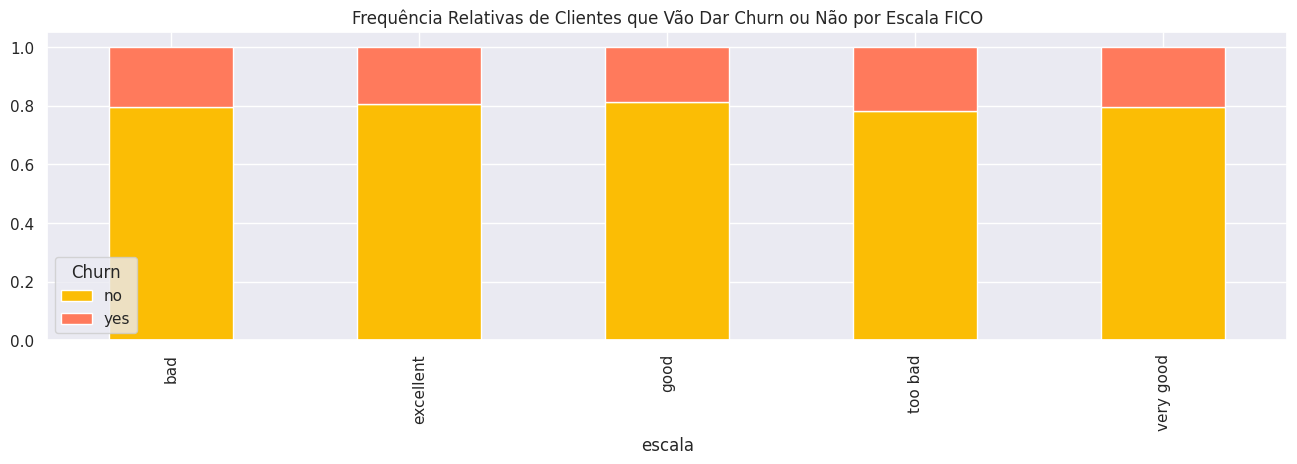

In [59]:
table = pd.crosstab(df4['escala_fico'], df4['Churn'], normalize='index')
table = table.div(table.sum(1), axis=0)
table.plot(kind='bar', stacked=True)

# Adiciona títulos e etiquetas
plt.title('Frequência Relativas de Clientes que Vão Dar Churn ou Não por Escala FICO')
plt.xlabel('escala')

# Exibe o gráfico
plt.show()

## Multivariate Analysis

### Categorical Variables

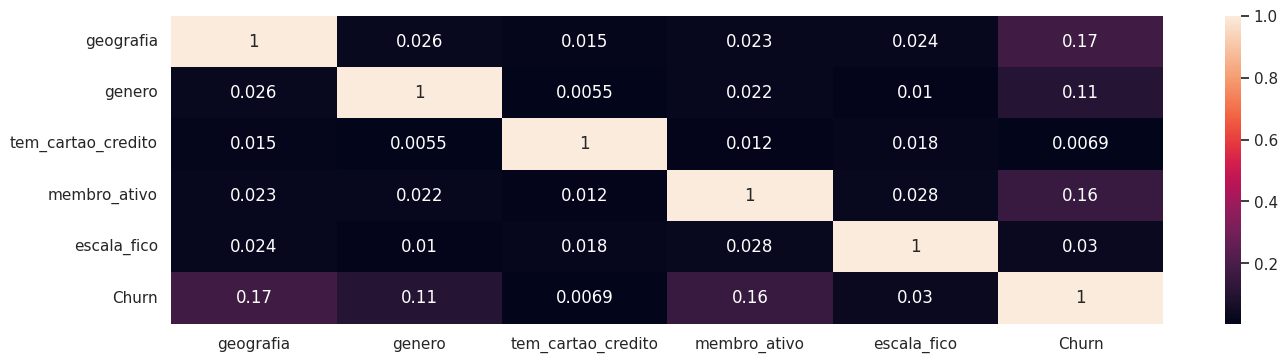

In [60]:
categorical_dataframe = categorical_attributes

#calculate Cramer's V
cramer_v1 = cramer_v(categorical_dataframe['geografia'], categorical_dataframe['geografia'])
cramer_v2 = cramer_v(categorical_dataframe['geografia'], categorical_dataframe['genero'])
cramer_v3 = cramer_v(categorical_dataframe['geografia'], categorical_dataframe['tem_cartao_credito'])
cramer_v4 = cramer_v(categorical_dataframe['geografia'], categorical_dataframe['membro_ativo'])
cramer_v5 = cramer_v(categorical_dataframe['geografia'], categorical_dataframe['escala_fico'])
cramer_v6 = cramer_v(categorical_dataframe['geografia'], categorical_dataframe['Churn'])

cramer_v7 = cramer_v(categorical_dataframe['genero'], categorical_dataframe['geografia'])
cramer_v8 = cramer_v(categorical_dataframe['genero'], categorical_dataframe['genero'])
cramer_v9 = cramer_v(categorical_dataframe['genero'], categorical_dataframe['tem_cartao_credito'])
cramer_v10 = cramer_v(categorical_dataframe['genero'], categorical_dataframe['membro_ativo'])
cramer_v11 = cramer_v(categorical_dataframe['genero'], categorical_dataframe['escala_fico'])
cramer_v12 = cramer_v(categorical_dataframe['genero'], categorical_dataframe['Churn'])

cramer_v13 = cramer_v(categorical_dataframe['tem_cartao_credito'], categorical_dataframe['geografia'])
cramer_v14 = cramer_v(categorical_dataframe['tem_cartao_credito'], categorical_dataframe['genero'])
cramer_v15 = cramer_v(categorical_dataframe['tem_cartao_credito'], categorical_dataframe['tem_cartao_credito'])
cramer_v16 = cramer_v(categorical_dataframe['tem_cartao_credito'], categorical_dataframe['membro_ativo'])
cramer_v17 = cramer_v(categorical_dataframe['tem_cartao_credito'], categorical_dataframe['escala_fico'])
cramer_v18 = cramer_v(categorical_dataframe['tem_cartao_credito'], categorical_dataframe['Churn'])

cramer_v19 = cramer_v(categorical_dataframe['membro_ativo'], categorical_dataframe['geografia'])
cramer_v20 = cramer_v(categorical_dataframe['membro_ativo'], categorical_dataframe['genero'])
cramer_v21 = cramer_v(categorical_dataframe['membro_ativo'], categorical_dataframe['tem_cartao_credito'])
cramer_v22 = cramer_v(categorical_dataframe['membro_ativo'], categorical_dataframe['membro_ativo'])
cramer_v23 = cramer_v(categorical_dataframe['membro_ativo'], categorical_dataframe['escala_fico'])
cramer_v24 = cramer_v(categorical_dataframe['membro_ativo'], categorical_dataframe['Churn'])

cramer_v25 = cramer_v(categorical_dataframe['escala_fico'], categorical_dataframe['geografia'])
cramer_v26 = cramer_v(categorical_dataframe['escala_fico'], categorical_dataframe['genero'])
cramer_v27 = cramer_v(categorical_dataframe['escala_fico'], categorical_dataframe['tem_cartao_credito'])
cramer_v28 = cramer_v(categorical_dataframe['escala_fico'], categorical_dataframe['membro_ativo'])
cramer_v29 = cramer_v(categorical_dataframe['escala_fico'], categorical_dataframe['escala_fico'])
cramer_v30 = cramer_v(categorical_dataframe['escala_fico'], categorical_dataframe['Churn'])

cramer_v31 = cramer_v(categorical_dataframe['Churn'], categorical_dataframe['geografia'])
cramer_v32 = cramer_v(categorical_dataframe['Churn'], categorical_dataframe['genero'])
cramer_v33 = cramer_v(categorical_dataframe['Churn'], categorical_dataframe['tem_cartao_credito'])
cramer_v34 = cramer_v(categorical_dataframe['Churn'], categorical_dataframe['membro_ativo'])
cramer_v35 = cramer_v(categorical_dataframe['Churn'], categorical_dataframe['escala_fico'])
cramer_v36 = cramer_v(categorical_dataframe['Churn'], categorical_dataframe['Churn'])

#final dataset
cramer_v_dataset = pd.DataFrame({'geografia': [cramer_v1, cramer_v2, cramer_v3, cramer_v4, cramer_v5, cramer_v6],
                                 'genero': [cramer_v7, cramer_v8, cramer_v9, cramer_v10, cramer_v11, cramer_v12], 
                                 'tem_cartao_credito': [cramer_v13, cramer_v14, cramer_v15, cramer_v16, cramer_v17, cramer_v18],
                                 'membro_ativo': [cramer_v19, cramer_v20, cramer_v21, cramer_v22, cramer_v23, cramer_v24],
                                 'escala_fico': [cramer_v25, cramer_v26, cramer_v27, cramer_v28, cramer_v29, cramer_v30],
                                 'Churn': [cramer_v31, cramer_v32, cramer_v33, cramer_v34, cramer_v35, cramer_v36]})

cramer_v_dataset = cramer_v_dataset.set_index(cramer_v_dataset.columns)

sns.heatmap(cramer_v_dataset, annot= True);

### Numeric Variables

In [61]:
df4['Churn'] = df4['Churn'].apply(lambda x: 1 if x == 'yes' else 0)

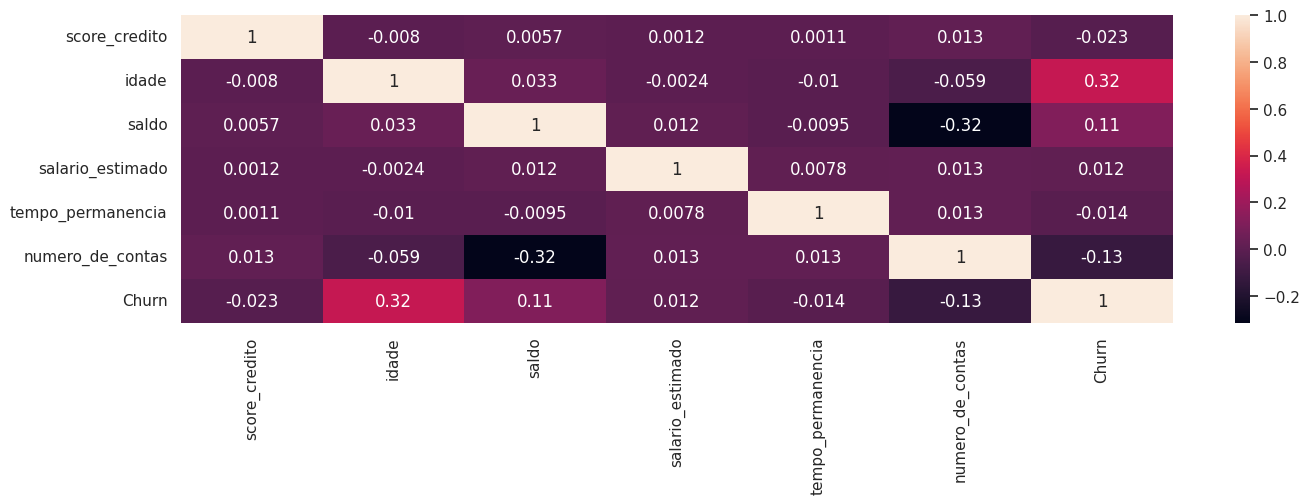

In [62]:
variables =  df4[['score_credito', 'idade', 'saldo', 'salario_estimado', 'tempo_permanencia', 'numero_de_contas', 'Churn']]
correlation = variables.corr(method= 'spearman')
sns.heatmap(correlation, annot= True);

## Note:
Informações Importantes:

**Análise Univariada:**
- ***score_credito***: existem poucos outliers que não são tão relevantes devido ao valor da curtose, logo podem permanecer.
- ***idade***: existem muitos outliers relevantes na variável, acima de 62 anos. Vale tratá-los.
- ***salario_estimado***: mais de 36% dos clientes possuem contas zeradas, evidenciado pela variável .
- ***numero_de_contas***: apenas 3,26% de cleintes possuem 3 ou 4 contas.
- ***geografia***: metade dos clientes são da França (50,14%). A outra metade se divide praticamente igual entre Alemanha (25.09%) e Espanha (24.77%)
- ***tem_cartao_credito***: 70.55% dos clientes possuem cartão de crédito.
- ***escala_fico***: menos de 20% possuem scores muito bons ou excelentes.

**Análise Bivariada e Multivariada**
- ***score_credito***: não há efeito significativo na variável Churn. Apenas poucos outliers com scores próximos de 350 na distribuição de clientes positivos para Churn. Correlação muito fraca com a variável Churn = -0.023
- ***idade***: <span style="background:LightGreen">pode ter efeito significativo na variável Churn. Clientes negativos para churn tendem a ser mais novos (metade dos dados entre 32 - 42 anos e presença de muitos outliers a partir de 56 anos) e clientes positivos tendem a ser mais velhos (metade dos dados entre 36 - 52 anos e presença de poucos outliers a partir de 70 anos e abaixo de 19). Correlação moderada com a variável Churn = 0.32</span>
- ***saldo***: <span style="background:LightYellow">pode ter pouco efeito significativo na variável Churn. A diferença que chama atenção entre as distribuições, é a presença de 0, onde clientes positivos para churn e que possuem o saldo zerado são quase o dobro em relação aos clientes negativos para churn e que possuem o saldo zerado. Correlação fraca com a variável Churn = 0.11</span>
- ***salario_estimado***: não deve ter efeito significativo na variável Churn. Apenas chama atenção um detalhe, onde salários maiores, próximos de US200000.00 tem uma proporção de Churn maior. Correlação muito fraca com a variável Churn = 0.012
- ***tempo_permanencia***: não deve ter efeito significativo na variável Churn. Todas os anos possuem quase o mesmo padrão, onde 20% querem sair do banco e 80% não. Correlação muito fraca com a variável Churn = -0.014
- ***numero_de_contas***: <span style="background:LightYellow">pode ter pouco efeito na variável Churn. 100% dos que possuem 4 contas e 80% dos que possuem 3 contas querem sair do banco, porém esses clientes que possuem 3 ou 4 representam um porcentagem muito pequena do conjunto de dados (menos de 5%). Mas possui uma correlação fraca com a variável Churn = -0.13</span>

- ***geografia***: <span style="background:LightYellow">pode ter pouco efeito significativo na variável Churn. De todos os clientes que residem na França ou na Espanha, apenas 16% querem sair do banco. Mas a Alemanha tem essa proporção dobrada, 32% querem sair do banco. Correlação fraca com a variável Churn = 0.17</span>

- ***genero***: <span style="background:LightYellow">pode ter pouco efeito significativo na variável Churn. Mulheres querem sair do banco mais que os homens. 25% das mulheres e 16% dos homens. Correlação fraca com a variável Churn = 0.11</span>

- ***tem_cartao_credito***: não há efeito significativo na variável Churn. De todos os cliente que possuem cartão ou não, apenas 20% querem sair do banco. Correlação muito fraca com a variável Churn = 0.0069

- ***membro_ativo***: <span style="background:LightYellow">pode ter pouco efeito significativo na variável Churn. Essa variável possui quase o mesmo comportamento da variável gênero, onde Clientes inativos querem sair do banco mais que os inativos. 26%  dos inativos e 14% dos ativos. Correlação fraca com a variável Churn = 0.16</span>

- ***escala_fico***: não há efeito significativo na variável Churn. Todas as classes possuem quase o mesmo padrão, onde 20% querem sair do banco e 80% não. Correlação muito fraca com a variável Churn = 0.03

Observação:
- Como o conjunto de dados possui muita dispersão, estou usando a relação de correlação de Jacob Cohen (1992):

	- corr = 0,10 -> correlação fraca.
    - corr = 0,30 -> correlação moderada.
    - corr = 0,50 -> correlação forte

Próxima versão: 
- Utilizar testes estatísticos para validar comportamento das distribuições;
- Testar método PolynomialFeatures sklearn para criação de Features Interactions;
- Melhorar funções para plotagens dos gráficos;

# Feature Engineering (Data Preparation)

In [63]:
df5 = df4.copy()

## Data Filtering

In [64]:
data_for_filtering = df5.copy()

In [65]:
columns_to_delete = ['numero_linha', 'id_cliente', 'sobrenome']
filtered_data = data_for_filtering.drop(columns_to_delete, axis= 1) 

In [66]:
filtered_data.head()

score_credito geografia  genero  idade  tempo_permanencia      saldo  numero_de_contas tem_cartao_credito membro_ativo  salario_estimado  Churn escala_fico
0            619    France  Female     42                  2       0.00                 1                yes          yes         101348.88      1         bad
1            608     Spain  Female     41                  1   83807.86                 1                 no          yes         112542.58      0         bad
2            502    France  Female     42                  8  159660.80                 3                yes           no         113931.57      1     too bad
3            699    France  Female     39                  1       0.00                 2                 no           no          93826.63      0        good
4            850     Spain  Female     43                  2  125510.82                 1                yes          yes          79084.10      0   excellent

## Splitting Dataframe into Training and Test Dataset

In [67]:
X = filtered_data#.drop(columns = ['Churn'])
y = filtered_data['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.33, random_state= 42)

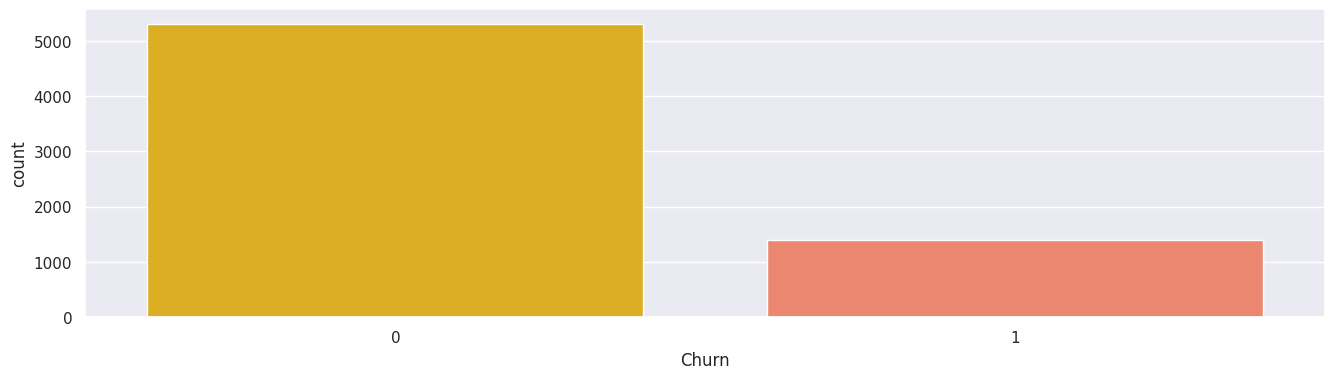

In [68]:
sns.countplot(x= y_train);

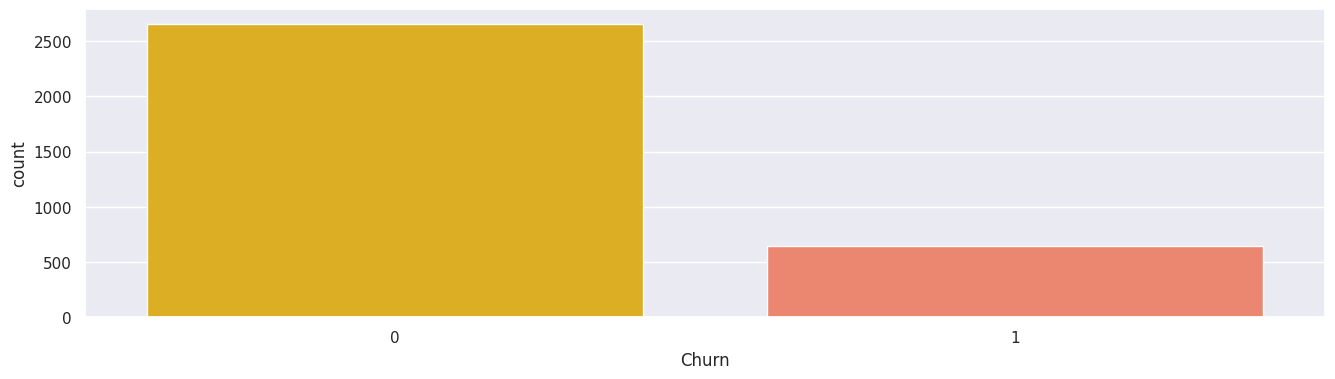

In [69]:
sns.countplot(x= y_test);

## Creation of the New Features II or Feature Interactions

- A estratégia na criação de novas variáveis é usar variáveis reconhecidas pelo brainstorm de negócio e com efeitos significativos na variável Churn evidenciada pela análise exploratória de dados e combiná-las para potencializar seus impactos. 

**Brainstorm**

Principais fatores para um cliente querer fechar uma conta/sair de um banco:

1. Corte de gastos

		P: O que leva uma pessoa a cortar gastos?
		R: Ou o salário foi reduzido, ou faltou organização financeira, entrando em endividamento.
		Variáveis disponíveis impactadas: salario_estimado baixo, score_credito baixo, saldo baixo, tem_cartao_credito, numero de contas alto
	
2. Insatisfação com o Banco

		P: O que leva uma pessoa a estar insatisfeita com um banco?
    	R: Suporte ruim, taxas elevadas, falta de transparência, problemas com transações ou aplicações, falta na segurança dos dados.
		Variáveis disponíveis impactadas: tempo_permanencia curto, negativo para membro_ativo.

3. Concorrente tem mais benefícios
		
        Variáveis disponíveis impactadas: nenhuma.

Principais fatores para um cliente não querer fechar uma conta/sair de um banco:

1. Comodidade aliado com benefícios, e bom produto.
		Variáveis disponíveis que impactam a causa: tempo_permanencia, membro_ativo, numero_de_contas, tem_cartao_credito

**Variáveis**

- Variáveis do Brainstorm: [<span style="background:LightYellow">'saldo', 'membro_ativo', 'numero_de_contas'</span>, 'salario_estimado', 'score_credito', 'tem_cartao_credito', 'tempo_permanencia']
- Variáveis da Análise Exploratória: [<span style="background:LightGreen">'idade'</span>, <span style="background:LightYellow">'saldo', 'geografia', 'genero', 'membro_ativo'</span>, 'salario_estimado'] 

Idéias de Variáveis:

	- saldo por salário (saldo/salario_estimado) -> combinação de impacto fraco + impacto fraco
	- saldo por score de crédito (saldo/score_credito) -> combinação de impacto fraco + impacto muito fraco
    - saldo por numero de contas (saldo/numero_contas) -> combinação de impacto fraco + impacto fraco
	- saldo acumulado por cada ano de idade (saldo/idade) > combinação de impacto fraco + impacto forte
	- salário por numero de contas (salario_estimado/numero_de_contas) -> combinação de impacto fraco + impacto fraco
	- salário por score de crédito (salario_estimado/score_credito) -> combinação de impacto fraco + impacto muito fraco
	- salário total em x ano de permanencia (salario_estimado * tempo_permanencia) -> combinação de impacto fraco + impacto muito fraco
	- salário por idade (salario_estimado/idade) -> combinação de impacto fraco + impacto forte
	- score de crédito por idade (score_credito/idade) -> combinação de impacto muito fraco + impacto forte
	- score de crédito por numero de contas (score_credito/numero_de_contas) -> combinação de impacto muito fraco + impacto fraco
	- tempo no banco por idade (tempo_permanencia/idade) -> combinação de impacto muito fraco + impacto forte
    - tempo no banco por numero de contas (tempo_permanencia/numero_de_contas) combinação de impacto muito fraco + impacto fraco
	- numero de contas por idade (numero_de_contas/idade) -> combinação de impacto fraco + impacto forte
	- numero de contas por tempo permanencia (numero_de_contas/tempo_permanencia) -> combinação impacto fraco + impacto muito fraco
	- média de saldo por idade (media de saldo por agrupamento de idade) -> combinação de impacto fraco + impacto forte
	- média de salário por idade (media de salario_estimado por agrupamento de idade) -> combinação de impacto fraco + impacto forte
    
Observação:

- Criei muitas métricas/features nesse ciclo por dois motivos:

		1. Os significados das variáveis e o período da extração dos dados não são bem definidos. Logo, com mais features criadas, maior a chance de encontrar alguma interação que tenha uma correlação significativa com a variável resposta.
        2. Features Interactions são úteis para modelos lineares. Já modelos baseados em árvore de decisão, já fazem interações desse tipo em seu funcionamento.

In [70]:
X_train['saldo_por_salario'] = X_train['saldo'] / X_train['salario_estimado']
X_test['saldo_por_salario'] = X_test['saldo'] / X_test['salario_estimado']

In [71]:
X_train['saldo_por_score'] = X_train['saldo'] / X_train['score_credito']
X_test['saldo_por_score'] = X_test['saldo'] / X_test['score_credito']

In [72]:
X_train['saldo_por_numero_contas'] = X_train['saldo'] / X_train['numero_de_contas']
X_test['saldo_por_numero_contas'] = X_test['saldo'] / X_test['numero_de_contas']

In [73]:
X_train['saldo_por_idade'] = X_train['saldo'] / X_train['idade']
X_test['saldo_por_idade'] = X_test['saldo'] / X_test['idade']

In [74]:
X_train['salario_por_numero_de_contas'] = X_train['salario_estimado'] / X_train['numero_de_contas']
X_test['salario_por_numero_de_contas'] = X_test['salario_estimado'] / X_test['numero_de_contas']

In [75]:
X_train['salario_por_score'] = X_train['salario_estimado'] / X_train['score_credito']
X_test['salario_por_score'] = X_test['salario_estimado'] / X_test['score_credito']

In [76]:
X_train['salario_x_tempo_permanencia'] = X_train['salario_estimado'] * X_train['tempo_permanencia']
X_test['salario_x_tempo_permanencia'] = X_test['salario_estimado'] * X_test['tempo_permanencia']

In [77]:
X_train['salario_por_idade'] = X_train['salario_estimado'] / X_train['idade']
X_test['salario_por_idade'] = X_test['salario_estimado'] / X_test['idade']

In [78]:
X_train['score_credito_por_idade'] = X_train['score_credito'] / X_train['idade']
X_test['score_credito_por_idade'] = X_test['score_credito'] / X_test['idade']

In [79]:
X_train['score_credito_por_numero_de_contas'] = X_train['score_credito'] / X_train['numero_de_contas']
X_test['score_credito_por_numero_de_contas'] = X_test['score_credito'] / X_test['numero_de_contas']

In [80]:
X_train['tempo_permanencia_por_idade'] = X_train['tempo_permanencia'] / X_train['idade']
X_test['tempo_permanencia_por_idade'] = X_test['tempo_permanencia'] / X_test['idade']

In [81]:
X_train['tempo_permanencia_por_numero_de_contas'] = X_train['tempo_permanencia'] / X_train['numero_de_contas']
X_test['tempo_permanencia_por_numero_de_contas'] = X_test['tempo_permanencia'] / X_test['numero_de_contas']

In [82]:
X_train['numero_contas_por_idade'] = X_train['numero_de_contas'] / X_train['idade']
X_test['numero_contas_por_idade'] = X_test['numero_de_contas'] / X_test['idade']

In [83]:
X_train['numero_de_contas_por_tempo_permanencia'] = X_train['numero_de_contas'] / X_train['tempo_permanencia']
X_train['numero_de_contas_por_tempo_permanencia'] = X_train['numero_de_contas_por_tempo_permanencia'].apply(lambda x: 0 if x == np.inf else x)
X_test['numero_de_contas_por_tempo_permanencia'] = X_test['numero_de_contas'] / X_test['tempo_permanencia']
X_test['numero_de_contas_por_tempo_permanencia'] = X_test['numero_de_contas_por_tempo_permanencia'].apply(lambda x: 0 if x == np.inf else x)

In [84]:
# X_train
mean_balance_for_age = X_train[['saldo', 'idade']].groupby('idade').mean().reset_index()
mean_balance_for_age.columns = ['idade', 'media_saldo_por_idade']

#merge'
X_train = pd.merge(X_train, mean_balance_for_age, on= 'idade', how= 'left')

#X_test
mean_balance_for_age = X_test[['saldo', 'idade']].groupby('idade').mean().reset_index()
mean_balance_for_age.columns = ['idade', 'media_saldo_por_idade']

#merge'
X_test = pd.merge(X_test, mean_balance_for_age, on= 'idade', how= 'left')

In [85]:
#X_train
mean_salary_for_age = X_train[['salario_estimado', 'idade']].groupby('idade').mean().reset_index()
mean_salary_for_age.columns = ['idade', 'media_salarial_por_idade']

#merge'
X_train = pd.merge(X_train, mean_salary_for_age, on= 'idade', how= 'left')

#X_test
mean_salary_for_age = X_test[['salario_estimado', 'idade']].groupby('idade').mean().reset_index()
mean_salary_for_age.columns = ['idade', 'media_salarial_por_idade']

#merge'
X_test = pd.merge(X_test, mean_salary_for_age, on= 'idade', how= 'left')

In [86]:
X_train.sample(5)

score_credito geografia  genero  idade  tempo_permanencia      saldo  numero_de_contas tem_cartao_credito membro_ativo  salario_estimado  Churn escala_fico  saldo_por_salario  saldo_por_score  saldo_por_numero_contas  saldo_por_idade  salario_por_numero_de_contas  salario_por_score  salario_x_tempo_permanencia  salario_por_idade  score_credito_por_idade  score_credito_por_numero_de_contas  tempo_permanencia_por_idade  tempo_permanencia_por_numero_de_contas  numero_contas_por_idade  numero_de_contas_por_tempo_permanencia  media_saldo_por_idade  media_salarial_por_idade
4360            682     Spain  Female     59                  0  122661.39                 1                 no          yes          84803.76      0        good           1.446415       179.855411               122661.390      2079.006610                  84803.760000         124.345689                         0.00        1437.351864                11.559322                          682.000000                     0.000000                                0.000000                 0.016949                                0.000000           86324.123500             100801.410500
4448            571    France  Female     33                  9  102017.25                 2                 no           no         128600.49      0     too bad           0.793288       178.664186                51008.625      3091.431818                  64300.245000         225.219772                   1157404.41        3896.984545                17.303030                          285.500000                     0.272727                                4.500000                 0.060606                                0.222222           74906.711233              97870.614623
5015            729    France  Female     32                  7   38550.06                 1                 no          yes         179230.23      0        good           0.215087        52.880741                38550.060      1204.689375                 179230.230000         245.857654                   1254611.61        5600.944688                22.781250                          729.000000                     0.218750                                7.000000                 0.031250                                0.142857           71108.459517              98224.076617
304             749    France    Male     24                  1       0.00                 3                yes          yes          47911.03      0   very good           0.000000         0.000000                    0.000         0.000000                  15970.343333          63.966662                     47911.03        1996.292917                31.208333                          249.666667                     0.041667                                0.333333                 0.125000                                3.000000           74446.905844             106565.436494
501             578   Germany  Female     38                  4  113150.44                 2                yes           no         176712.59      1     too bad           0.640308       195.762007                56575.220      2977.643158                  88356.295000         305.731125                    706850.36        4650.331316                15.210526                          289.000000                     0.105263                                2.000000                 0.052632                                0.500000           73549.581420              97789.119842

### Exploratory Analysis of New Features

#### Univariate Analysis

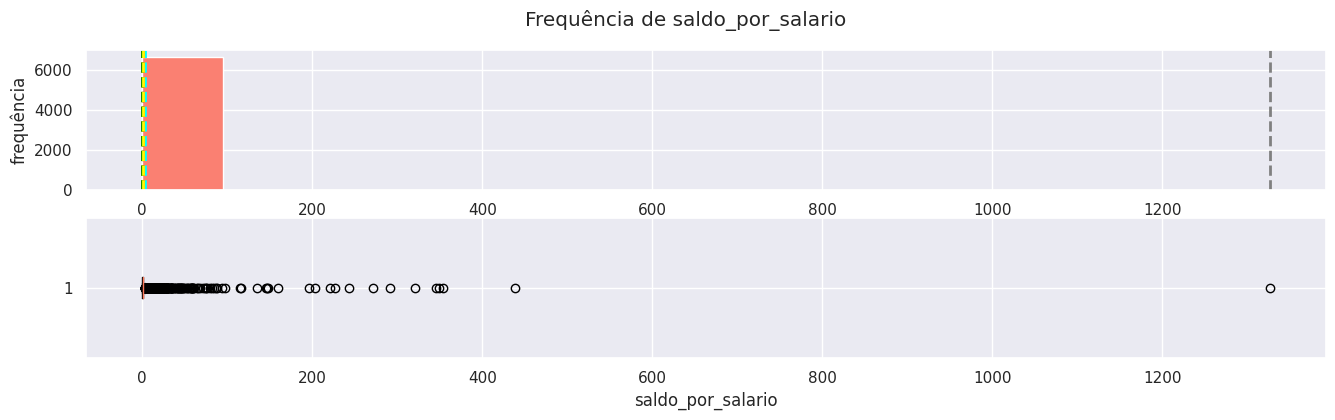

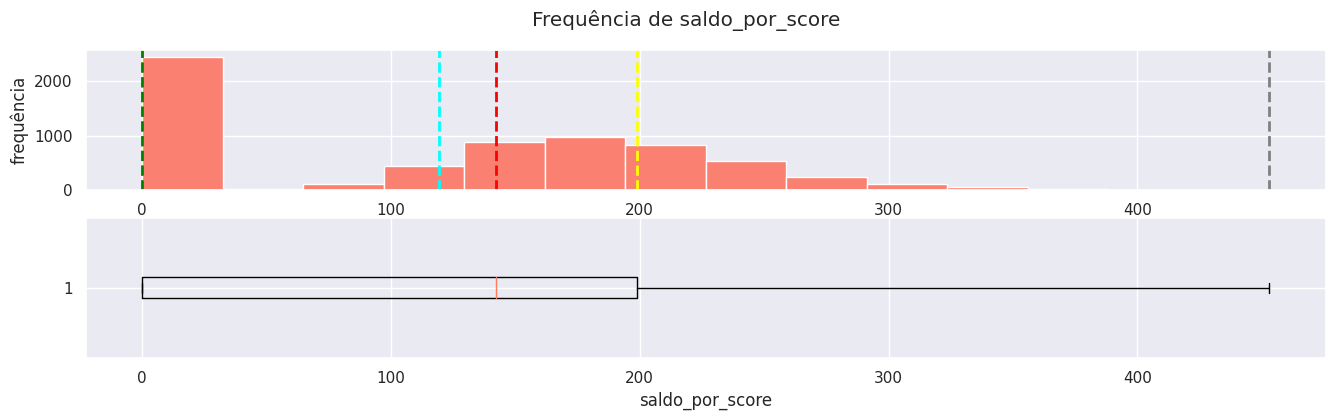

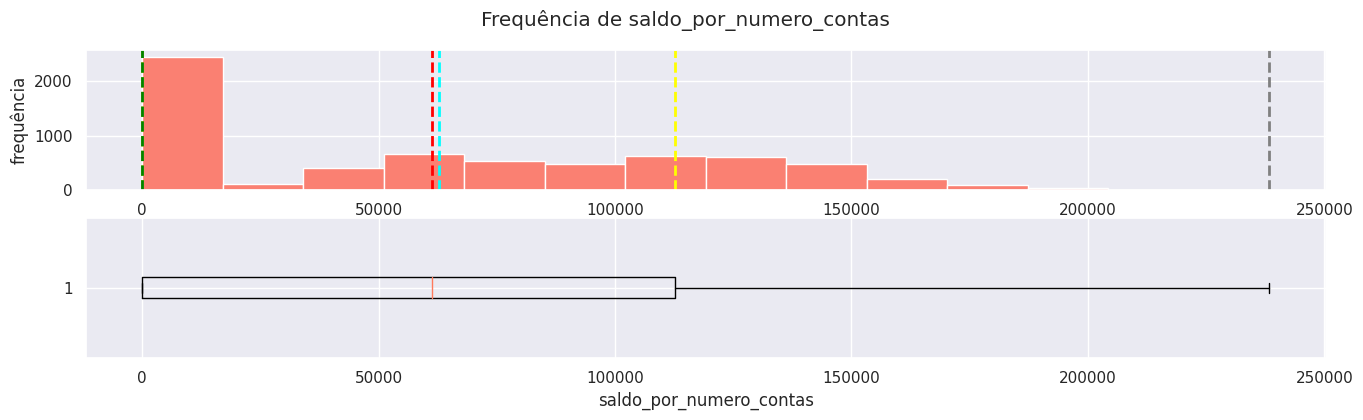

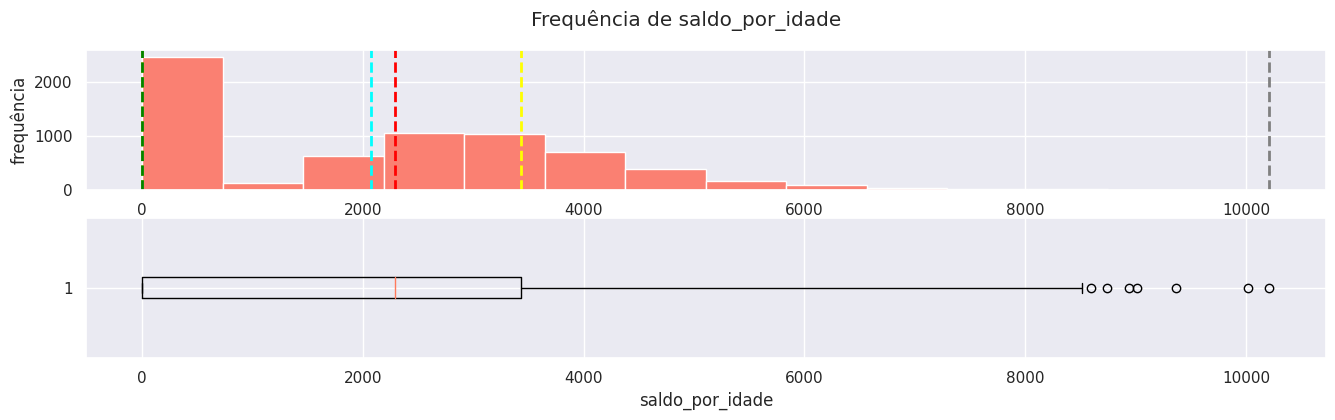

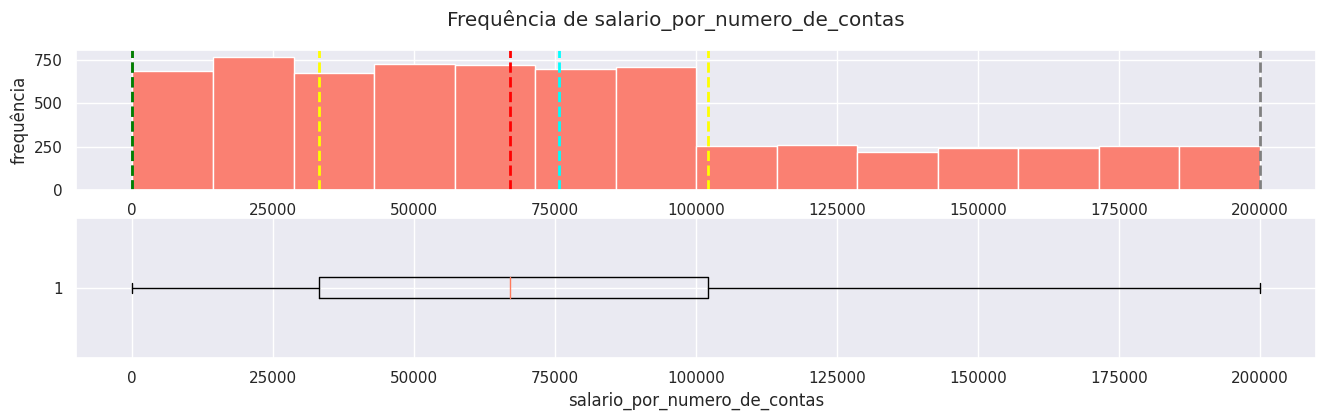

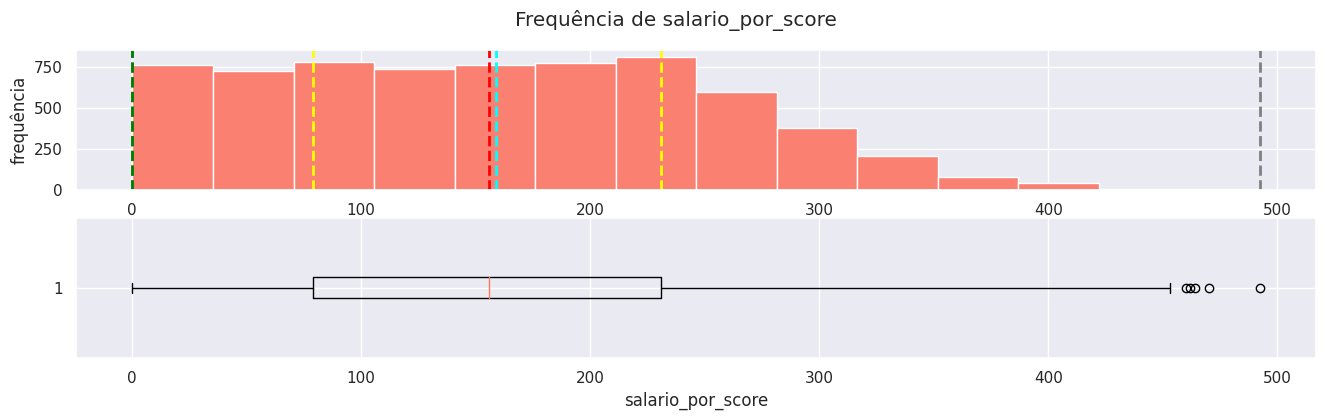

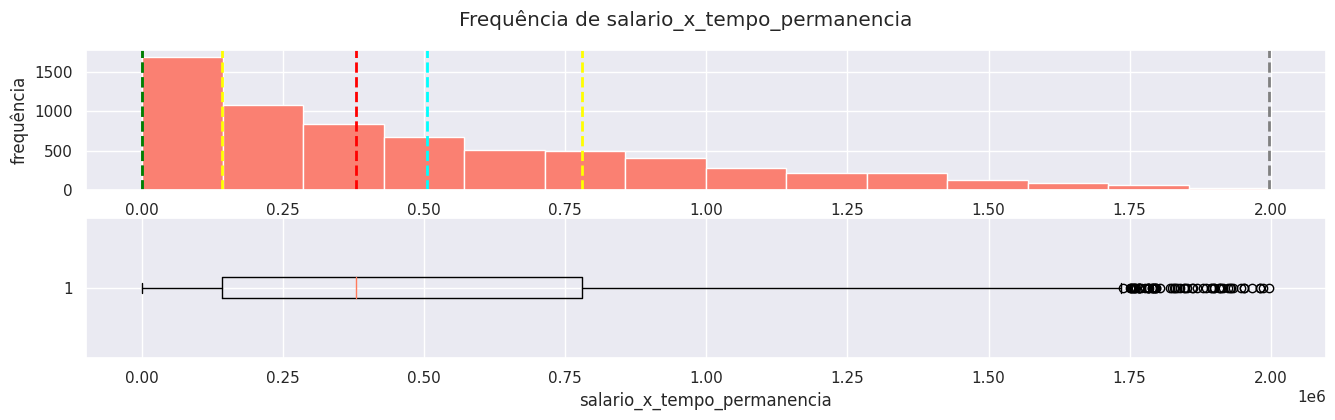

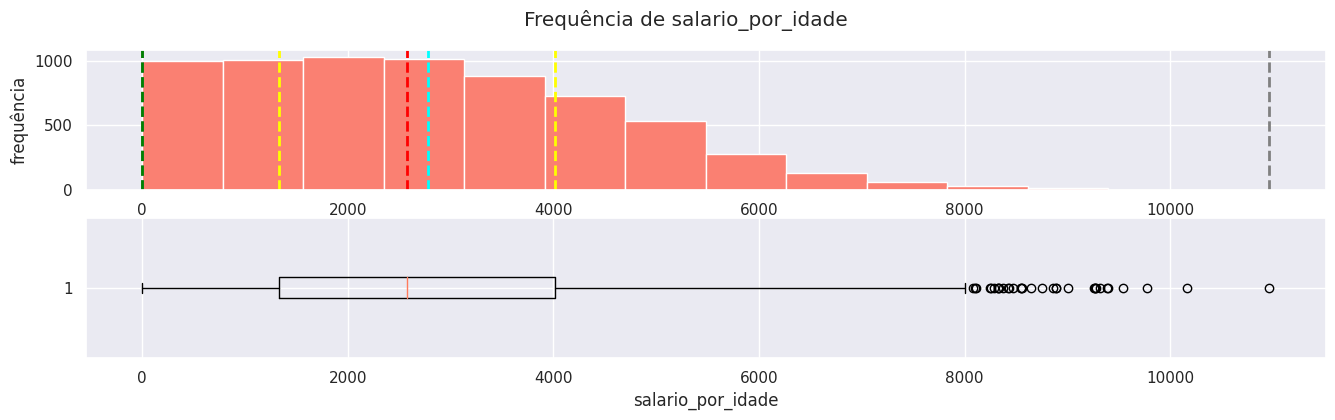

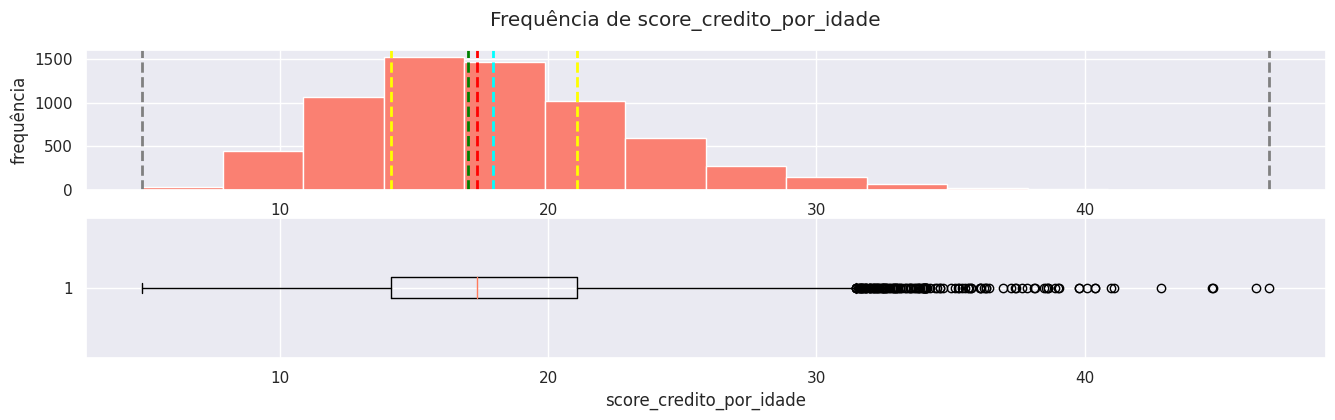

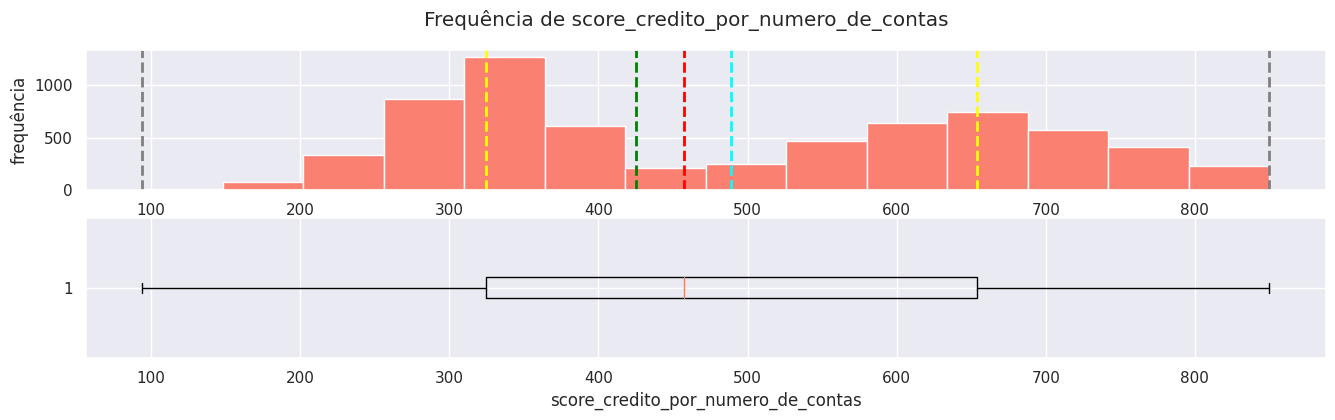

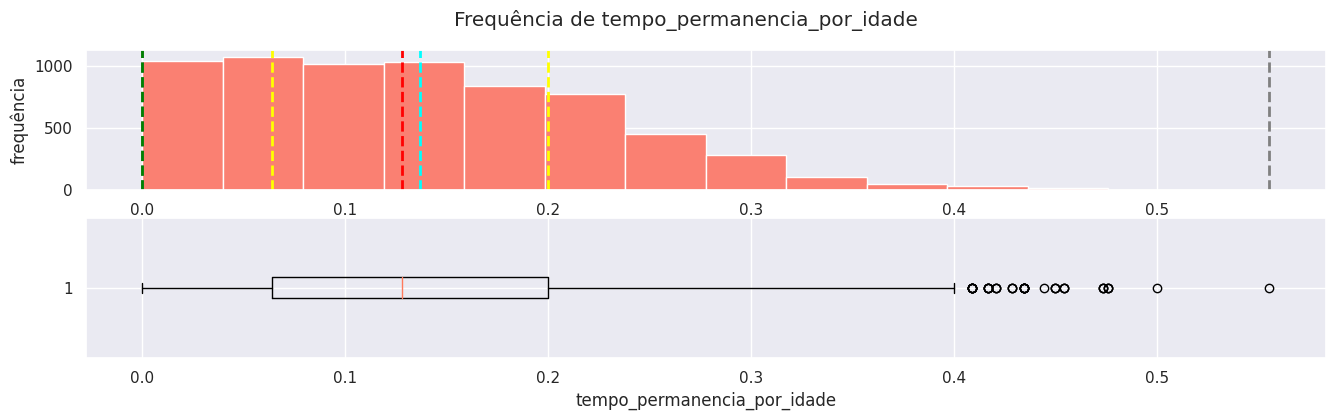

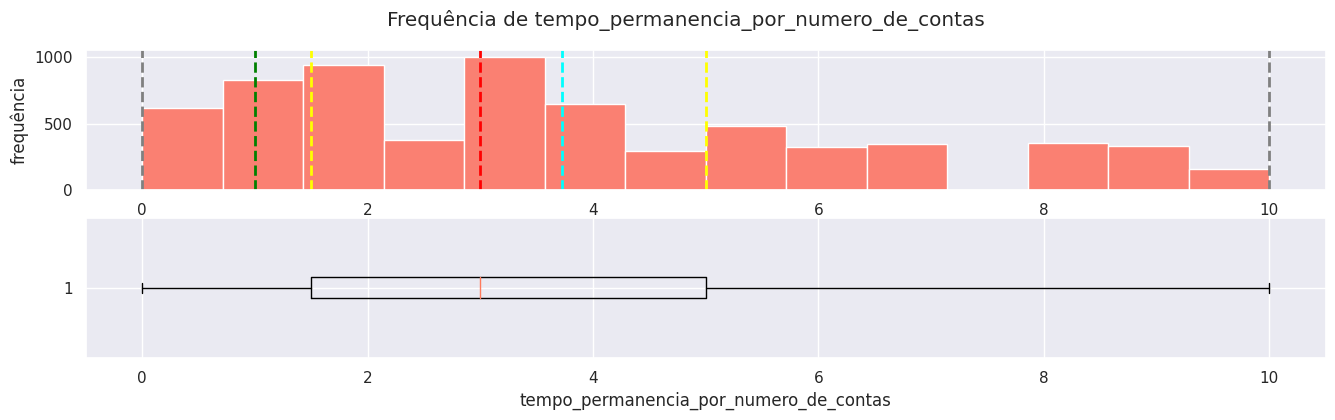

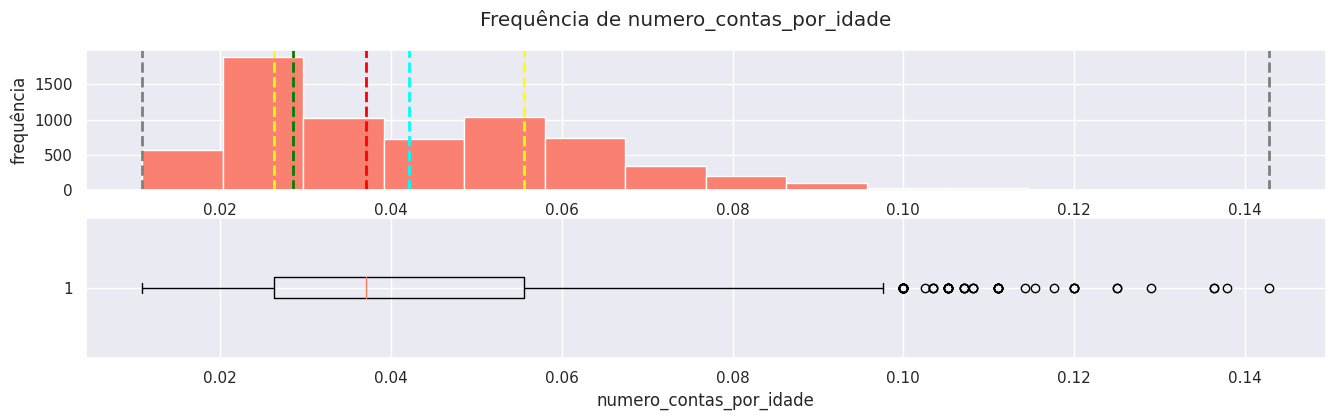

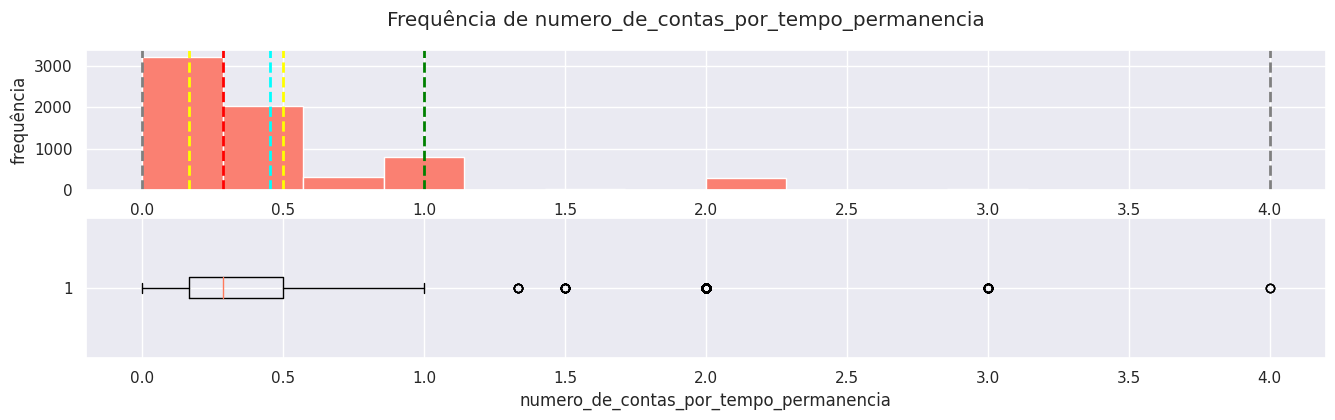

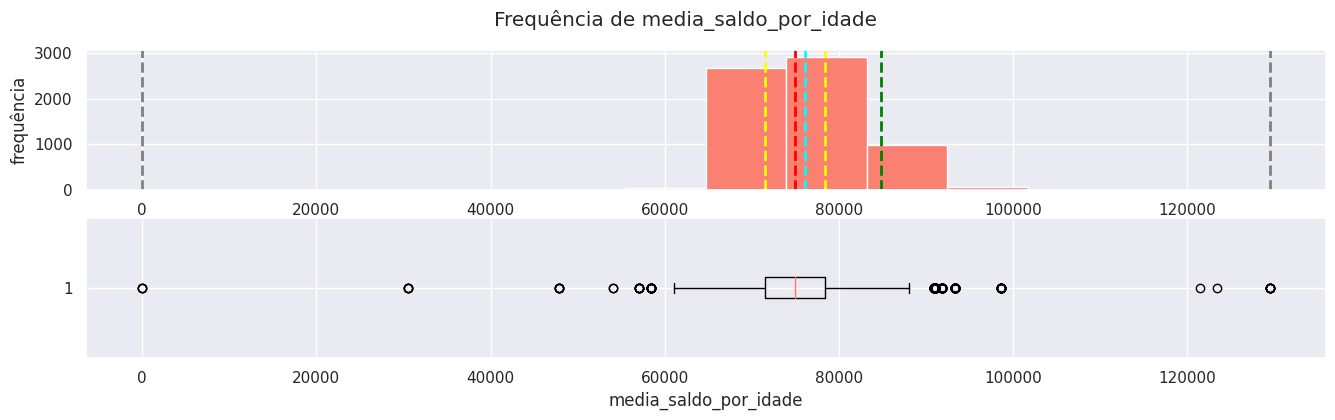

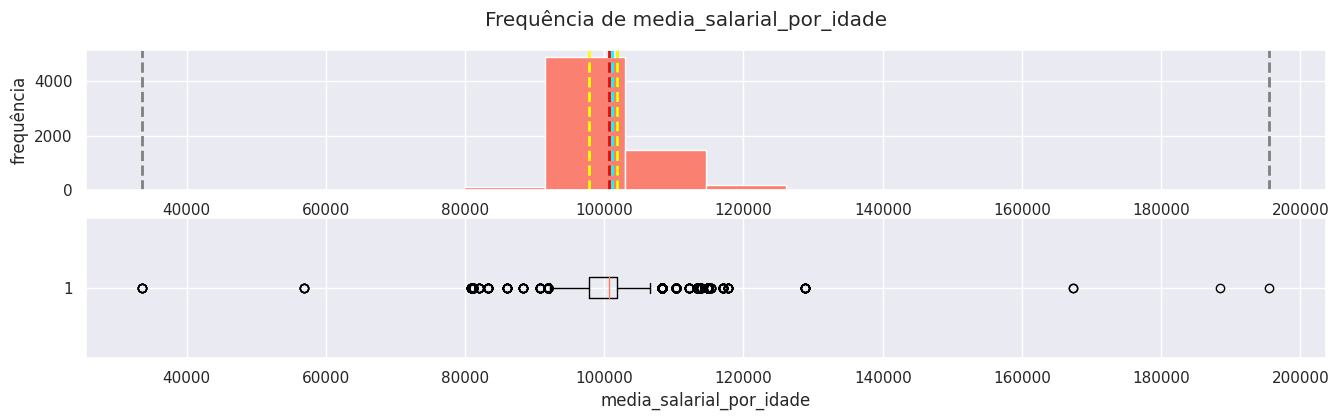

In [87]:
list_variables = ['saldo_por_salario',
       'saldo_por_score', 'saldo_por_numero_contas', 'saldo_por_idade',
       'salario_por_numero_de_contas', 'salario_por_score',
       'salario_x_tempo_permanencia', 'salario_por_idade',
       'score_credito_por_idade', 'score_credito_por_numero_de_contas',
       'tempo_permanencia_por_idade', 'tempo_permanencia_por_numero_de_contas',
       'numero_contas_por_idade', 'numero_de_contas_por_tempo_permanencia',
       'media_saldo_por_idade', 'media_salarial_por_idade']

plot_univariate_numeric_distributions(X_train, list_numerical_variables= list_variables)

#### Bivariate Analysis

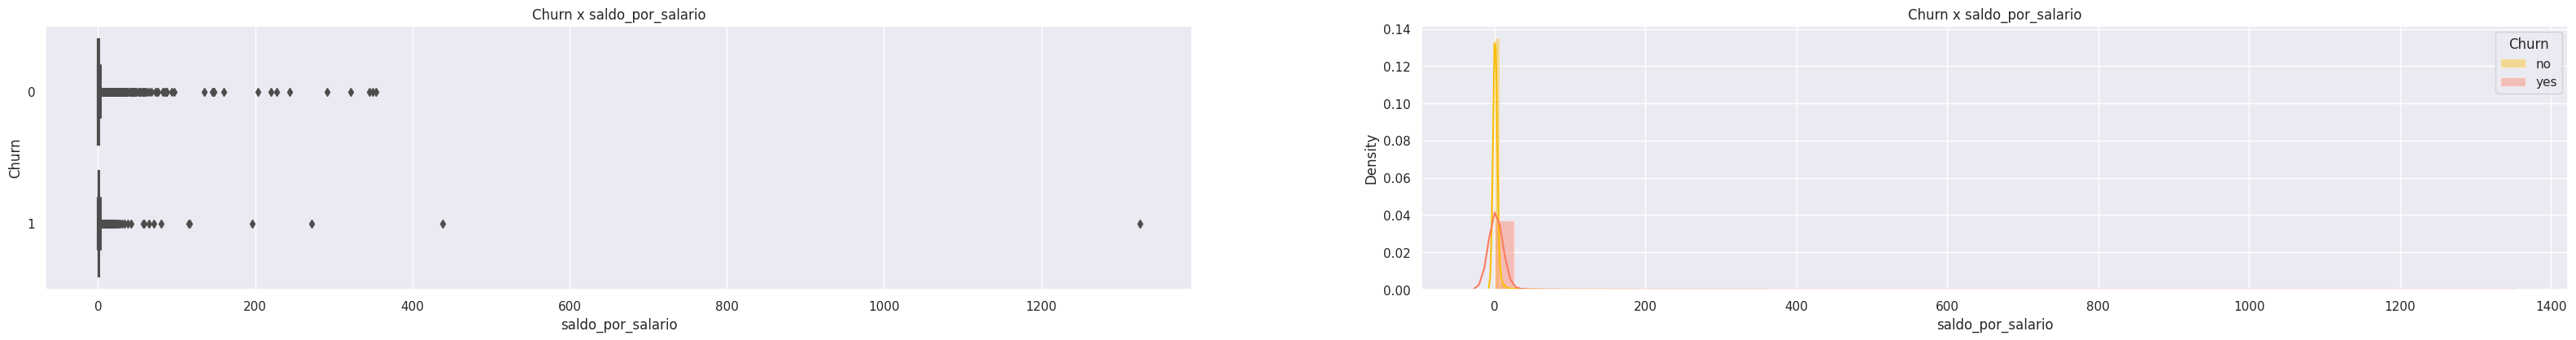

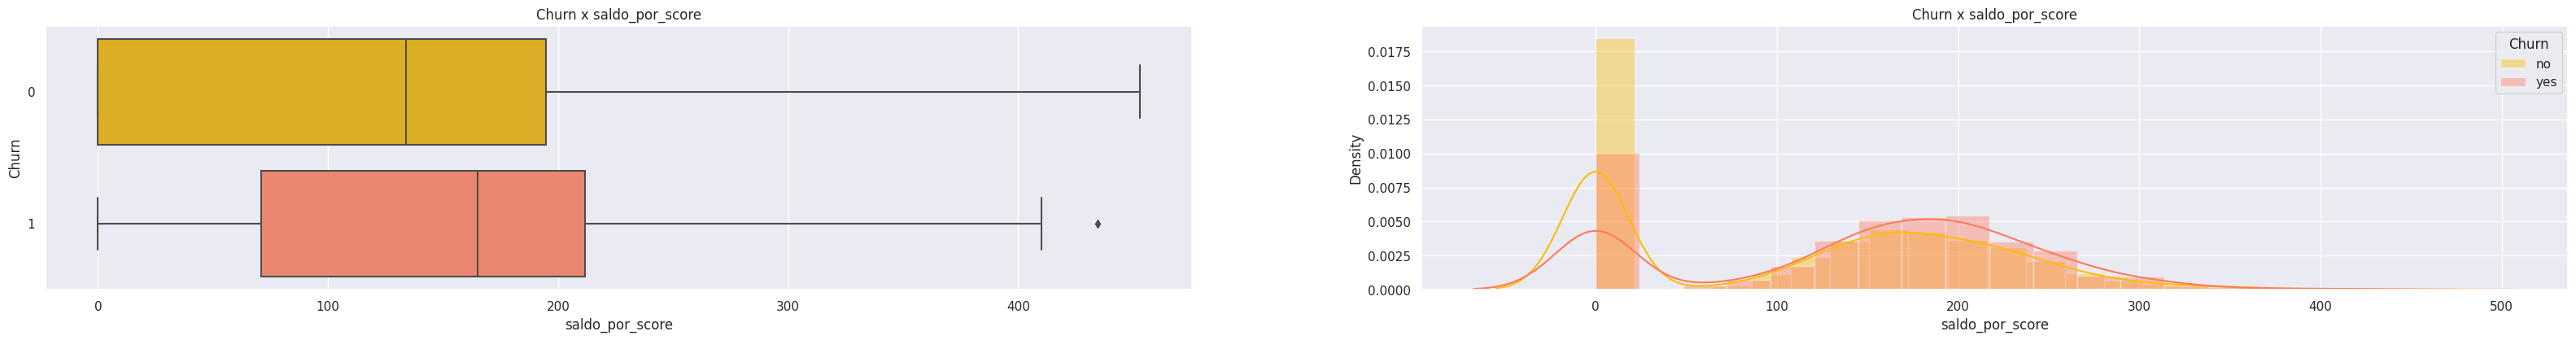

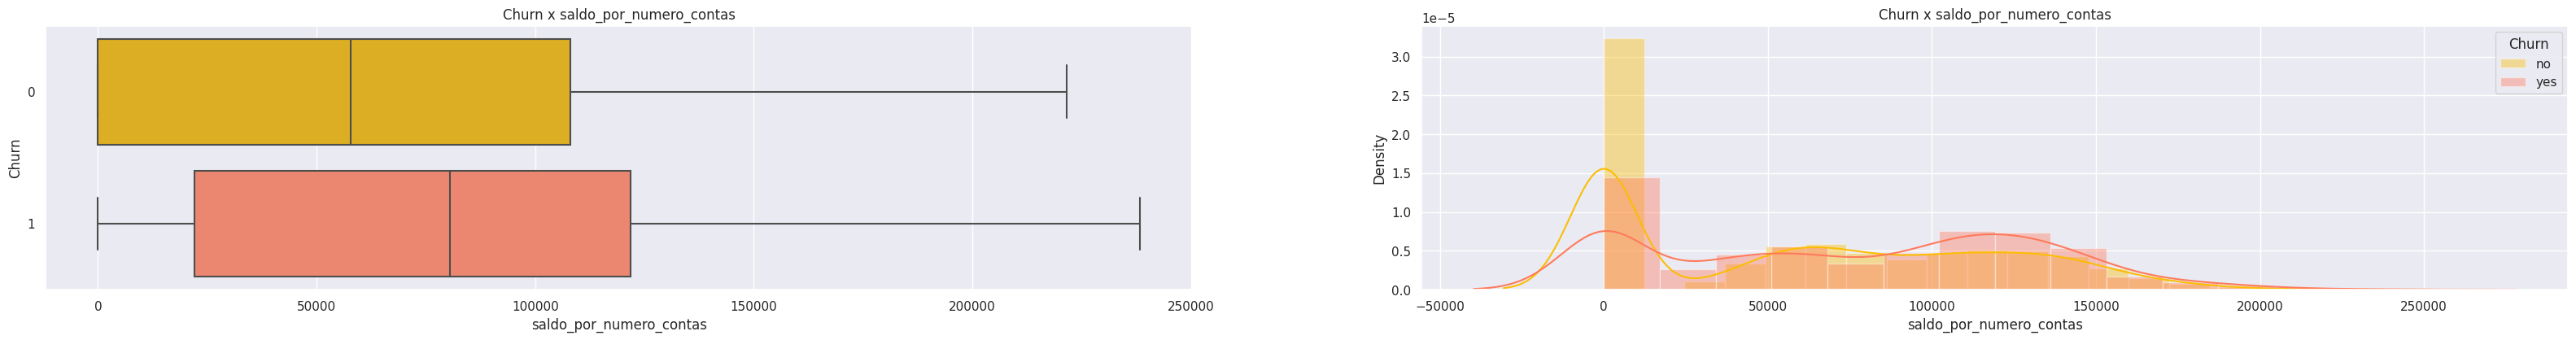

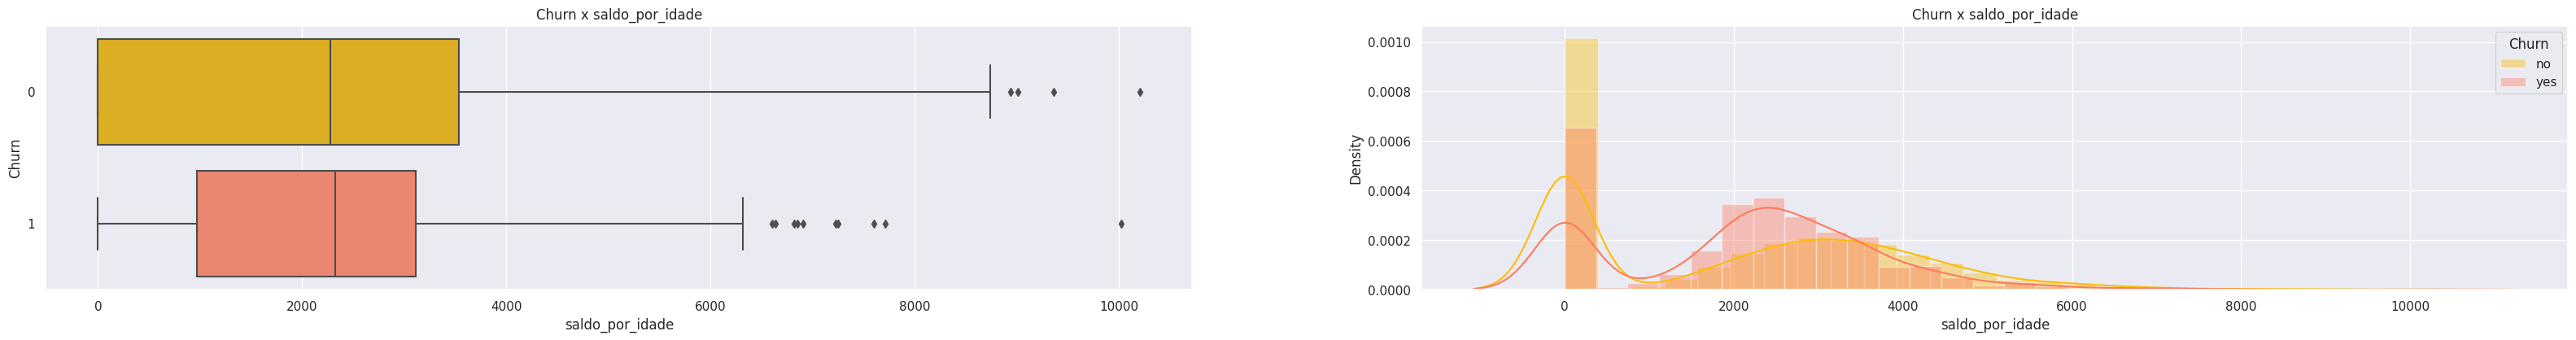

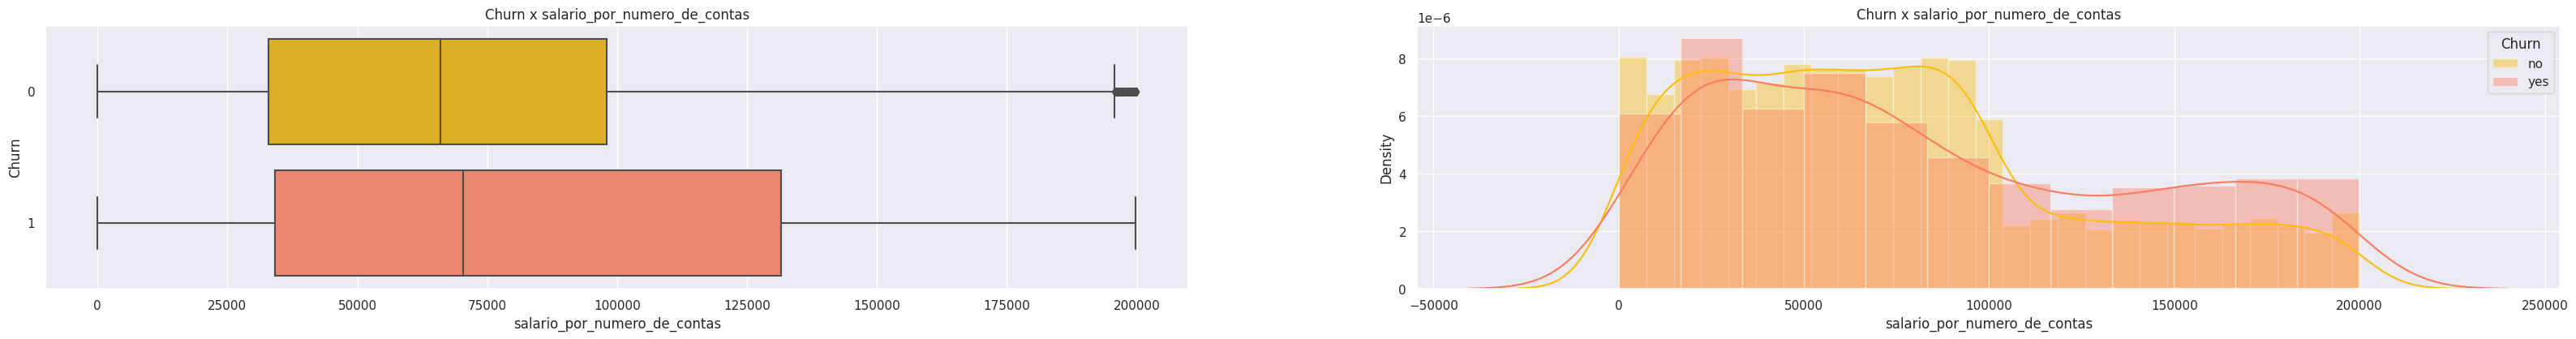

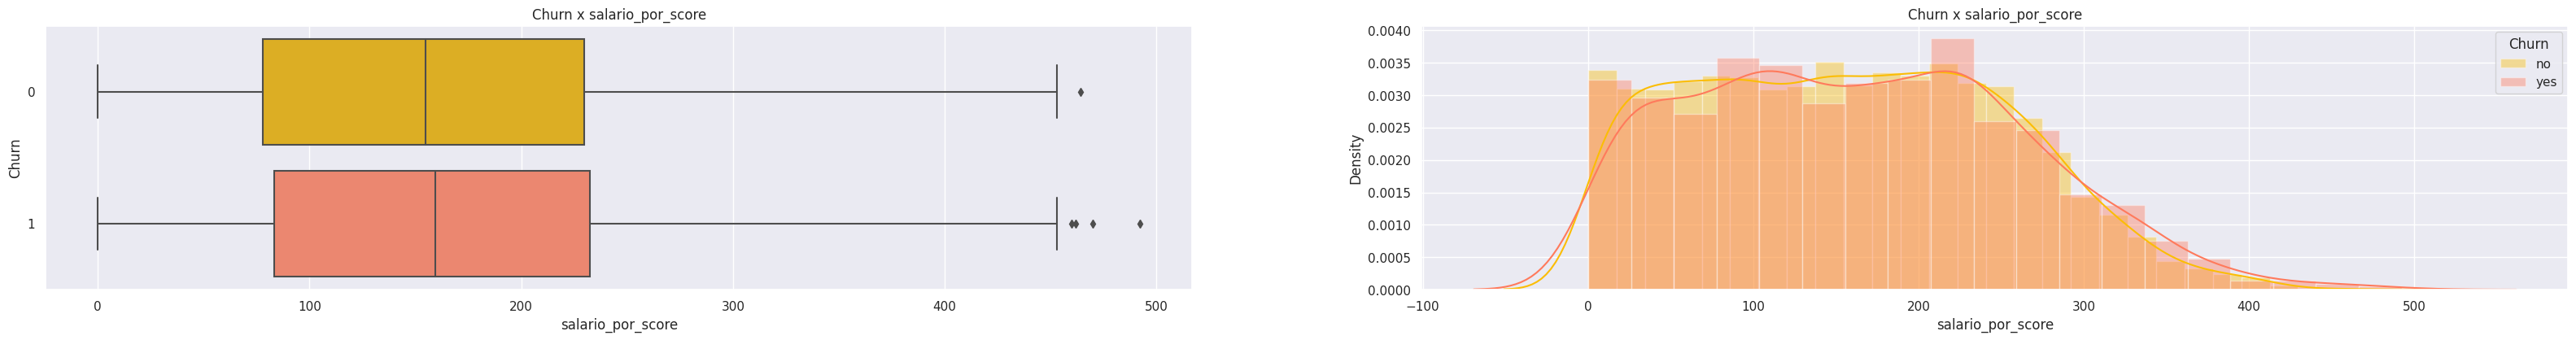

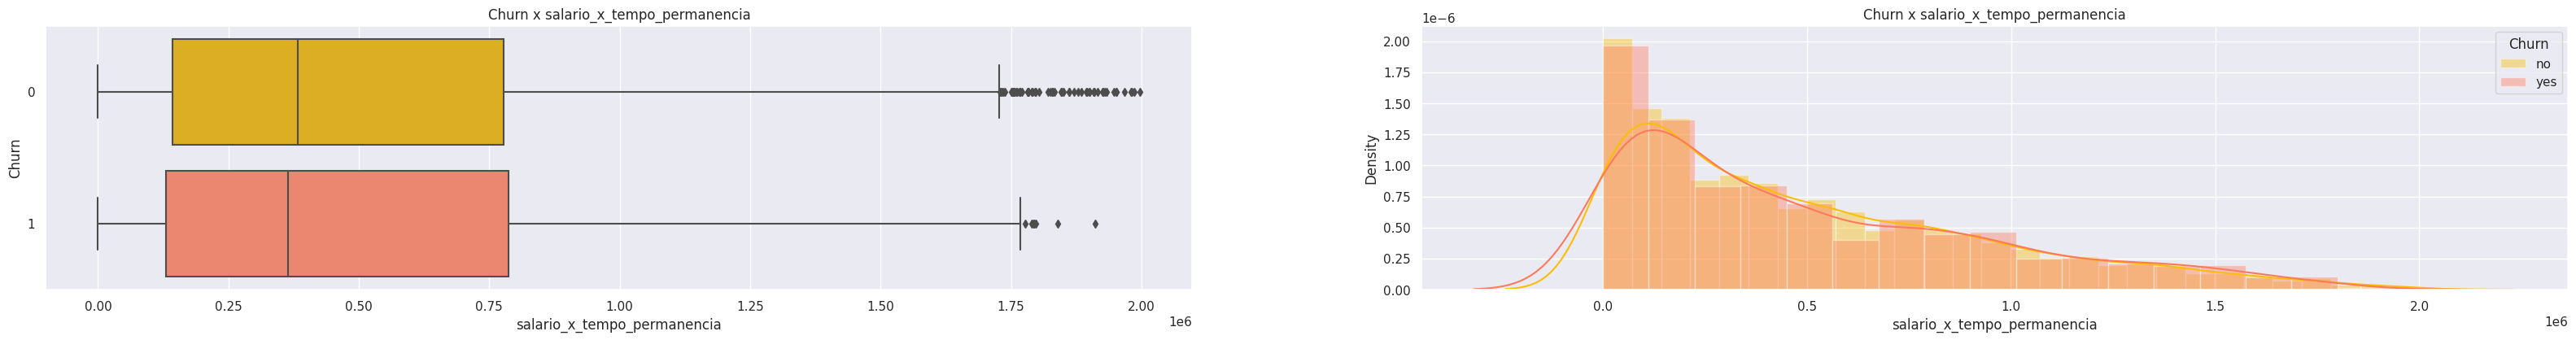

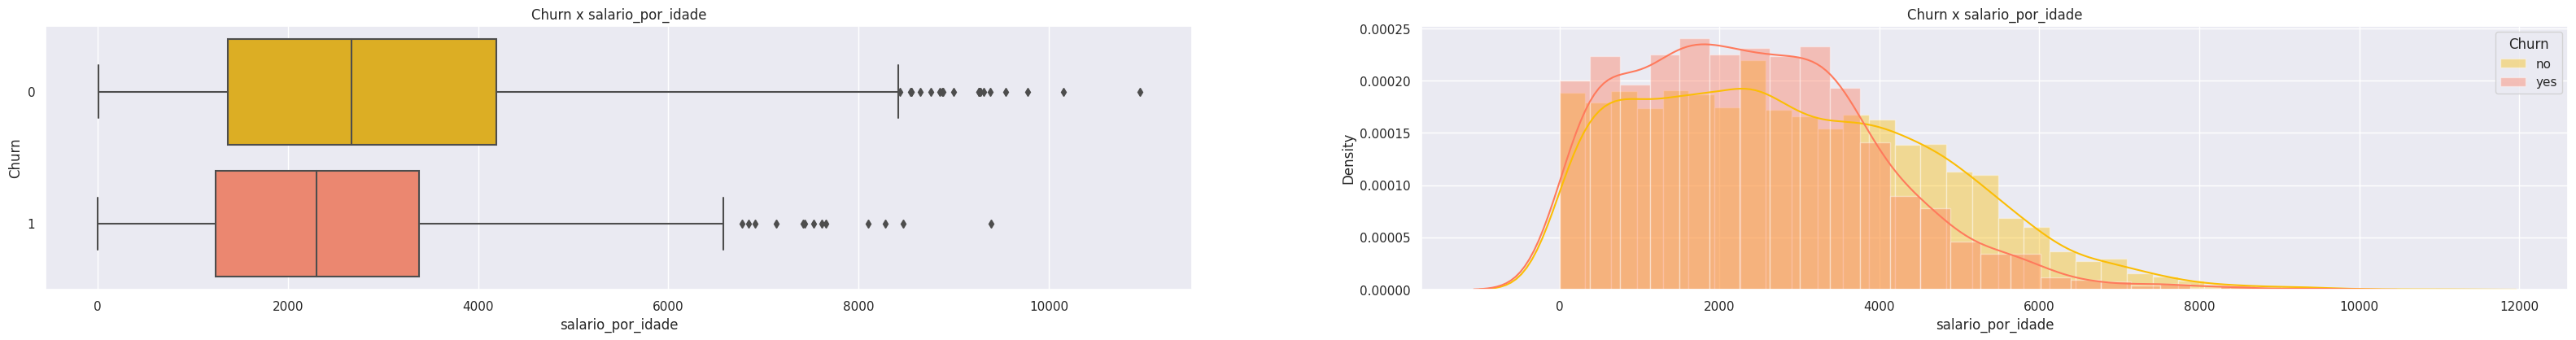

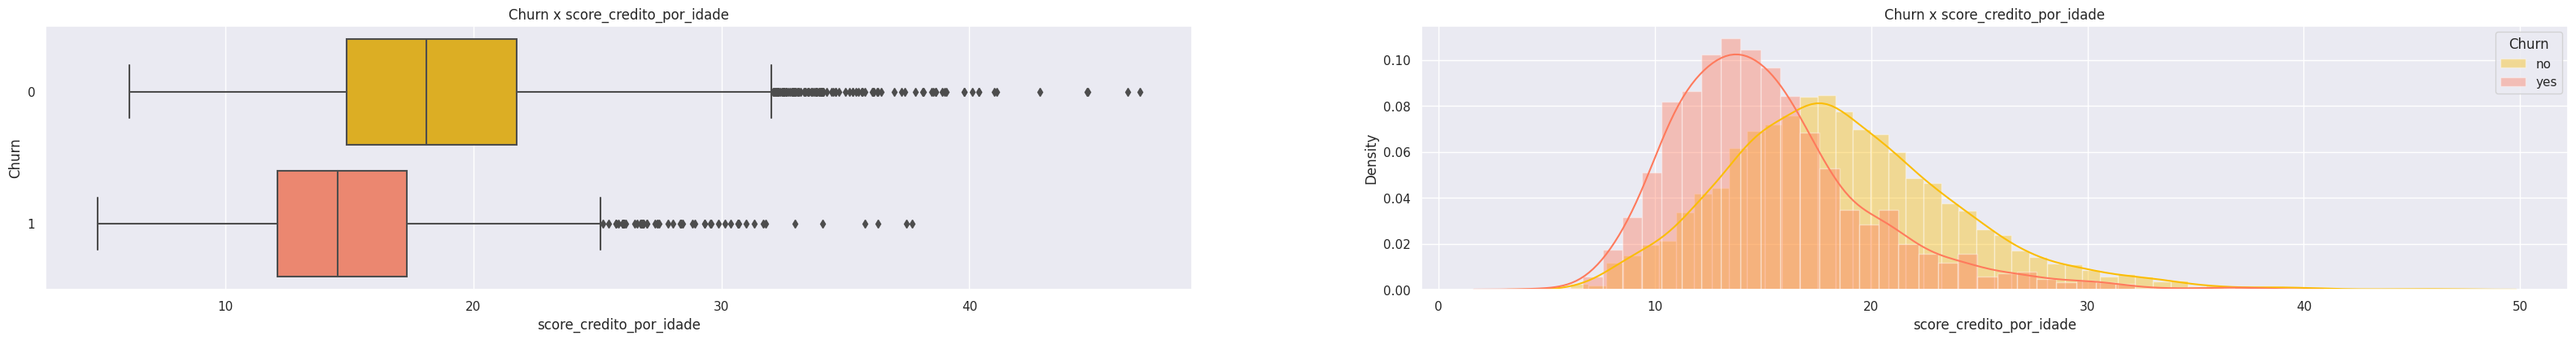

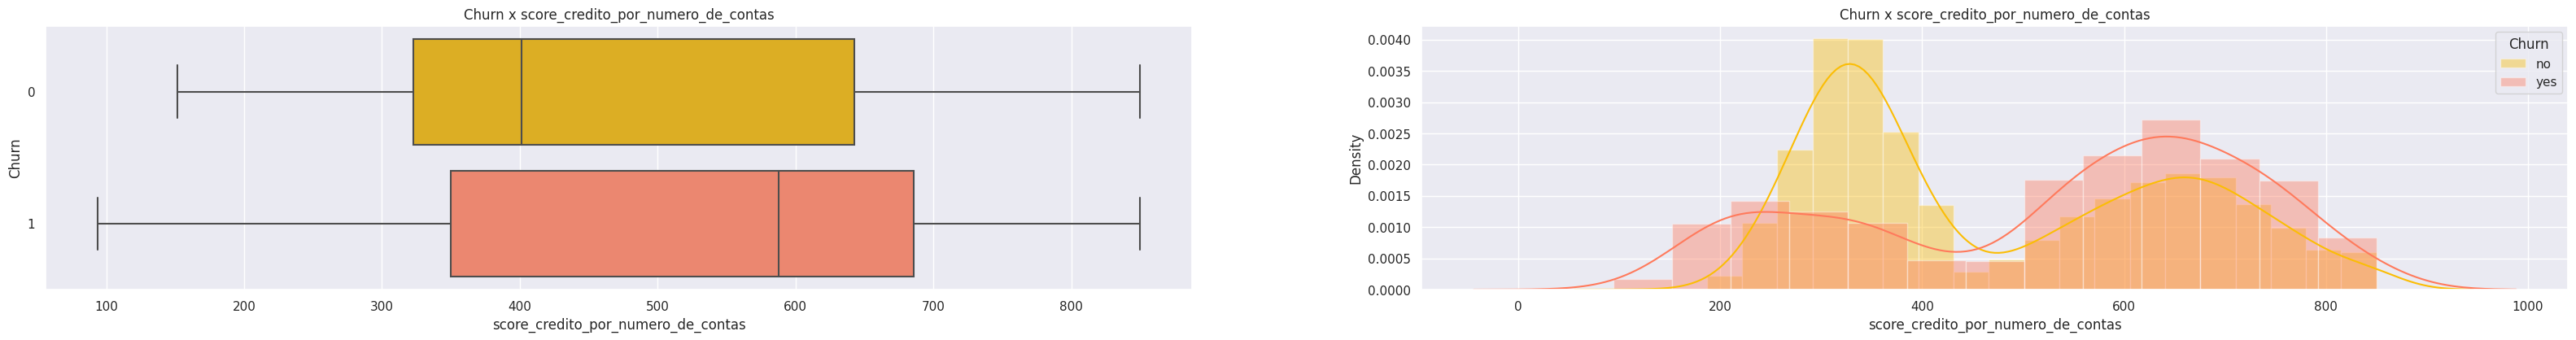

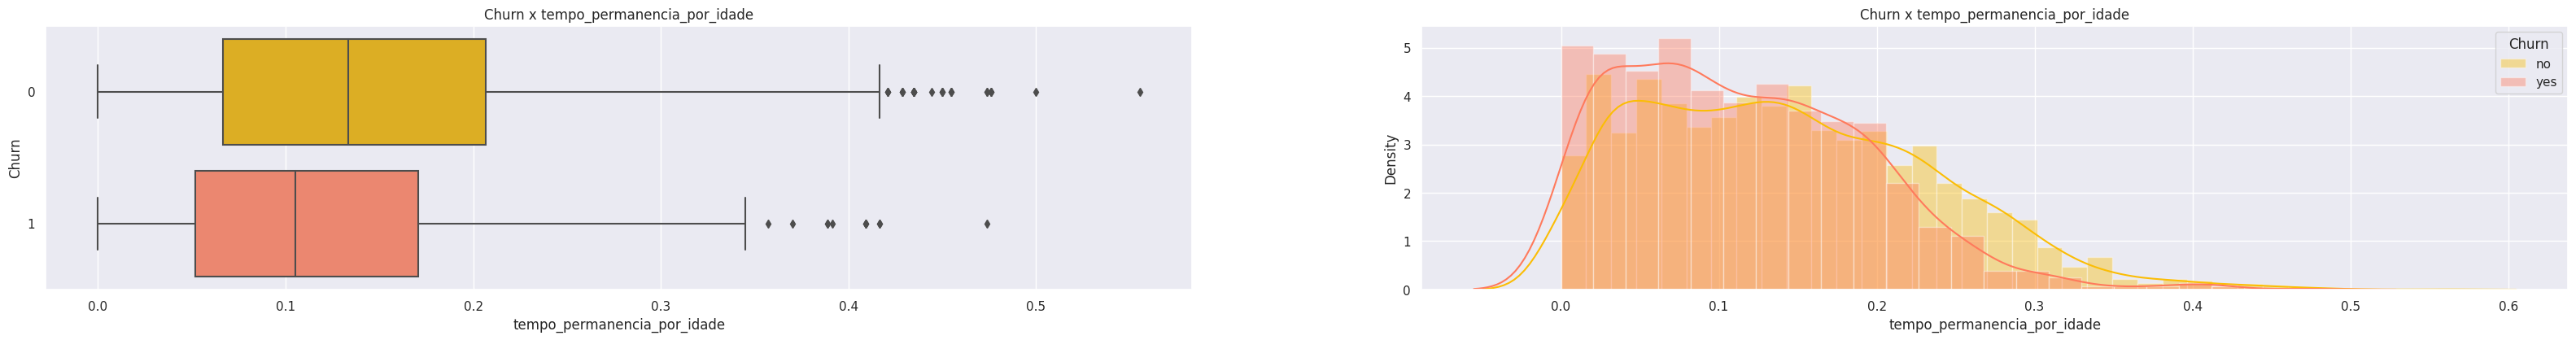

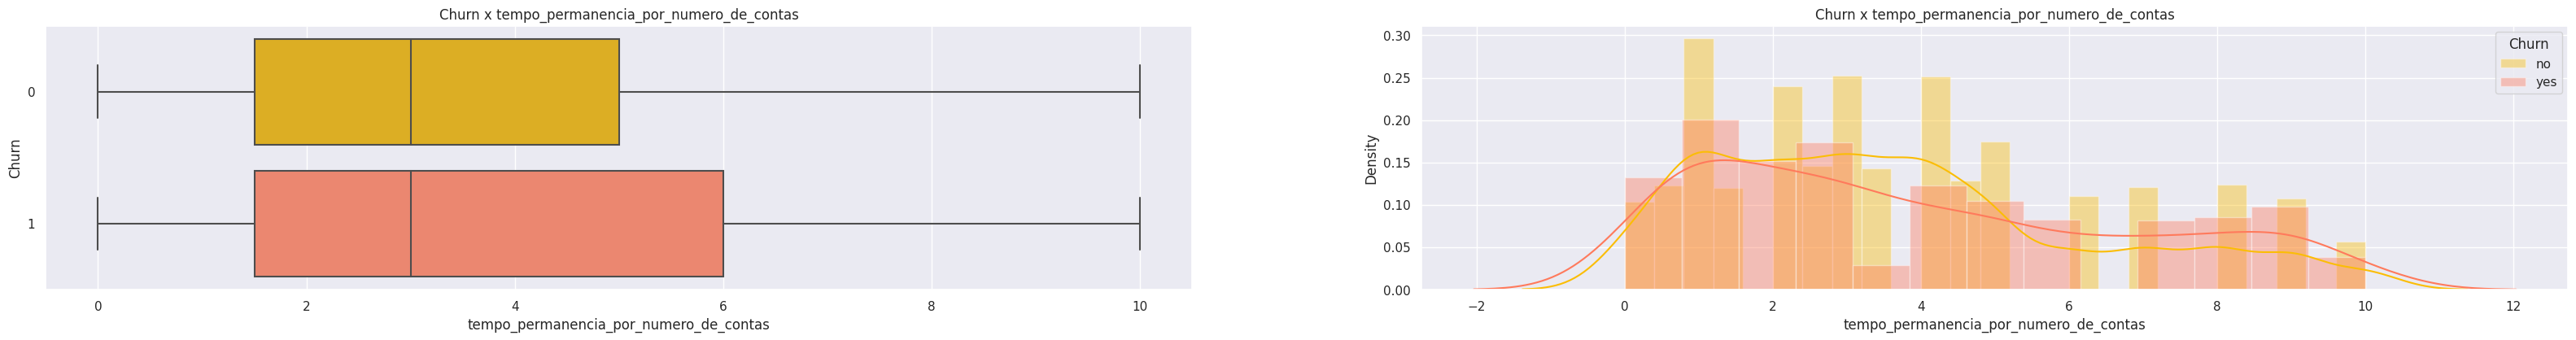

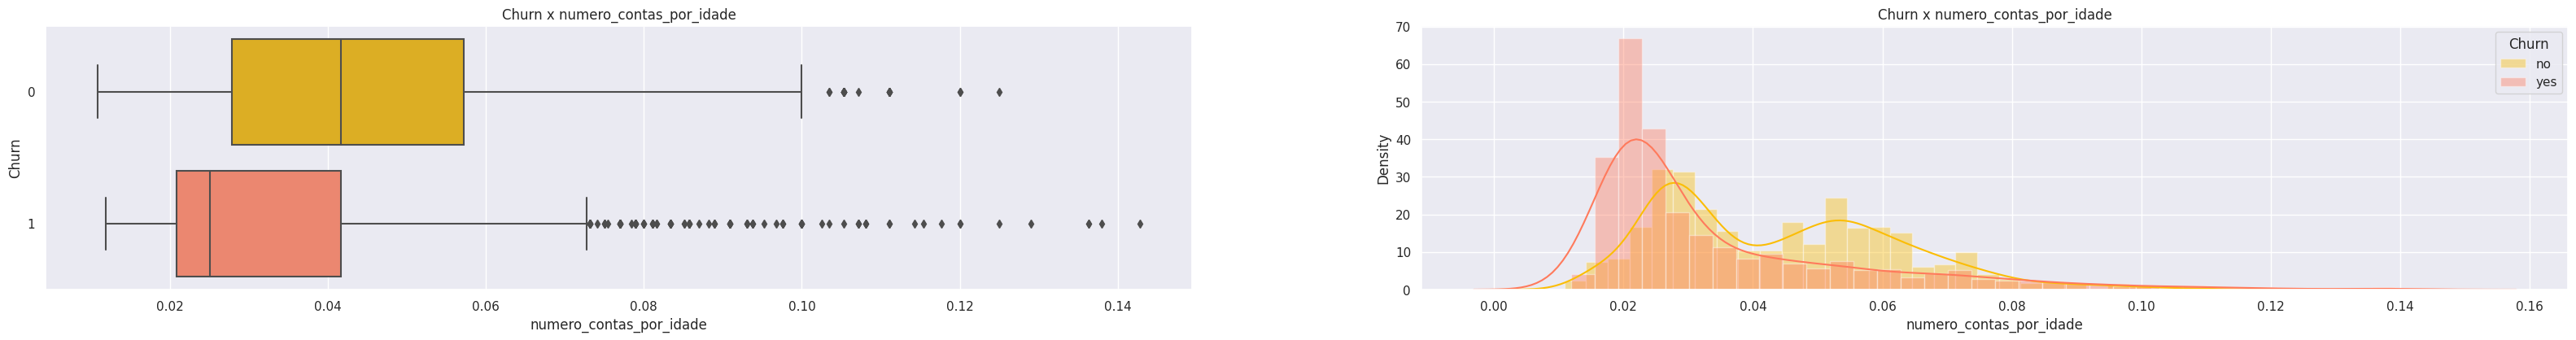

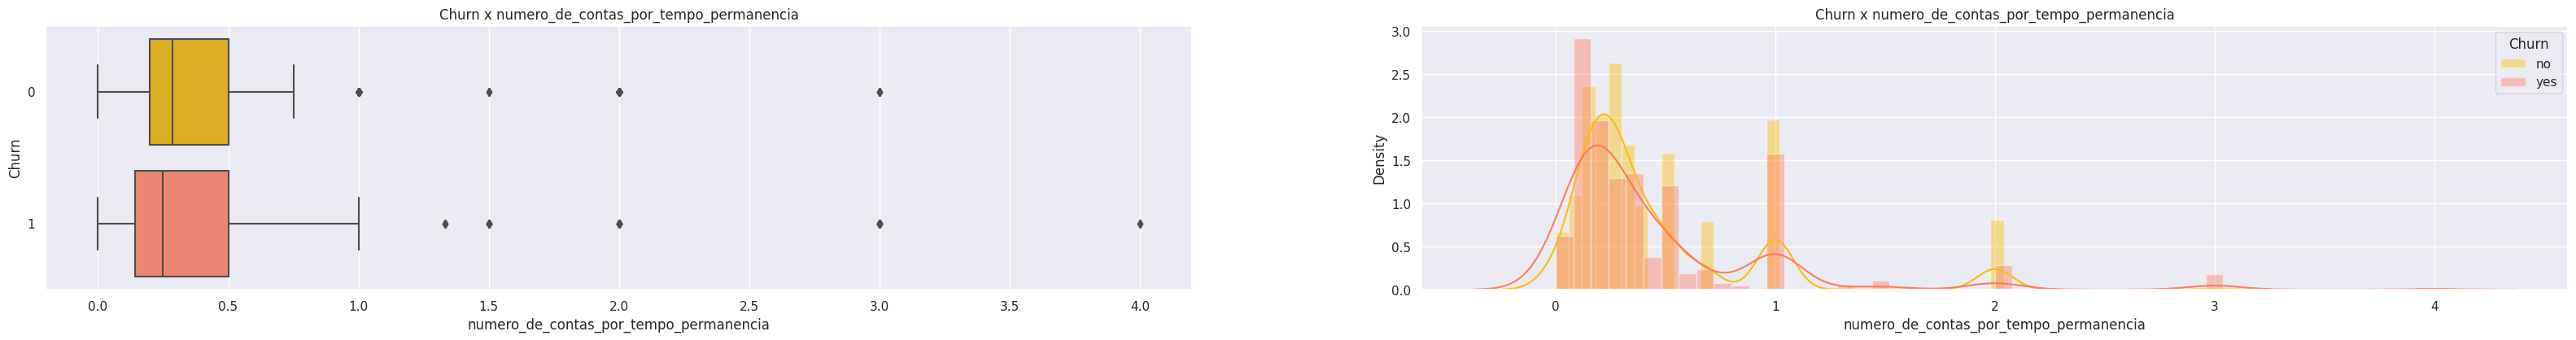

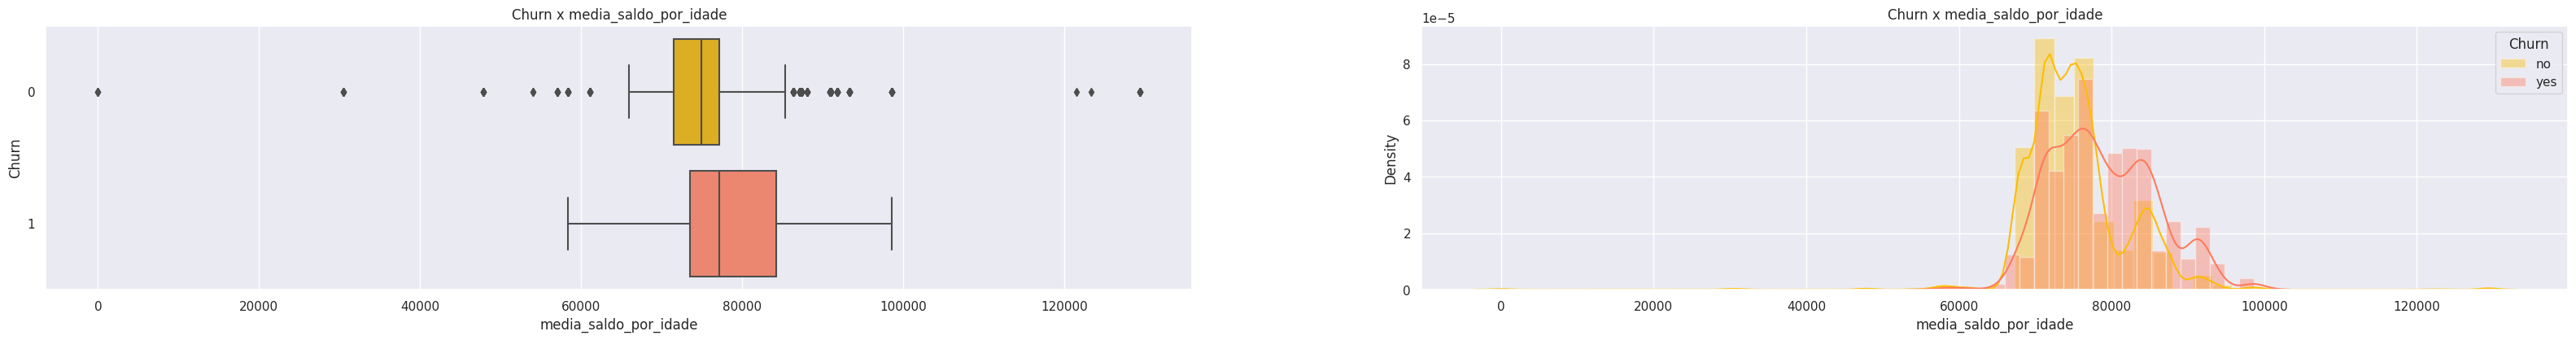

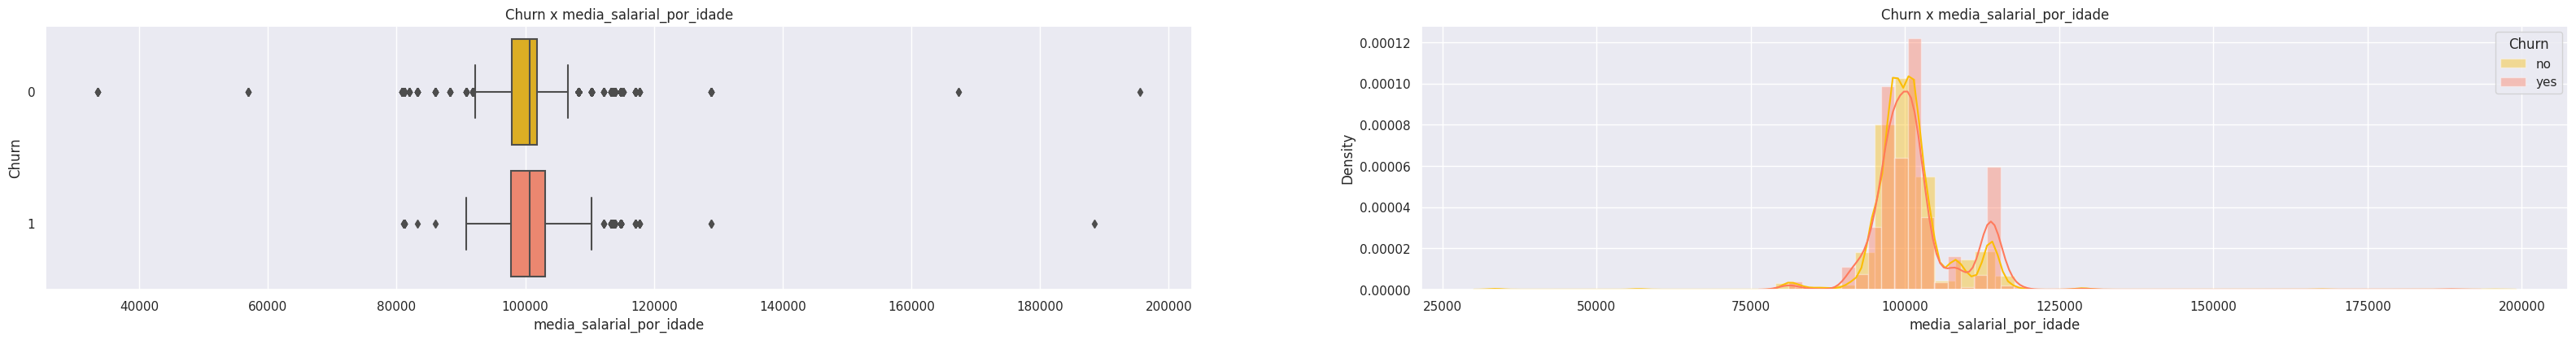

In [88]:
tuple_figsize = (40, 80)
plot_bivariate_numeric_distribuitions(X_train, list_variables, 'Churn', tuple_figsize= tuple_figsize)

#### Multivariate Analysis

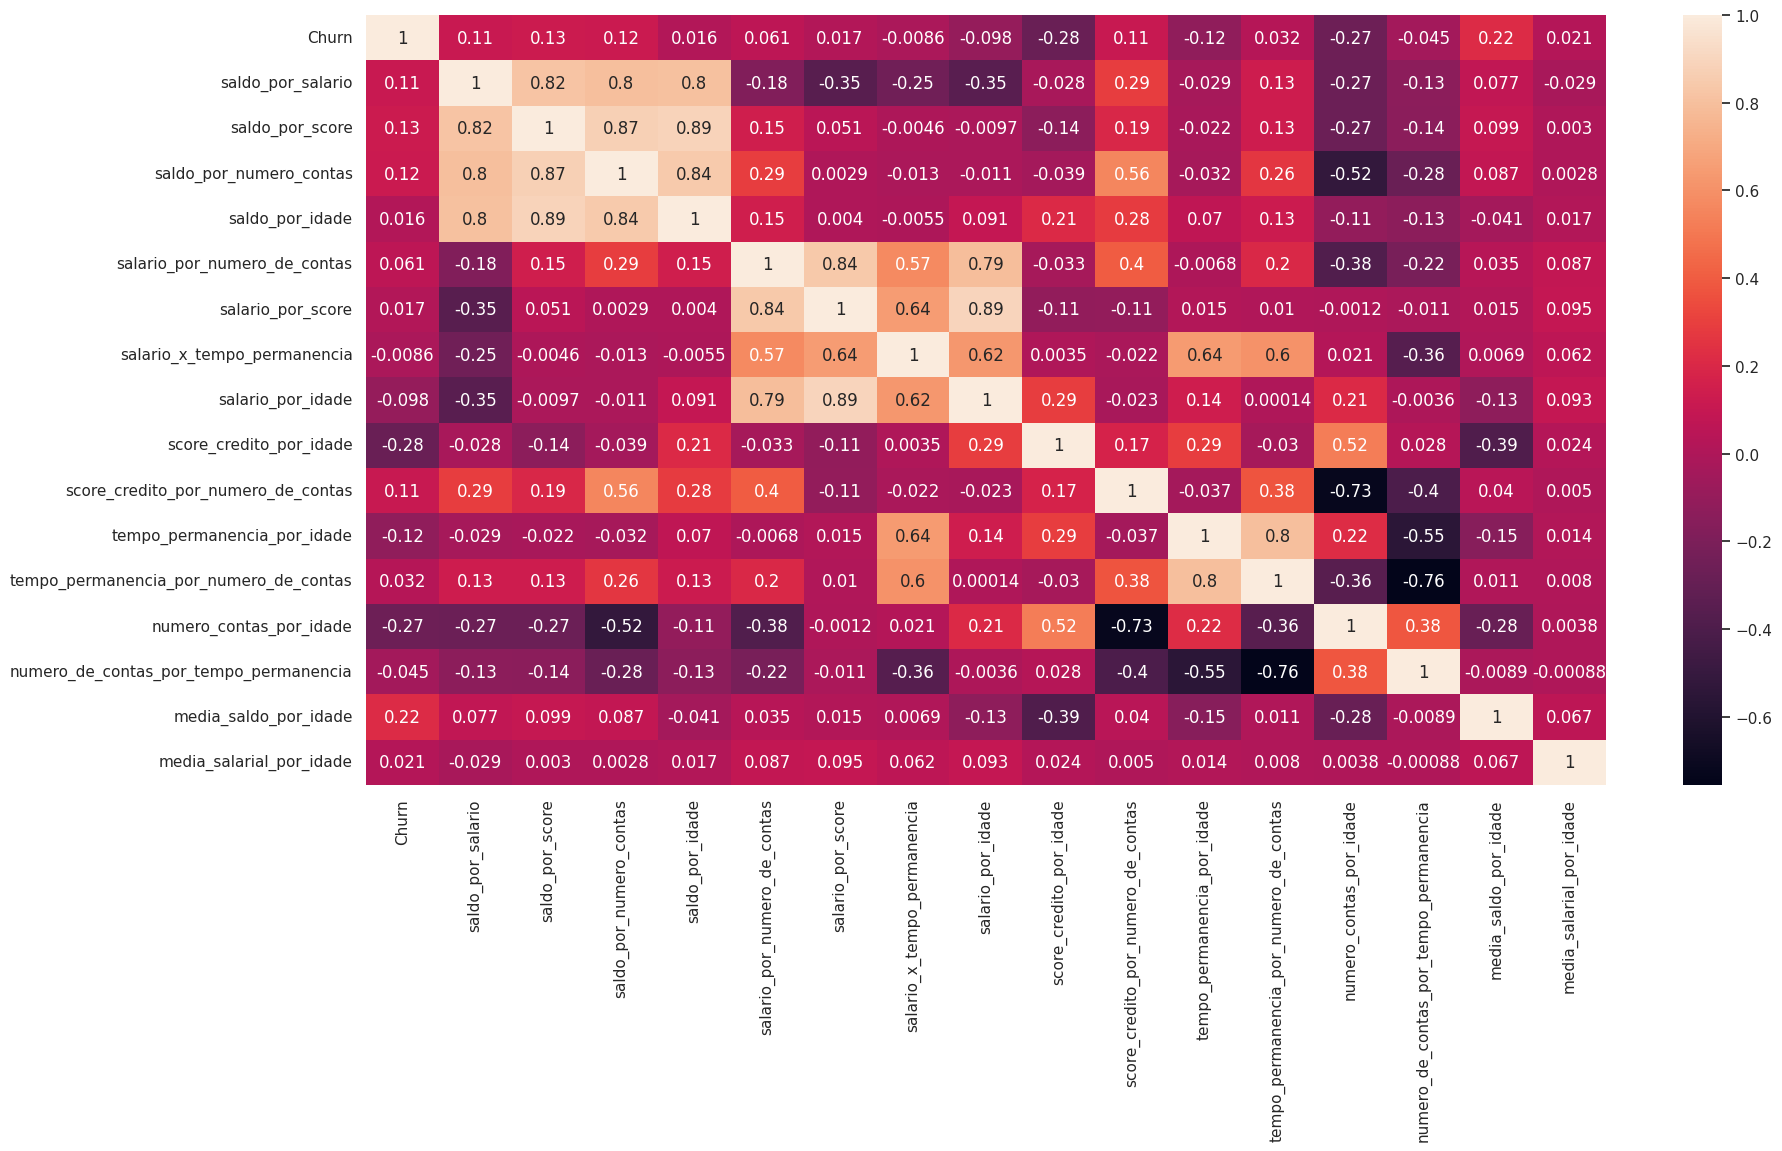

In [89]:
variables =  X_train.drop(columns= ['geografia', 'genero', 'tem_cartao_credito', 'membro_ativo', 'escala_fico', 'score_credito', 'idade', 'saldo', 'salario_estimado', 'tempo_permanencia', 'numero_de_contas'])
correlation = variables.corr(method= 'spearman')
plt.figure(figsize= (20, 10))
sns.heatmap(correlation, annot= True);

In [90]:
# Retirando variavel resposta dos dados de Teste
X_train.drop(columns= ['Churn'], inplace= True)
X_test.drop(columns= ['Churn'], inplace= True)

## Scaling I (Encoding)

In [91]:
# Troca de categorias por números de 1 a n. (geografia, gênero, escala_fico) e transformação comum para variáveis tem_cartao_credito, membro_ativo e Churn, Yes = 1 e No = 0.

### *geografia*

In [92]:
geografia_dict = {'France': 0, 'Germany': 1, 'Spain': 2}
X_train['geografia'] = X_train['geografia'].apply(lambda x: geografia_dict[x])
X_test['geografia'] = X_test['geografia'].apply(lambda x: geografia_dict[x])

### *genero*

In [93]:
genero_dict = {'Female': 0, 'Male': 1}
X_train['genero'] = X_train['genero'].apply(lambda x: genero_dict[x])
X_test['genero'] = X_test['genero'].apply(lambda x: genero_dict[x])

### *escala_fico*

In [94]:
escala_fico_dict = {'too bad': 0, 'bad': 1, 'good': 2, 'very good': 3, 'excellent': 4}
X_train['escala_fico'] = X_train['escala_fico'].apply(lambda x: escala_fico_dict[x])
X_test['escala_fico'] = X_test['escala_fico'].apply(lambda x: escala_fico_dict[x])

### *tem_cartao_credito*

In [95]:
X_train['tem_cartao_credito'] = X_train['tem_cartao_credito'].apply(lambda x: 1 if x == 'yes' else -1)
X_test['tem_cartao_credito'] = X_test['tem_cartao_credito'].apply(lambda x: 1 if x == 'yes' else -1)

### *membro_ativo*

In [96]:
X_train['membro_ativo'] = X_train['membro_ativo'].apply(lambda x: 1 if x == 'yes' else -1)
X_test['membro_ativo'] = X_test['membro_ativo'].apply(lambda x: 1 if x == 'yes' else -1)

### Response Variable (Churn)

- O encoding da variável resposta foi feita no início da análise multivariada de variáveis numéricas

In [97]:
X_train.sample(5)

score_credito  geografia  genero  idade  tempo_permanencia      saldo  numero_de_contas  tem_cartao_credito  membro_ativo  salario_estimado  escala_fico  saldo_por_salario  saldo_por_score  saldo_por_numero_contas  saldo_por_idade  salario_por_numero_de_contas  salario_por_score  salario_x_tempo_permanencia  salario_por_idade  score_credito_por_idade  score_credito_por_numero_de_contas  tempo_permanencia_por_idade  tempo_permanencia_por_numero_de_contas  numero_contas_por_idade  numero_de_contas_por_tempo_permanencia  media_saldo_por_idade  media_salarial_por_idade
3642            603          2       1     46                  2       0.00                 2                   1            -1         174478.54            1           0.000000         0.000000                    0.000         0.000000                     87239.270         289.350813                    348957.08        3793.011739                13.108696                               301.5                     0.043478                                     1.0                 0.043478                                1.000000           71206.491720              96560.392930
1008            637          0       0     33                  9  113913.53                 1                  -1             1          65316.50            1           1.744024       178.828148               113913.530      3451.925152                     65316.500         102.537677                    587848.50        1979.287879                19.303030                               637.0                     0.272727                                     9.0                 0.030303                                0.111111           74906.711233              97870.614623
3279            737          2       0     45                  2       0.00                 2                  -1             1         177695.67            2           0.000000         0.000000                    0.000         0.000000                     88847.835         241.106744                    355391.34        3948.792667                16.377778                               368.5                     0.044444                                     1.0                 0.044444                                1.000000           77182.962778             114869.238750
5619            710          0       1     33                 10  118327.17                 2                   1             1         192928.82            2           0.613320       166.657986                59163.585      3585.671818                     96464.410         271.730732                   1929288.20        5846.327879                21.515152                               355.0                     0.303030                                     5.0                 0.060606                                0.200000           74906.711233              97870.614623
6126            647          2       0     29                  2       0.00                 2                   1            -1         179032.68            1           0.000000         0.000000                    0.000         0.000000                     89516.340         276.712025                    358065.36        6173.540690                22.310345                               323.5                     0.068966                                     1.0                 0.068966                                1.000000           68546.943966             101341.671139

In [98]:
X_test.sample(5)

score_credito  geografia  genero  idade  tempo_permanencia      saldo  numero_de_contas  tem_cartao_credito  membro_ativo  salario_estimado  escala_fico  saldo_por_salario  saldo_por_score  saldo_por_numero_contas  saldo_por_idade  salario_por_numero_de_contas  salario_por_score  salario_x_tempo_permanencia  salario_por_idade  score_credito_por_idade  score_credito_por_numero_de_contas  tempo_permanencia_por_idade  tempo_permanencia_por_numero_de_contas  numero_contas_por_idade  numero_de_contas_por_tempo_permanencia  media_saldo_por_idade  media_salarial_por_idade
1969            711          0       1     36                  9  137688.71                 1                   1             1          46884.10            2           2.936789       193.655007                137688.71      3824.686389                      46884.10          65.941069                    421956.90        1302.336111                19.750000                               711.0                     0.250000                                     9.0                 0.027778                                0.111111           75498.742448              97711.519790
2428            677          2       1     40                  7   95312.80                 1                   1             1          62944.75            2           1.514230       140.787001                 95312.80      2382.820000                      62944.75          92.975997                    440613.25        1573.618750                16.925000                               677.0                     0.175000                                     7.0                 0.025000                                0.142857           74309.505168              99975.918322
1870            743          2       1     45                  7  157332.26                 1                   1            -1         125424.42            3           1.254399       211.752705                157332.26      3496.272444                     125424.42         168.808102                    877970.94        2787.209333                16.511111                               743.0                     0.155556                                     7.0                 0.022222                                0.142857           84320.316118              98072.717294
1168            633          0       1     29                  7       0.00                 1                   1             1         130224.73            1           0.000000         0.000000                     0.00         0.000000                     130224.73         205.726272                    911573.11        4490.507931                21.827586                               633.0                     0.241379                                     7.0                 0.034483                                0.142857           69937.144685             100770.840090
12              850          0       1     47                  6       0.00                 1                   1            -1         187391.02            4           0.000000         0.000000                     0.00         0.000000                     187391.02         220.460024                   1124346.12        3987.042979                18.085106                               850.0                     0.127660                                     6.0                 0.021277                                0.166667           67815.590755             109098.215849

## Scaling II (Normalization) 

In [99]:
numeric_attributes_train_data = X_train.select_dtypes(include= ['int64', 'float64'])
numeric_attributes_train_data.drop(columns= ['geografia', 'genero', 'escala_fico', 'tem_cartao_credito', 'membro_ativo'], inplace= True)
pd.options.display.max_rows = numeric_attributes_train_data.shape[1]

In [100]:
# Estatística descritiva de todo conjunto de dados antes da criação de novas features
numeric_descriptive_statistical(numeric_attributes)

Variáveis  Mínimo     Máximo      Range  Valores Únicos          Média     Mediana  Desv. Padrão  Assimetria   Curtose
0      score_credito  350.00     850.00     500.00           460.0     650.528800     652.000     96.648466   -0.071607 -0.425726
1              idade   18.00      92.00      74.00            70.0      38.921800      37.000     10.487282    1.011320  1.395347
2  tempo_permanencia    0.00      10.00      10.00            11.0       5.012800       5.000      2.892030    0.010991 -1.165225
3              saldo    0.00  250898.09  250898.09          6382.0   76485.889288   97198.540  62394.285254   -0.141109 -1.489412
4   numero_de_contas    1.00       4.00       3.00             4.0       1.530200       1.000      0.581625    0.745568  0.582981
5   salario_estimado   11.58  199992.48  199980.90          9999.0  100090.239881  100193.915  57507.617221    0.002085 -1.181518

In [101]:
# Estatística descritiva dos dados de treino depois da criação de novas features
numeric_descriptive_statistical(numeric_attributes_train_data)

Variáveis        Mínimo        Máximo         Range  Valores Únicos          Média        Mediana   Desv. Padrão  Assimetria      Curtose
0                            score_credito    350.000000  8.500000e+02  5.000000e+02           447.0     651.842985     652.000000      96.162162   -0.069449    -0.425215
1                                    idade     18.000000  9.200000e+01  7.400000e+01            67.0      38.888507      37.000000      10.499166    0.986661     1.302380
2                        tempo_permanencia      0.000000  1.000000e+01  1.000000e+01            11.0       4.972985       5.000000       2.891473    0.025770    -1.163198
3                                    saldo      0.000000  2.508981e+05  2.508981e+05          4252.0   76113.215807   96371.980000   62567.992960   -0.125078    -1.490752
4                         numero_de_contas      1.000000  4.000000e+00  3.000000e+00             4.0       1.524627       1.000000       0.579879    0.751607     0.571741
5                         salario_estimado     90.070000  1.999707e+05  1.998807e+05          6700.0  101056.390425  100996.805000   57756.906317   -0.014908    -1.185733
6                        saldo_por_salario      0.000000  1.326103e+03  1.326103e+03          4252.0       2.726575       0.737389      21.679717   39.270569  2149.290952
7                          saldo_por_score      0.000000  4.530323e+02  4.530323e+02          4252.0     119.414662     142.383927     101.209998    0.061678    -1.219427
8                  saldo_por_numero_contas      0.000000  2.383876e+05  2.383876e+05          4252.0   62743.512279   61226.835000   57009.239647    0.281820    -1.225314
9                          saldo_por_idade      0.000000  1.021115e+04  1.021115e+04          4252.0    2077.173982    2290.794192    1853.556648    0.362958    -0.614568
10            salario_por_numero_de_contas     45.035000  1.999707e+05  1.999257e+05          6700.0   75705.876084   67031.995000   52438.427869    0.653309    -0.468290
11                       salario_por_score      0.135592  4.923463e+02  4.922107e+02          6700.0     158.675946     155.741605      95.212657    0.242066    -0.724626
12             salario_x_tempo_permanencia      0.000000  1.997757e+06  1.997757e+06          6418.0  505315.747833  378175.735000  444066.874008    0.957310     0.155187
13                       salario_por_idade      1.555085  1.096234e+04  1.096079e+04          6700.0    2778.558469    2574.392669    1795.449021    0.560625    -0.109629
14                 score_credito_por_idade      4.857143  4.688889e+01  4.203175e+01          4667.0      17.939301      17.333333       5.418849    0.765454     1.032472
15      score_credito_por_numero_de_contas     94.000000  8.500000e+02  7.560000e+02           969.0     488.698943     457.500000     183.015776    0.203316    -1.325916
16             tempo_permanencia_por_idade      0.000000  5.555556e-01  5.555556e-01           398.0       0.137039       0.128205       0.089715    0.588008    -0.010844
17  tempo_permanencia_por_numero_de_contas      0.000000  1.000000e+01  1.000000e+01            28.0       3.722662       3.000000       2.629254    0.687224    -0.416212
18                 numero_contas_por_idade      0.010870  1.428571e-01  1.319876e-01           154.0       0.042105       0.037037       0.019607    0.839562     0.450145
19  numero_de_contas_por_tempo_permanencia      0.000000  4.000000e+00  4.000000e+00            28.0       0.452156       0.285714       0.470991    2.430012     7.206003
20                   media_saldo_por_idade      0.000000  1.294434e+05  1.294434e+05            67.0   76113.215807   74906.711233    6798.162360    0.278426    12.450749
21                media_salarial_por_idade  33588.314000  1.955640e+05  1.619757e+05            67.0  101056.390425  100668.379424    6569.640394    0.606977    24.089309

### Standardization (or  X-score Normalization)

- Na Análise Univariada é possível verificar que não temos nenhuma distribuição normal nas variáveis numéricas, logo será descartado o processo de normalização.

### Normalization (or Rescaling)

In [102]:
robust_scaler = RobustScaler() #rescala para variáveis numéricas com distribuições não gaussianas que possuem outliers 
#(idade, numero_de_contas, saldo_por_salario, salario_x_tempo_permanencia, salario_por_idade, score_credito_por_idade, tempo_permanencia_por_idade, numero_contas_por_idade, numero_de_contas_por_tempo_permanencia, media_saldo_por_idade, media_salarial_por_idade)
min_max_scaler = MinMaxScaler() #rescala para variáveis numéricas com distribuições não gaussianas que não possuem outliers 
#(score_credito, tempo_permanencia, saldo,  salario_estimado, 'saldo_por_score', 'saldo_por_numero_contas', 'saldo_por_idade', 'salario_por_idade', 'salario_por_numero_de_contas', 'salario_por_score', 'score_credito_por_numero_de_contas', 'tempo_permanencia_por_numero_de_contas')

# Neste ciclo, meu critério de normalização é a análise exploratória e valor de curtose (valores < - 0.3, considero baixa chance de presença outlier)

#### *idade*

In [103]:
X_train['idade'] = robust_scaler.fit_transform(X_train[['idade']].values)
X_test['idade'] = robust_scaler.transform(X_test[['idade']].values)

#### *numero_de_conta*

In [104]:
X_train['numero_de_contas'] = robust_scaler.fit_transform(X_train[['numero_de_contas']].values)
X_test['numero_de_contas'] = robust_scaler.transform(X_test[['numero_de_contas']].values)

#### *saldo_por_salario*

In [105]:
X_train['saldo_por_salario'] = robust_scaler.fit_transform(X_train[['saldo_por_salario']].values)
X_test['saldo_por_salario'] = robust_scaler.transform(X_test[['saldo_por_salario']].values)

#### salario_x_tempo_permanencia

In [106]:
X_train['salario_x_tempo_permanencia'] = robust_scaler.fit_transform(X_train[['salario_x_tempo_permanencia']].values)
X_test['salario_x_tempo_permanencia'] = robust_scaler.transform(X_test[['salario_x_tempo_permanencia']].values)

#### salario_por_idade

In [107]:
X_train['salario_por_idade'] = robust_scaler.fit_transform(X_train[['salario_por_idade']].values)
X_test['salario_por_idade'] = robust_scaler.transform(X_test[['salario_por_idade']].values)

#### *score_credito_por_idade*

In [108]:
X_train['score_credito_por_idade'] = robust_scaler.fit_transform(X_train[['score_credito_por_idade']].values)
X_test['score_credito_por_idade'] = robust_scaler.transform(X_test[['score_credito_por_idade']].values)

#### *tempo_permanencia_por_idade*

In [109]:
X_train['tempo_permanencia_por_idade'] = robust_scaler.fit_transform(X_train[['tempo_permanencia_por_idade']].values)
X_test['tempo_permanencia_por_idade'] = robust_scaler.transform(X_test[['tempo_permanencia_por_idade']].values)

#### *numero_contas_por_idade*

In [110]:
X_train['numero_contas_por_idade'] = robust_scaler.fit_transform(X_train[['numero_contas_por_idade']].values)
X_test['numero_contas_por_idade'] = robust_scaler.transform(X_test[['numero_contas_por_idade']].values)

#### *numero_de_contas_por_tempo_permanencia*

In [111]:
X_train['numero_de_contas_por_tempo_permanencia'] = robust_scaler.fit_transform(X_train[['numero_de_contas_por_tempo_permanencia']].values)
X_test['numero_de_contas_por_tempo_permanencia'] = robust_scaler.transform(X_test[['numero_de_contas_por_tempo_permanencia']].values)

#### *media_saldo_por_idade*

In [112]:
X_train['media_saldo_por_idade'] = robust_scaler.fit_transform(X_train[['media_saldo_por_idade']].values)
X_test['media_saldo_por_idade'] = robust_scaler.transform(X_test[['media_saldo_por_idade']].values)

#### *media_salarial_por_idade*

In [113]:
X_train['media_salarial_por_idade'] = robust_scaler.fit_transform(X_train[['media_salarial_por_idade']].values)
X_test['media_salarial_por_idade'] = robust_scaler.transform(X_test[['media_salarial_por_idade']].values)

#### *score_credito*

In [114]:
X_train['score_credito'] = min_max_scaler.fit_transform(X_train[['score_credito']].values)
X_test['score_credito'] = min_max_scaler.transform(X_test[['score_credito']].values)

#### *tempo_permanencia*

In [115]:
X_train['tempo_permanencia'] = min_max_scaler.fit_transform(X_train[['tempo_permanencia']].values)
X_test['tempo_permanencia'] = min_max_scaler.transform(X_test[['tempo_permanencia']].values)

#### *saldo*

In [116]:
X_train['saldo'] = min_max_scaler.fit_transform(X_train[['saldo']].values)
X_test['saldo'] = min_max_scaler.transform(X_test[['saldo']].values)

#### *salario_estimado*

In [117]:
X_train['salario_estimado'] = min_max_scaler.fit_transform(X_train[['salario_estimado']].values)
X_test['salario_estimado'] = min_max_scaler.transform(X_test[['salario_estimado']].values)

#### *saldo_por_score*

In [118]:
X_train['saldo_por_score'] = min_max_scaler.fit_transform(X_train[['saldo_por_score']].values)
X_test['saldo_por_score'] = min_max_scaler.transform(X_test[['saldo_por_score']].values)

#### *saldo_por_numero_contas*

In [119]:
X_train['saldo_por_numero_contas'] = min_max_scaler.fit_transform(X_train[['saldo_por_numero_contas']].values)
X_test['saldo_por_numero_contas'] = min_max_scaler.transform(X_test[['saldo_por_numero_contas']].values)

#### *saldo_por_idade*

In [120]:
X_train['saldo_por_idade'] = min_max_scaler.fit_transform(X_train[['saldo_por_idade']].values)
X_test['saldo_por_idade'] = min_max_scaler.transform(X_test[['saldo_por_idade']].values)

#### *salario_por_idade*

In [121]:
X_train['salario_por_idade'] = min_max_scaler.fit_transform(X_train[['salario_por_idade']].values)
X_test['salario_por_idade'] = min_max_scaler.transform(X_test[['salario_por_idade']].values)

#### *salario_por_numero_de_contas*

In [122]:
X_train['salario_por_numero_de_contas'] = min_max_scaler.fit_transform(X_train[['salario_por_numero_de_contas']].values)
X_test['salario_por_numero_de_contas'] = min_max_scaler.transform(X_test[['salario_por_numero_de_contas']].values)

#### *salario_por_score*

In [123]:
X_train['salario_por_score'] = min_max_scaler.fit_transform(X_train[['salario_por_score']].values)
X_test['salario_por_score'] = min_max_scaler.transform(X_test[['salario_por_score']].values)

#### *score_credito_por_numero_de_contas* 

In [124]:
X_train['score_credito_por_numero_de_contas'] = min_max_scaler.fit_transform(X_train[['score_credito_por_numero_de_contas']].values)
X_test['score_credito_por_numero_de_contas'] = min_max_scaler.transform(X_test[['score_credito_por_numero_de_contas']].values)

#### *tempo_permanencia_por_numero_de_contas*

In [125]:
X_train['tempo_permanencia_por_numero_de_contas'] = min_max_scaler.fit_transform(X_train[['tempo_permanencia_por_numero_de_contas']].values)
X_test['tempo_permanencia_por_numero_de_contas'] = min_max_scaler.transform(X_test[['tempo_permanencia_por_numero_de_contas']].values)

In [126]:
X_train.sample(5)

score_credito  geografia  genero     idade  tempo_permanencia     saldo  numero_de_contas  tem_cartao_credito  membro_ativo  salario_estimado  escala_fico  saldo_por_salario  saldo_por_score  saldo_por_numero_contas  saldo_por_idade  salario_por_numero_de_contas  salario_por_score  salario_x_tempo_permanencia  salario_por_idade  score_credito_por_idade  score_credito_por_numero_de_contas  tempo_permanencia_por_idade  tempo_permanencia_por_numero_de_contas  numero_contas_por_idade  numero_de_contas_por_tempo_permanencia  media_saldo_por_idade  media_salarial_por_idade
553           0.534          2       1  2.000000                0.7  0.362978               0.0                   1             1          0.509052            1           0.105860         0.325809                 0.382027         0.146209                      0.509163           0.335061                     0.524369           0.152174                -1.039796                            0.691799                    -0.098781                                0.700000                -0.706011                               -0.428571               2.415217                  3.176359
5041          0.858          2       0  0.083333                0.7  0.000000               1.0                   1             1          0.692677            3          -0.497632         0.000000                 0.000000         0.000000                      0.346261           0.361048                     0.926880           0.332486                 0.456141                            0.390873                     0.411290                                0.350000                 0.533333                                0.000000              -0.194016                 -0.726099
3861          0.442          0       0  0.416667                0.4  0.433743               2.0                   1            -1          0.277508            0           0.824245         0.420692                 0.152169         0.253750                      0.092407           0.197405                    -0.244309           0.120545                -0.538452                            0.127425                    -0.242102                                0.133333                 1.176190                                1.392857               0.315101                 -0.730233
6069          0.654          0       0 -0.833333                0.2  0.000000               1.0                  -1             1          0.573321            2          -0.497632         0.000000                 0.000000         0.000000                      0.286596           0.343892                    -0.233127           0.387388                 1.115010                            0.323413                    -0.397525                                0.100000                 1.266667                                2.142857              -0.916170                  0.260750
2391          1.000          1       0 -0.500000                0.1  0.518496               1.0                   1             1          0.021894            4          19.159269         0.337827                 0.272853         0.410966                      0.010944           0.010400                    -0.585480           0.013002                 1.452835                            0.437831                    -0.704611                                0.050000                 0.939785                                5.142857               0.312311                  0.000000

In [127]:
X_test.sample(5)

score_credito  geografia  genero     idade  tempo_permanencia     saldo  numero_de_contas  tem_cartao_credito  membro_ativo  salario_estimado  escala_fico  saldo_por_salario  saldo_por_score  saldo_por_numero_contas  saldo_por_idade  salario_por_numero_de_contas  salario_por_score  salario_x_tempo_permanencia  salario_por_idade  score_credito_por_idade  score_credito_por_numero_de_contas  tempo_permanencia_por_idade  tempo_permanencia_por_numero_de_contas  numero_contas_por_idade  numero_de_contas_por_tempo_permanencia  media_saldo_por_idade  media_salarial_por_idade
1858          0.230          2       0 -0.333333                0.6  0.000000               1.0                   1             1          0.477339            0          -0.497632         0.000000                 0.000000         0.000000                      0.238616           0.416982                     0.305235           0.263887                -0.467053                            0.183201                     0.393721                                     0.3                 0.806061                                0.142857               0.649696                  0.459867
2703          1.000          1       1  0.250000                0.4  0.661951               1.0                  -1             1          0.221713            4           2.026380         0.431295                 0.348345         0.406620                      0.110831           0.105863                    -0.314197           0.101142                 0.564174                            0.437831                    -0.207131                                     0.2                 0.443333                                0.642857              -0.085377                 -0.174627
1018          0.720          2       0 -0.666667                0.3  0.476967               0.0                   1            -1          0.940223            2          -0.068108         0.372048                 0.501998         0.404123                      0.940236           0.537747                     0.291231           0.591379                 1.029835                            0.814815                    -0.181808                                     0.3                -0.087356                                0.142857              -0.710453                  0.025839
1068          0.466          2       0  0.250000                0.4  0.000000               1.0                   1            -1          0.570359            1          -0.497632         0.000000                 0.000000         0.000000                      0.285115           0.397321                     0.122512           0.260090                -0.397322                            0.261243                    -0.207131                                     0.2                 0.443333                                0.642857              -0.085377                 -0.174627
1101          0.654          0       1  0.416667                0.5  0.396895               0.0                   1            -1          0.104652            2           2.701267         0.324679                 0.417724         0.232193                      0.104854           0.062769                    -0.427914           0.045493                -0.174911                            0.771164                    -0.067250                                     0.5                -0.452381                               -0.257143               0.167203                 -1.605075

## Balancing Response Variable *only Train Data

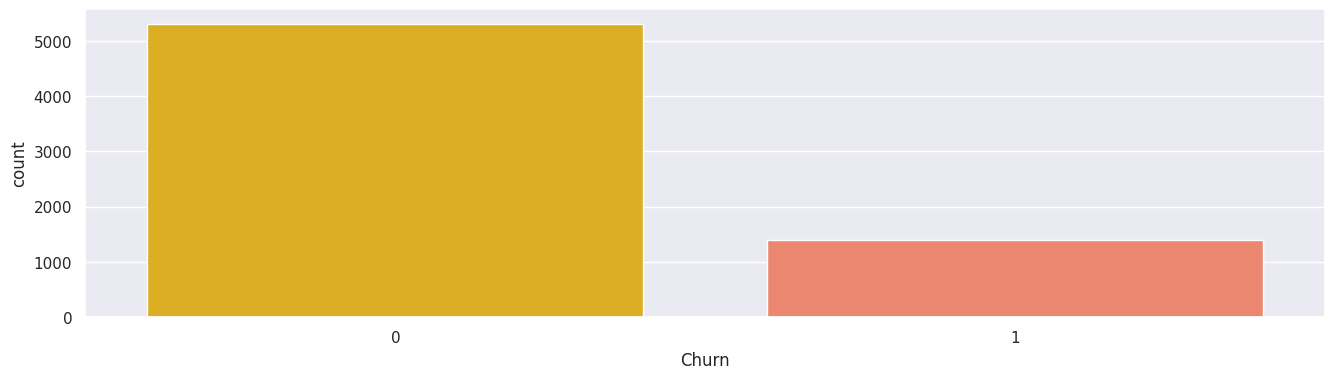

In [128]:
# Visualizando proporção da variável resposta
sns.countplot(x= y_train);

- Como a variável resposta está desbalanceada, aplico uma técnica (algoritmo) que irá balancear os dados e evitar enviesamento do modelo.

In [129]:
# Over-Sampling na variável resposta dos dados de treino 
X_train, y_train = SMOTE().fit_resample(X_train, y_train)

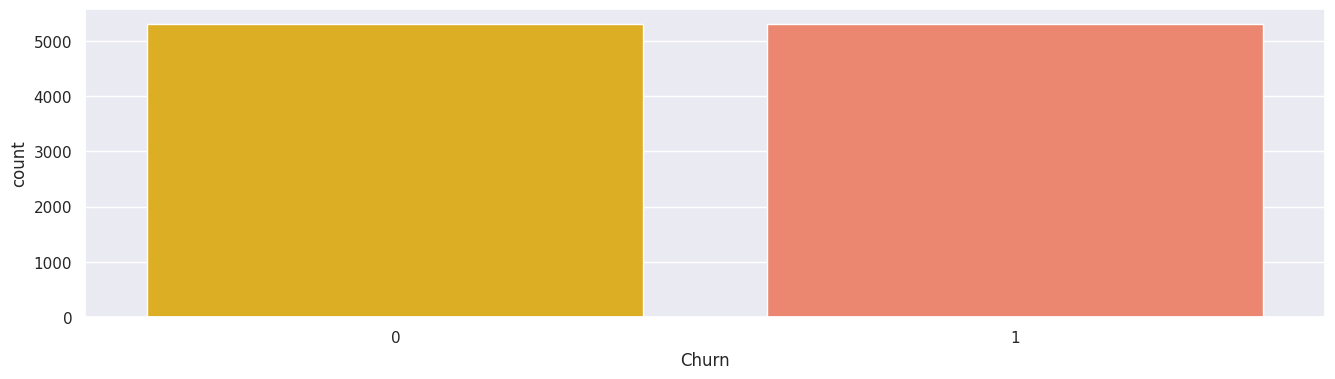

In [130]:
# Visualizando proporção da variável resposta
sns.countplot(x= y_train);

## Note:

Observações:

- Ao escalar os dados usa-se métricas que são definidas por todo o conjunto de dados, então decidi dividir os dados de treino e teste antes de escalar, pois assim, eu teria dois conjuntos de dados, com métricas únicas para cada conjunto, anulando o enviesamento do modelo. 
		Ex.: A normalização MinMaxScaler utiliza o valor mínimo e máximo do conjunto de dados. Se a normalização tivesse sido feita antes da divisão dos dados em conjuntos de treino e teste, a normalização dos dois conjuntos teriam o mesmo padrão escalar, de um único conjunto, pois iriam dividir os elementos mínimos e máximo, logo estaria injetando informações futuras no conjunto de dados de treinamneto, e assim, enviesando o modelo. Com normalização realizada depois da divisão dos dados em treino e teste, os valores mínimo e máximo seriam únicos para cada conjunto, assim, isolando os dados de treino com os dados de teste, evitando o enviesamento do modelo.
        
Próximos Passos:

- Teste estatísticos para validar comportamento das distribuições das variáveis numéricas.

# Feature Selection

In [131]:
df6 = df5.copy()

## Feature Importance

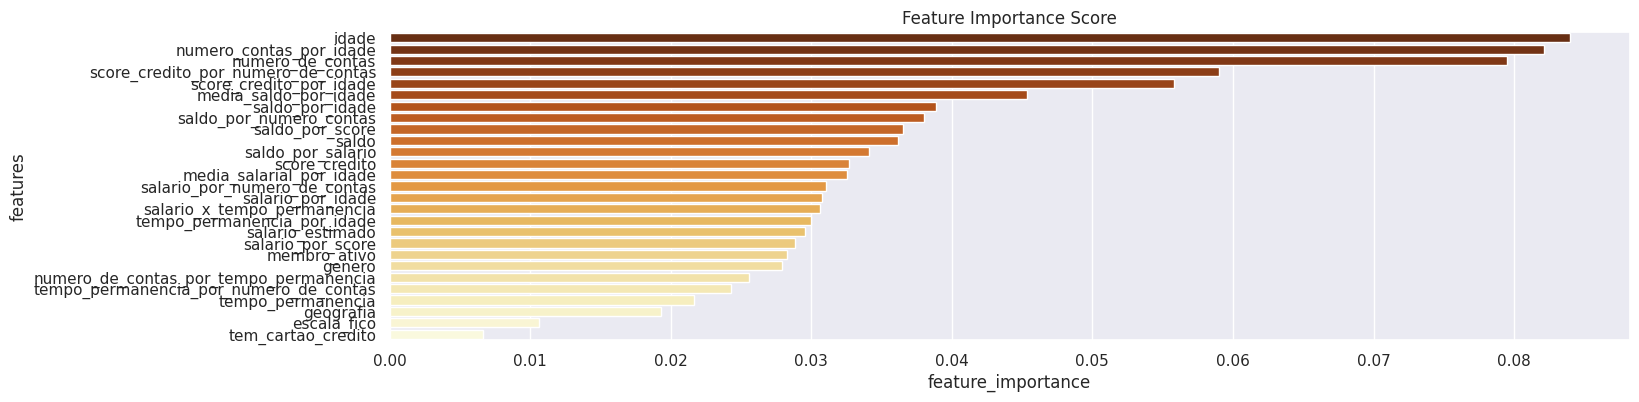

In [132]:
random_forest_importance = RandomForestClassifier(n_estimators= 700, n_jobs= -1, criterion= 'entropy', random_state= 33).fit(X_train, y_train)

feature_selection = pd.DataFrame({'features': X_train.columns,'feature_importance': random_forest_importance.feature_importances_})\
                                .sort_values('feature_importance', ascending = False).reset_index(drop = True)

plot = sns.barplot(x = 'feature_importance', y= 'features', data = feature_selection, palette= "YlOrBr_r")
plot.set_title('Feature Importance Score');

## Boruta Feature Selector

In [133]:
X_train_boruta= X_train.values
y_train_boruta = y_train.values

In [134]:
# Instanciando Boruta e treinando modelo.
random_forest_boruta = RandomForestClassifier(n_estimators= 700, n_jobs= -1, criterion= 'entropy', random_state= 33)

boruta = BorutaPy(random_forest_boruta, verbose= 1, random_state= 33).fit(X_train_boruta, y_train_boruta)

Iteration: 1 / 100
Iteration: 2 / 100
Iteration: 3 / 100
Iteration: 4 / 100
Iteration: 5 / 100
Iteration: 6 / 100
Iteration: 7 / 100
Iteration: 8 / 100


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	24
Tentative: 	0
Rejected: 	3


### Best Features from Boruta 

In [135]:
features_selected = boruta.support_.tolist()

features_selected_boruta = X_train.iloc[:, features_selected].columns.to_list()

features_not_selected_boruta = list(np.setdiff1d(X_train.columns, features_selected_boruta))

In [136]:
features_selected_boruta

['score_credito',
 'genero',
 'idade',
 'tempo_permanencia',
 'saldo',
 'numero_de_contas',
 'membro_ativo',
 'salario_estimado',
 'saldo_por_salario',
 'saldo_por_score',
 'saldo_por_numero_contas',
 'saldo_por_idade',
 'salario_por_numero_de_contas',
 'salario_por_score',
 'salario_x_tempo_permanencia',
 'salario_por_idade',
 'score_credito_por_idade',
 'score_credito_por_numero_de_contas',
 'tempo_permanencia_por_idade',
 'tempo_permanencia_por_numero_de_contas',
 'numero_contas_por_idade',
 'numero_de_contas_por_tempo_permanencia',
 'media_saldo_por_idade',
 'media_salarial_por_idade']

In [137]:
features_not_selected_boruta

['escala_fico', 'geografia', 'tem_cartao_credito']

## Selecting Variables

Minha estratégia para seleção de features:

	- Como a maioria dos modelos usados nesse projeto, são algoritmos baseados em árvore de decisão, vou manter todas as variáveis padrão para que os modelos possam fazer a suas próprias interações entre features;
    - Preferência para análise bivariada e depois para análise multivariada (>= correlação fraca).
    - Como o boruta selecionou todas as variáveis criadas, não considerarei a sua utilidade nesse ciclo.
    - Organização de features através de feature importance (não sei se faz diferença)

In [138]:
best_features = ['idade', 'numero_contas_por_idade', 'numero_de_contas', 'score_credito_por_numero_de_contas', 
                 'score_credito_por_idade', 'saldo_por_numero_contas', 'saldo_por_score',
                 'saldo', 'score_credito', 'genero', 'salario_por_idade', 'tempo_permanencia_por_idade', 
                 'salario_estimado', 'membro_ativo', 'numero_de_contas_por_tempo_permanencia', 'tempo_permanencia',
                 'geografia', 'escala_fico', 'tem_cartao_credito']

# Machine Learning and Model Metrics 

In [139]:
df7 = df6.copy()

## Filtering Data Selecting Best Features to Model

In [140]:
X_train_model = X_train[best_features]
y_train_model = y_train

X_test_model = X_test[best_features]
y_test_model = y_test

In [141]:
X_train_model.sample(5)

idade  numero_contas_por_idade  numero_de_contas  score_credito_por_numero_de_contas  score_credito_por_idade  saldo_por_numero_contas  saldo_por_score     saldo  score_credito  genero  salario_por_idade  tempo_permanencia_por_idade  salario_estimado  membro_ativo  numero_de_contas_por_tempo_permanencia  tempo_permanencia  geografia  escala_fico  tem_cartao_credito
4074  0.333333                -0.432520               0.0                            0.625661                -0.504741                 0.578433         0.536815  0.549591       0.434000       0           0.315862                     0.670536          0.710021            -1                               -0.523810           0.900000          0            0                   1
8670 -1.067063                 0.147632               0.0                            0.793707                 1.641637                 0.474424         0.360503  0.450767       0.688085       0           0.625077                     1.211910          0.829821            -1                               -0.433801           0.709762          1            1                   1
1832  1.166667                 0.074510               1.0                            0.261243                -0.850144                 0.262740         0.474288  0.499279       0.466000       1           0.295175                    -0.077536          0.825453            -1                                0.142857           0.600000          0            1                   1
410  -0.333333                 0.806061               1.0                            0.351852                 0.646017                 0.000000         0.000000  0.000000       0.740000       1           0.389763                    -0.496431          0.705126             1                                2.142857           0.200000          0            2                  -1
8803 -0.201905                 1.751953               2.0                            0.193610                 0.539602                 0.071623         0.149557  0.204155       0.742217       0           0.345107                    -0.413617          0.610620             1                                2.880000           0.250857          1            2                   1

In [142]:
X_test_model.sample(5)

idade  numero_contas_por_idade  numero_de_contas  score_credito_por_numero_de_contas  score_credito_por_idade  saldo_por_numero_contas  saldo_por_score     saldo  score_credito  genero  salario_por_idade  tempo_permanencia_por_idade  salario_estimado  membro_ativo  numero_de_contas_por_tempo_permanencia  tempo_permanencia  geografia  escala_fico  tem_cartao_credito
1622  0.166667                 0.487179               1.0                            0.263889                -0.328717                 0.213626         0.383002  0.405949          0.474       0           0.016476                     0.188301          0.035089            -1                                0.142857                0.6          1            1                   1
1943  0.500000                 0.324031               1.0                            0.287037                -0.413151                 0.000000         0.000000  0.000000          0.544       1           0.213343                     0.424773          0.502941            -1                               -0.107143                0.8          0            1                   1
2994 -0.416667                -0.197917               0.0                            0.653439                 0.150046                 0.457697         0.409596  0.434875          0.476       1           0.014096                    -0.253030          0.024534             1                                0.142857                0.3          2            1                  -1
2673  2.000000                -0.145355               1.0                            0.276455                -1.065771                 0.226870         0.393994  0.431116          0.512       1           0.012785                    -0.339560          0.042791             1                                0.342857                0.5          0            1                  -1
2274  0.000000                -0.342342               0.0                            0.566138                -0.464576                 0.398605         0.401816  0.378730          0.344       0           0.318211                    -0.346067          0.645473             1                                0.142857                0.3          1            0                   1

## Cross Validation (Real Performance)

### Logistic Regression

In [143]:
kfold = KFold(5, shuffle= True, random_state= 33)

logistic_regression_cv = LogisticRegression(random_state= 33)

accuracy_logistic = cross_val_score(logistic_regression_cv, X_train_model, y_train_model, cv= kfold)

print(f'Acurácia (Cross Validation): {round(accuracy_logistic.mean(), 3)} +/-{round(accuracy_logistic.std(), 3)}')

Acurácia (Cross Validation): 0.767 +/-0.005


### Random Forest

In [144]:
kfold = KFold(5, shuffle= True, random_state= 33)

random_forest_cv = RandomForestClassifier(n_jobs= -1, random_state= 33)

accuracy_rf = cross_val_score(random_forest_cv, X_train_model, y_train_model, cv= kfold)

print(f'Acurácia (Cross Validation): {round(accuracy_rf.mean(), 3)} +/-{round(accuracy_rf.std(), 3)}')

Acurácia (Cross Validation): 0.883 +/-0.01


### Gradient Boosting

In [145]:
kfold = KFold(5, shuffle= True, random_state= 33)

gradient_boosting_cv = GradientBoostingClassifier(random_state = 33)

accuracy_gb = cross_val_score(gradient_boosting_cv, X_train_model, y_train_model, cv= kfold)

print(f'Acurácia (Cross Validation): {round(accuracy_gb.mean(), 3)} +/-{round(accuracy_gb.std(), 3)}')

Acurácia (Cross Validation): 0.854 +/-0.008


### XGB

In [146]:
kfold = KFold(5, shuffle= True, random_state= 33)

xg_boost_cv = XGBClassifier(random_state= 33, n_jobs= -1)

accuracy_xgb = cross_val_score(xg_boost_cv, X_train_model, y_train_model, cv= kfold)

print(f'Acurácia (Cross Validation): {round(accuracy_xgb.mean(), 3)} +/-{round(accuracy_xgb.std(), 3)}')

Acurácia (Cross Validation): 0.898 +/-0.01


### CatBoost

In [147]:
kfold = KFold(5, shuffle= True, random_state= 33)

cat_boost_cv = CatBoostClassifier(random_state = 33, allow_writing_files=False)

accuracy_cb = cross_val_score(cat_boost_cv, X_train_model, y_train_model, cv= kfold)

print(f'Acurácia (Cross Validation): {round(accuracy_cb.mean(), 3)} +/-{round(accuracy_cb.std(), 3)}')

Learning rate set to 0.025678
0:	learn: 0.6776829	total: 53.8ms	remaining: 53.7s
1:	learn: 0.6628848	total: 56.6ms	remaining: 28.2s
2:	learn: 0.6481037	total: 63.3ms	remaining: 21s
3:	learn: 0.6359802	total: 66.2ms	remaining: 16.5s
4:	learn: 0.6248701	total: 68.2ms	remaining: 13.6s
5:	learn: 0.6138472	total: 70.4ms	remaining: 11.7s
6:	learn: 0.6037756	total: 72.3ms	remaining: 10.3s
7:	learn: 0.5939283	total: 74.3ms	remaining: 9.21s
8:	learn: 0.5844403	total: 77.2ms	remaining: 8.5s
9:	learn: 0.5760838	total: 79ms	remaining: 7.82s
10:	learn: 0.5695157	total: 80.8ms	remaining: 7.27s
11:	learn: 0.5613099	total: 82.5ms	remaining: 6.79s
12:	learn: 0.5548316	total: 84.1ms	remaining: 6.38s
13:	learn: 0.5470172	total: 85.7ms	remaining: 6.03s
14:	learn: 0.5413467	total: 87.3ms	remaining: 5.73s
15:	learn: 0.5352393	total: 88.9ms	remaining: 5.47s
16:	learn: 0.5284074	total: 90.6ms	remaining: 5.24s
17:	learn: 0.5217858	total: 92.3ms	remaining: 5.03s
18:	learn: 0.5163445	total: 94ms	remaining: 4.85s

242:	learn: 0.3080699	total: 547ms	remaining: 1.7s
243:	learn: 0.3077548	total: 550ms	remaining: 1.71s
244:	learn: 0.3075191	total: 552ms	remaining: 1.7s
245:	learn: 0.3069937	total: 554ms	remaining: 1.7s
246:	learn: 0.3067380	total: 556ms	remaining: 1.7s
247:	learn: 0.3065672	total: 558ms	remaining: 1.69s
248:	learn: 0.3063503	total: 561ms	remaining: 1.69s
249:	learn: 0.3058295	total: 562ms	remaining: 1.69s
250:	learn: 0.3056581	total: 564ms	remaining: 1.68s
251:	learn: 0.3054769	total: 567ms	remaining: 1.68s
252:	learn: 0.3052158	total: 569ms	remaining: 1.68s
253:	learn: 0.3050273	total: 571ms	remaining: 1.68s
254:	learn: 0.3048708	total: 573ms	remaining: 1.67s
255:	learn: 0.3044962	total: 575ms	remaining: 1.67s
256:	learn: 0.3042305	total: 576ms	remaining: 1.67s
257:	learn: 0.3039454	total: 578ms	remaining: 1.66s
258:	learn: 0.3037249	total: 580ms	remaining: 1.66s
259:	learn: 0.3034056	total: 581ms	remaining: 1.65s
260:	learn: 0.3030926	total: 583ms	remaining: 1.65s
261:	learn: 0.30

457:	learn: 0.2460989	total: 946ms	remaining: 1.12s
458:	learn: 0.2458472	total: 948ms	remaining: 1.12s
459:	learn: 0.2456522	total: 950ms	remaining: 1.11s
460:	learn: 0.2454053	total: 952ms	remaining: 1.11s
461:	learn: 0.2451831	total: 954ms	remaining: 1.11s
462:	learn: 0.2449452	total: 956ms	remaining: 1.11s
463:	learn: 0.2447471	total: 959ms	remaining: 1.11s
464:	learn: 0.2441683	total: 961ms	remaining: 1.11s
465:	learn: 0.2439969	total: 964ms	remaining: 1.1s
466:	learn: 0.2439062	total: 966ms	remaining: 1.1s
467:	learn: 0.2436810	total: 969ms	remaining: 1.1s
468:	learn: 0.2435487	total: 971ms	remaining: 1.1s
469:	learn: 0.2433669	total: 973ms	remaining: 1.1s
470:	learn: 0.2431500	total: 975ms	remaining: 1.09s
471:	learn: 0.2428676	total: 977ms	remaining: 1.09s
472:	learn: 0.2426255	total: 979ms	remaining: 1.09s
473:	learn: 0.2424265	total: 981ms	remaining: 1.09s
474:	learn: 0.2422568	total: 982ms	remaining: 1.08s
475:	learn: 0.2418477	total: 984ms	remaining: 1.08s
476:	learn: 0.241

654:	learn: 0.2116052	total: 1.34s	remaining: 707ms
655:	learn: 0.2115099	total: 1.34s	remaining: 705ms
656:	learn: 0.2113896	total: 1.35s	remaining: 703ms
657:	learn: 0.2109618	total: 1.35s	remaining: 701ms
658:	learn: 0.2108031	total: 1.35s	remaining: 699ms
659:	learn: 0.2106710	total: 1.35s	remaining: 697ms
660:	learn: 0.2105478	total: 1.35s	remaining: 695ms
661:	learn: 0.2104036	total: 1.36s	remaining: 693ms
662:	learn: 0.2102914	total: 1.36s	remaining: 691ms
663:	learn: 0.2101565	total: 1.36s	remaining: 689ms
664:	learn: 0.2100220	total: 1.36s	remaining: 687ms
665:	learn: 0.2098784	total: 1.36s	remaining: 685ms
666:	learn: 0.2097905	total: 1.37s	remaining: 682ms
667:	learn: 0.2095979	total: 1.37s	remaining: 680ms
668:	learn: 0.2094531	total: 1.37s	remaining: 678ms
669:	learn: 0.2092881	total: 1.37s	remaining: 676ms
670:	learn: 0.2091688	total: 1.37s	remaining: 674ms
671:	learn: 0.2091105	total: 1.38s	remaining: 671ms
672:	learn: 0.2089422	total: 1.38s	remaining: 669ms
673:	learn: 

865:	learn: 0.1860084	total: 1.74s	remaining: 269ms
866:	learn: 0.1859205	total: 1.74s	remaining: 267ms
867:	learn: 0.1858179	total: 1.74s	remaining: 265ms
868:	learn: 0.1857204	total: 1.74s	remaining: 263ms
869:	learn: 0.1856665	total: 1.75s	remaining: 261ms
870:	learn: 0.1855623	total: 1.75s	remaining: 259ms
871:	learn: 0.1854486	total: 1.75s	remaining: 257ms
872:	learn: 0.1853499	total: 1.75s	remaining: 255ms
873:	learn: 0.1852255	total: 1.75s	remaining: 253ms
874:	learn: 0.1851038	total: 1.76s	remaining: 251ms
875:	learn: 0.1849773	total: 1.76s	remaining: 249ms
876:	learn: 0.1849067	total: 1.76s	remaining: 247ms
877:	learn: 0.1848040	total: 1.76s	remaining: 245ms
878:	learn: 0.1846954	total: 1.76s	remaining: 243ms
879:	learn: 0.1845792	total: 1.77s	remaining: 241ms
880:	learn: 0.1845097	total: 1.77s	remaining: 239ms
881:	learn: 0.1844191	total: 1.77s	remaining: 237ms
882:	learn: 0.1843031	total: 1.77s	remaining: 235ms
883:	learn: 0.1841965	total: 1.77s	remaining: 233ms
884:	learn: 

61:	learn: 0.4220206	total: 119ms	remaining: 1.8s
62:	learn: 0.4206996	total: 121ms	remaining: 1.8s
63:	learn: 0.4194466	total: 123ms	remaining: 1.79s
64:	learn: 0.4184834	total: 125ms	remaining: 1.79s
65:	learn: 0.4170929	total: 126ms	remaining: 1.79s
66:	learn: 0.4158187	total: 128ms	remaining: 1.79s
67:	learn: 0.4144861	total: 130ms	remaining: 1.79s
68:	learn: 0.4130802	total: 132ms	remaining: 1.79s
69:	learn: 0.4122108	total: 134ms	remaining: 1.79s
70:	learn: 0.4106904	total: 136ms	remaining: 1.78s
71:	learn: 0.4091959	total: 138ms	remaining: 1.78s
72:	learn: 0.4082833	total: 140ms	remaining: 1.78s
73:	learn: 0.4076420	total: 142ms	remaining: 1.78s
74:	learn: 0.4069344	total: 144ms	remaining: 1.77s
75:	learn: 0.4063071	total: 146ms	remaining: 1.78s
76:	learn: 0.4055397	total: 148ms	remaining: 1.78s
77:	learn: 0.4043031	total: 150ms	remaining: 1.78s
78:	learn: 0.4035854	total: 152ms	remaining: 1.78s
79:	learn: 0.4012196	total: 154ms	remaining: 1.77s
80:	learn: 0.4004118	total: 156ms

270:	learn: 0.3046886	total: 519ms	remaining: 1.4s
271:	learn: 0.3045017	total: 522ms	remaining: 1.4s
272:	learn: 0.3039087	total: 524ms	remaining: 1.4s
273:	learn: 0.3035556	total: 527ms	remaining: 1.4s
274:	learn: 0.3033600	total: 529ms	remaining: 1.39s
275:	learn: 0.3028030	total: 531ms	remaining: 1.39s
276:	learn: 0.3025579	total: 533ms	remaining: 1.39s
277:	learn: 0.3022397	total: 536ms	remaining: 1.39s
278:	learn: 0.3019947	total: 538ms	remaining: 1.39s
279:	learn: 0.3018165	total: 541ms	remaining: 1.39s
280:	learn: 0.3013117	total: 543ms	remaining: 1.39s
281:	learn: 0.3010073	total: 545ms	remaining: 1.39s
282:	learn: 0.3007061	total: 547ms	remaining: 1.38s
283:	learn: 0.3005661	total: 548ms	remaining: 1.38s
284:	learn: 0.3002694	total: 550ms	remaining: 1.38s
285:	learn: 0.2994797	total: 552ms	remaining: 1.38s
286:	learn: 0.2991188	total: 554ms	remaining: 1.38s
287:	learn: 0.2989424	total: 556ms	remaining: 1.37s
288:	learn: 0.2987598	total: 558ms	remaining: 1.37s
289:	learn: 0.29

481:	learn: 0.2453817	total: 917ms	remaining: 986ms
482:	learn: 0.2450360	total: 919ms	remaining: 984ms
483:	learn: 0.2448778	total: 921ms	remaining: 982ms
484:	learn: 0.2447161	total: 923ms	remaining: 980ms
485:	learn: 0.2441960	total: 925ms	remaining: 978ms
486:	learn: 0.2440461	total: 927ms	remaining: 977ms
487:	learn: 0.2438664	total: 929ms	remaining: 975ms
488:	learn: 0.2436685	total: 931ms	remaining: 973ms
489:	learn: 0.2435388	total: 933ms	remaining: 971ms
490:	learn: 0.2429818	total: 935ms	remaining: 969ms
491:	learn: 0.2428085	total: 938ms	remaining: 969ms
492:	learn: 0.2425795	total: 941ms	remaining: 968ms
493:	learn: 0.2423629	total: 943ms	remaining: 966ms
494:	learn: 0.2422573	total: 945ms	remaining: 964ms
495:	learn: 0.2420302	total: 946ms	remaining: 962ms
496:	learn: 0.2418747	total: 948ms	remaining: 960ms
497:	learn: 0.2417751	total: 950ms	remaining: 958ms
498:	learn: 0.2416010	total: 952ms	remaining: 956ms
499:	learn: 0.2415139	total: 954ms	remaining: 954ms
500:	learn: 

699:	learn: 0.2093510	total: 1.31s	remaining: 564ms
700:	learn: 0.2092145	total: 1.32s	remaining: 562ms
701:	learn: 0.2091145	total: 1.32s	remaining: 560ms
702:	learn: 0.2090219	total: 1.32s	remaining: 558ms
703:	learn: 0.2088422	total: 1.32s	remaining: 557ms
704:	learn: 0.2086855	total: 1.32s	remaining: 555ms
705:	learn: 0.2085646	total: 1.33s	remaining: 553ms
706:	learn: 0.2084273	total: 1.33s	remaining: 551ms
707:	learn: 0.2082332	total: 1.33s	remaining: 549ms
708:	learn: 0.2081747	total: 1.33s	remaining: 548ms
709:	learn: 0.2080399	total: 1.34s	remaining: 546ms
710:	learn: 0.2078912	total: 1.34s	remaining: 544ms
711:	learn: 0.2077987	total: 1.34s	remaining: 542ms
712:	learn: 0.2077176	total: 1.34s	remaining: 540ms
713:	learn: 0.2075961	total: 1.34s	remaining: 538ms
714:	learn: 0.2074509	total: 1.34s	remaining: 536ms
715:	learn: 0.2073128	total: 1.35s	remaining: 535ms
716:	learn: 0.2071844	total: 1.35s	remaining: 533ms
717:	learn: 0.2070367	total: 1.35s	remaining: 531ms
718:	learn: 

917:	learn: 0.1846658	total: 1.71s	remaining: 153ms
918:	learn: 0.1845709	total: 1.72s	remaining: 151ms
919:	learn: 0.1844690	total: 1.72s	remaining: 149ms
920:	learn: 0.1843430	total: 1.72s	remaining: 148ms
921:	learn: 0.1842528	total: 1.72s	remaining: 146ms
922:	learn: 0.1841533	total: 1.72s	remaining: 144ms
923:	learn: 0.1840281	total: 1.73s	remaining: 142ms
924:	learn: 0.1839630	total: 1.73s	remaining: 140ms
925:	learn: 0.1837983	total: 1.73s	remaining: 138ms
926:	learn: 0.1837032	total: 1.73s	remaining: 136ms
927:	learn: 0.1835402	total: 1.74s	remaining: 135ms
928:	learn: 0.1834068	total: 1.74s	remaining: 133ms
929:	learn: 0.1833413	total: 1.74s	remaining: 131ms
930:	learn: 0.1832460	total: 1.74s	remaining: 129ms
931:	learn: 0.1831435	total: 1.74s	remaining: 127ms
932:	learn: 0.1830972	total: 1.74s	remaining: 125ms
933:	learn: 0.1830156	total: 1.75s	remaining: 123ms
934:	learn: 0.1828886	total: 1.75s	remaining: 122ms
935:	learn: 0.1828259	total: 1.75s	remaining: 120ms
936:	learn: 

116:	learn: 0.3666351	total: 225ms	remaining: 1.7s
117:	learn: 0.3661472	total: 227ms	remaining: 1.7s
118:	learn: 0.3655911	total: 229ms	remaining: 1.7s
119:	learn: 0.3653051	total: 231ms	remaining: 1.69s
120:	learn: 0.3642938	total: 233ms	remaining: 1.69s
121:	learn: 0.3637794	total: 235ms	remaining: 1.69s
122:	learn: 0.3632517	total: 237ms	remaining: 1.69s
123:	learn: 0.3628261	total: 239ms	remaining: 1.69s
124:	learn: 0.3618642	total: 241ms	remaining: 1.68s
125:	learn: 0.3613125	total: 243ms	remaining: 1.68s
126:	learn: 0.3609701	total: 244ms	remaining: 1.68s
127:	learn: 0.3606738	total: 247ms	remaining: 1.68s
128:	learn: 0.3602622	total: 249ms	remaining: 1.68s
129:	learn: 0.3595298	total: 251ms	remaining: 1.68s
130:	learn: 0.3591082	total: 252ms	remaining: 1.67s
131:	learn: 0.3584462	total: 254ms	remaining: 1.67s
132:	learn: 0.3572896	total: 256ms	remaining: 1.67s
133:	learn: 0.3568315	total: 258ms	remaining: 1.67s
134:	learn: 0.3563688	total: 259ms	remaining: 1.66s
135:	learn: 0.3

325:	learn: 0.2839107	total: 622ms	remaining: 1.29s
326:	learn: 0.2835323	total: 625ms	remaining: 1.28s
327:	learn: 0.2832805	total: 627ms	remaining: 1.28s
328:	learn: 0.2830509	total: 629ms	remaining: 1.28s
329:	learn: 0.2828525	total: 631ms	remaining: 1.28s
330:	learn: 0.2824309	total: 633ms	remaining: 1.28s
331:	learn: 0.2822919	total: 636ms	remaining: 1.28s
332:	learn: 0.2820768	total: 638ms	remaining: 1.28s
333:	learn: 0.2818825	total: 641ms	remaining: 1.28s
334:	learn: 0.2813214	total: 643ms	remaining: 1.28s
335:	learn: 0.2810558	total: 646ms	remaining: 1.28s
336:	learn: 0.2809278	total: 648ms	remaining: 1.27s
337:	learn: 0.2807201	total: 650ms	remaining: 1.27s
338:	learn: 0.2805302	total: 651ms	remaining: 1.27s
339:	learn: 0.2803265	total: 653ms	remaining: 1.27s
340:	learn: 0.2800620	total: 655ms	remaining: 1.26s
341:	learn: 0.2797221	total: 656ms	remaining: 1.26s
342:	learn: 0.2793653	total: 658ms	remaining: 1.26s
343:	learn: 0.2790982	total: 660ms	remaining: 1.26s
344:	learn: 

535:	learn: 0.2295874	total: 1.02s	remaining: 884ms
536:	learn: 0.2294177	total: 1.02s	remaining: 882ms
537:	learn: 0.2292538	total: 1.02s	remaining: 880ms
538:	learn: 0.2290551	total: 1.03s	remaining: 878ms
539:	learn: 0.2287387	total: 1.03s	remaining: 876ms
540:	learn: 0.2286157	total: 1.03s	remaining: 874ms
541:	learn: 0.2285170	total: 1.03s	remaining: 873ms
542:	learn: 0.2283197	total: 1.04s	remaining: 879ms
543:	learn: 0.2282449	total: 1.05s	remaining: 879ms
544:	learn: 0.2281243	total: 1.06s	remaining: 886ms
545:	learn: 0.2276743	total: 1.06s	remaining: 885ms
546:	learn: 0.2273945	total: 1.07s	remaining: 883ms
547:	learn: 0.2272653	total: 1.07s	remaining: 882ms
548:	learn: 0.2270250	total: 1.07s	remaining: 880ms
549:	learn: 0.2268601	total: 1.07s	remaining: 878ms
550:	learn: 0.2266904	total: 1.08s	remaining: 878ms
551:	learn: 0.2265617	total: 1.08s	remaining: 876ms
552:	learn: 0.2263647	total: 1.08s	remaining: 875ms
553:	learn: 0.2261302	total: 1.08s	remaining: 873ms
554:	learn: 

727:	learn: 0.2019663	total: 1.42s	remaining: 530ms
728:	learn: 0.2018478	total: 1.42s	remaining: 528ms
729:	learn: 0.2017082	total: 1.42s	remaining: 526ms
730:	learn: 0.2015558	total: 1.43s	remaining: 525ms
731:	learn: 0.2014378	total: 1.43s	remaining: 523ms
732:	learn: 0.2011362	total: 1.43s	remaining: 521ms
733:	learn: 0.2010181	total: 1.43s	remaining: 519ms
734:	learn: 0.2009370	total: 1.43s	remaining: 517ms
735:	learn: 0.2008001	total: 1.44s	remaining: 515ms
736:	learn: 0.2006642	total: 1.44s	remaining: 513ms
737:	learn: 0.2005650	total: 1.44s	remaining: 511ms
738:	learn: 0.2004909	total: 1.44s	remaining: 509ms
739:	learn: 0.2004393	total: 1.44s	remaining: 507ms
740:	learn: 0.2003097	total: 1.45s	remaining: 505ms
741:	learn: 0.2002499	total: 1.45s	remaining: 503ms
742:	learn: 0.2001947	total: 1.45s	remaining: 501ms
743:	learn: 0.2001171	total: 1.45s	remaining: 499ms
744:	learn: 0.1999896	total: 1.45s	remaining: 497ms
745:	learn: 0.1999007	total: 1.45s	remaining: 495ms
746:	learn: 

938:	learn: 0.1793893	total: 1.81s	remaining: 118ms
939:	learn: 0.1792996	total: 1.82s	remaining: 116ms
940:	learn: 0.1792397	total: 1.82s	remaining: 114ms
941:	learn: 0.1791029	total: 1.82s	remaining: 112ms
942:	learn: 0.1790494	total: 1.82s	remaining: 110ms
943:	learn: 0.1789566	total: 1.83s	remaining: 108ms
944:	learn: 0.1788917	total: 1.83s	remaining: 106ms
945:	learn: 0.1788130	total: 1.83s	remaining: 105ms
946:	learn: 0.1786796	total: 1.83s	remaining: 103ms
947:	learn: 0.1786041	total: 1.83s	remaining: 101ms
948:	learn: 0.1785464	total: 1.84s	remaining: 98.7ms
949:	learn: 0.1784143	total: 1.84s	remaining: 96.8ms
950:	learn: 0.1783266	total: 1.84s	remaining: 94.8ms
951:	learn: 0.1782393	total: 1.84s	remaining: 92.9ms
952:	learn: 0.1781920	total: 1.84s	remaining: 91ms
953:	learn: 0.1780540	total: 1.85s	remaining: 89ms
954:	learn: 0.1779358	total: 1.85s	remaining: 87.1ms
955:	learn: 0.1778910	total: 1.85s	remaining: 85.1ms
956:	learn: 0.1777233	total: 1.85s	remaining: 83.2ms
957:	le

137:	learn: 0.3593441	total: 268ms	remaining: 1.67s
138:	learn: 0.3587811	total: 270ms	remaining: 1.67s
139:	learn: 0.3578487	total: 272ms	remaining: 1.67s
140:	learn: 0.3575625	total: 274ms	remaining: 1.67s
141:	learn: 0.3562436	total: 277ms	remaining: 1.67s
142:	learn: 0.3558646	total: 278ms	remaining: 1.67s
143:	learn: 0.3556018	total: 281ms	remaining: 1.67s
144:	learn: 0.3551503	total: 283ms	remaining: 1.67s
145:	learn: 0.3547525	total: 285ms	remaining: 1.67s
146:	learn: 0.3545327	total: 287ms	remaining: 1.66s
147:	learn: 0.3539551	total: 289ms	remaining: 1.66s
148:	learn: 0.3532730	total: 291ms	remaining: 1.66s
149:	learn: 0.3530019	total: 293ms	remaining: 1.66s
150:	learn: 0.3520640	total: 295ms	remaining: 1.66s
151:	learn: 0.3514672	total: 296ms	remaining: 1.65s
152:	learn: 0.3511663	total: 298ms	remaining: 1.65s
153:	learn: 0.3508886	total: 300ms	remaining: 1.65s
154:	learn: 0.3502867	total: 302ms	remaining: 1.65s
155:	learn: 0.3493686	total: 305ms	remaining: 1.65s
156:	learn: 

347:	learn: 0.2820207	total: 665ms	remaining: 1.25s
348:	learn: 0.2817337	total: 667ms	remaining: 1.24s
349:	learn: 0.2815894	total: 669ms	remaining: 1.24s
350:	learn: 0.2812669	total: 672ms	remaining: 1.24s
351:	learn: 0.2809765	total: 675ms	remaining: 1.24s
352:	learn: 0.2808124	total: 678ms	remaining: 1.24s
353:	learn: 0.2806519	total: 680ms	remaining: 1.24s
354:	learn: 0.2803337	total: 682ms	remaining: 1.24s
355:	learn: 0.2801769	total: 685ms	remaining: 1.24s
356:	learn: 0.2798083	total: 687ms	remaining: 1.24s
357:	learn: 0.2796152	total: 689ms	remaining: 1.24s
358:	learn: 0.2794113	total: 690ms	remaining: 1.23s
359:	learn: 0.2790712	total: 692ms	remaining: 1.23s
360:	learn: 0.2788478	total: 694ms	remaining: 1.23s
361:	learn: 0.2787094	total: 696ms	remaining: 1.23s
362:	learn: 0.2783650	total: 698ms	remaining: 1.22s
363:	learn: 0.2782511	total: 699ms	remaining: 1.22s
364:	learn: 0.2780032	total: 701ms	remaining: 1.22s
365:	learn: 0.2778526	total: 703ms	remaining: 1.22s
366:	learn: 

561:	learn: 0.2290919	total: 1.06s	remaining: 829ms
562:	learn: 0.2289777	total: 1.07s	remaining: 828ms
563:	learn: 0.2288068	total: 1.07s	remaining: 826ms
564:	learn: 0.2285579	total: 1.07s	remaining: 824ms
565:	learn: 0.2284242	total: 1.07s	remaining: 822ms
566:	learn: 0.2283044	total: 1.07s	remaining: 820ms
567:	learn: 0.2280079	total: 1.08s	remaining: 818ms
568:	learn: 0.2278994	total: 1.08s	remaining: 816ms
569:	learn: 0.2278056	total: 1.08s	remaining: 815ms
570:	learn: 0.2275866	total: 1.08s	remaining: 813ms
571:	learn: 0.2274746	total: 1.08s	remaining: 811ms
572:	learn: 0.2273316	total: 1.08s	remaining: 809ms
573:	learn: 0.2271431	total: 1.09s	remaining: 807ms
574:	learn: 0.2270571	total: 1.09s	remaining: 805ms
575:	learn: 0.2268692	total: 1.09s	remaining: 803ms
576:	learn: 0.2267109	total: 1.09s	remaining: 801ms
577:	learn: 0.2265834	total: 1.09s	remaining: 799ms
578:	learn: 0.2264078	total: 1.1s	remaining: 797ms
579:	learn: 0.2262941	total: 1.1s	remaining: 795ms
580:	learn: 0.

770:	learn: 0.2010233	total: 1.46s	remaining: 435ms
771:	learn: 0.2009497	total: 1.47s	remaining: 433ms
772:	learn: 0.2007926	total: 1.47s	remaining: 431ms
773:	learn: 0.2006991	total: 1.47s	remaining: 429ms
774:	learn: 0.2005997	total: 1.47s	remaining: 428ms
775:	learn: 0.2004994	total: 1.48s	remaining: 426ms
776:	learn: 0.2003444	total: 1.48s	remaining: 424ms
777:	learn: 0.2002473	total: 1.48s	remaining: 422ms
778:	learn: 0.2001507	total: 1.48s	remaining: 420ms
779:	learn: 0.2000291	total: 1.48s	remaining: 418ms
780:	learn: 0.1998985	total: 1.49s	remaining: 417ms
781:	learn: 0.1997334	total: 1.49s	remaining: 415ms
782:	learn: 0.1996013	total: 1.49s	remaining: 413ms
783:	learn: 0.1994352	total: 1.49s	remaining: 411ms
784:	learn: 0.1992628	total: 1.5s	remaining: 410ms
785:	learn: 0.1991515	total: 1.5s	remaining: 408ms
786:	learn: 0.1990891	total: 1.5s	remaining: 406ms
787:	learn: 0.1990044	total: 1.5s	remaining: 404ms
788:	learn: 0.1989364	total: 1.5s	remaining: 402ms
789:	learn: 0.198

975:	learn: 0.1790400	total: 1.86s	remaining: 45.8ms
976:	learn: 0.1789126	total: 1.86s	remaining: 43.9ms
977:	learn: 0.1788492	total: 1.86s	remaining: 42ms
978:	learn: 0.1787617	total: 1.87s	remaining: 40.1ms
979:	learn: 0.1786813	total: 1.87s	remaining: 38.2ms
980:	learn: 0.1786307	total: 1.87s	remaining: 36.3ms
981:	learn: 0.1785696	total: 1.87s	remaining: 34.3ms
982:	learn: 0.1784611	total: 1.88s	remaining: 32.4ms
983:	learn: 0.1782975	total: 1.88s	remaining: 30.5ms
984:	learn: 0.1782382	total: 1.88s	remaining: 28.6ms
985:	learn: 0.1780887	total: 1.88s	remaining: 26.7ms
986:	learn: 0.1780040	total: 1.88s	remaining: 24.8ms
987:	learn: 0.1779238	total: 1.89s	remaining: 22.9ms
988:	learn: 0.1778740	total: 1.89s	remaining: 21ms
989:	learn: 0.1777597	total: 1.89s	remaining: 19.1ms
990:	learn: 0.1776906	total: 1.89s	remaining: 17.2ms
991:	learn: 0.1775838	total: 1.89s	remaining: 15.3ms
992:	learn: 0.1775150	total: 1.89s	remaining: 13.4ms
993:	learn: 0.1774372	total: 1.9s	remaining: 11.4m

172:	learn: 0.3364214	total: 335ms	remaining: 1.6s
173:	learn: 0.3356601	total: 338ms	remaining: 1.6s
174:	learn: 0.3353998	total: 339ms	remaining: 1.6s
175:	learn: 0.3351155	total: 341ms	remaining: 1.6s
176:	learn: 0.3348801	total: 343ms	remaining: 1.59s
177:	learn: 0.3340097	total: 345ms	remaining: 1.59s
178:	learn: 0.3335972	total: 347ms	remaining: 1.59s
179:	learn: 0.3334157	total: 350ms	remaining: 1.59s
180:	learn: 0.3331136	total: 351ms	remaining: 1.59s
181:	learn: 0.3328866	total: 353ms	remaining: 1.59s
182:	learn: 0.3325936	total: 355ms	remaining: 1.58s
183:	learn: 0.3313294	total: 357ms	remaining: 1.58s
184:	learn: 0.3310037	total: 359ms	remaining: 1.58s
185:	learn: 0.3306576	total: 361ms	remaining: 1.58s
186:	learn: 0.3301087	total: 363ms	remaining: 1.58s
187:	learn: 0.3294087	total: 364ms	remaining: 1.57s
188:	learn: 0.3291153	total: 366ms	remaining: 1.57s
189:	learn: 0.3288431	total: 368ms	remaining: 1.57s
190:	learn: 0.3285709	total: 371ms	remaining: 1.57s
191:	learn: 0.32

376:	learn: 0.2727667	total: 732ms	remaining: 1.21s
377:	learn: 0.2720464	total: 735ms	remaining: 1.21s
378:	learn: 0.2719064	total: 737ms	remaining: 1.21s
379:	learn: 0.2716656	total: 739ms	remaining: 1.21s
380:	learn: 0.2714940	total: 740ms	remaining: 1.2s
381:	learn: 0.2714114	total: 742ms	remaining: 1.2s
382:	learn: 0.2711870	total: 745ms	remaining: 1.2s
383:	learn: 0.2710259	total: 747ms	remaining: 1.2s
384:	learn: 0.2707515	total: 749ms	remaining: 1.2s
385:	learn: 0.2705374	total: 751ms	remaining: 1.19s
386:	learn: 0.2702856	total: 753ms	remaining: 1.19s
387:	learn: 0.2699507	total: 755ms	remaining: 1.19s
388:	learn: 0.2693820	total: 757ms	remaining: 1.19s
389:	learn: 0.2692123	total: 759ms	remaining: 1.19s
390:	learn: 0.2685040	total: 761ms	remaining: 1.18s
391:	learn: 0.2682950	total: 762ms	remaining: 1.18s
392:	learn: 0.2679423	total: 764ms	remaining: 1.18s
393:	learn: 0.2674502	total: 767ms	remaining: 1.18s
394:	learn: 0.2672506	total: 768ms	remaining: 1.18s
395:	learn: 0.267

593:	learn: 0.2247257	total: 1.13s	remaining: 772ms
594:	learn: 0.2245715	total: 1.13s	remaining: 771ms
595:	learn: 0.2243789	total: 1.13s	remaining: 769ms
596:	learn: 0.2242335	total: 1.14s	remaining: 768ms
597:	learn: 0.2240936	total: 1.14s	remaining: 766ms
598:	learn: 0.2239521	total: 1.14s	remaining: 765ms
599:	learn: 0.2238624	total: 1.14s	remaining: 763ms
600:	learn: 0.2236663	total: 1.15s	remaining: 761ms
601:	learn: 0.2235840	total: 1.15s	remaining: 759ms
602:	learn: 0.2234502	total: 1.15s	remaining: 758ms
603:	learn: 0.2233594	total: 1.15s	remaining: 756ms
604:	learn: 0.2230414	total: 1.16s	remaining: 754ms
605:	learn: 0.2229172	total: 1.16s	remaining: 752ms
606:	learn: 0.2227402	total: 1.16s	remaining: 750ms
607:	learn: 0.2226422	total: 1.16s	remaining: 748ms
608:	learn: 0.2224907	total: 1.16s	remaining: 746ms
609:	learn: 0.2222147	total: 1.16s	remaining: 744ms
610:	learn: 0.2220599	total: 1.17s	remaining: 743ms
611:	learn: 0.2219792	total: 1.17s	remaining: 741ms
612:	learn: 

805:	learn: 0.1975372	total: 1.53s	remaining: 368ms
806:	learn: 0.1973965	total: 1.53s	remaining: 366ms
807:	learn: 0.1972633	total: 1.53s	remaining: 364ms
808:	learn: 0.1971260	total: 1.53s	remaining: 362ms
809:	learn: 0.1969862	total: 1.54s	remaining: 361ms
810:	learn: 0.1969308	total: 1.54s	remaining: 359ms
811:	learn: 0.1967900	total: 1.54s	remaining: 357ms
812:	learn: 0.1966780	total: 1.54s	remaining: 355ms
813:	learn: 0.1965494	total: 1.54s	remaining: 353ms
814:	learn: 0.1964568	total: 1.55s	remaining: 351ms
815:	learn: 0.1963673	total: 1.55s	remaining: 349ms
816:	learn: 0.1962581	total: 1.55s	remaining: 347ms
817:	learn: 0.1961548	total: 1.55s	remaining: 346ms
818:	learn: 0.1960258	total: 1.55s	remaining: 344ms
819:	learn: 0.1959216	total: 1.56s	remaining: 342ms
820:	learn: 0.1958663	total: 1.56s	remaining: 340ms
821:	learn: 0.1958260	total: 1.56s	remaining: 338ms
822:	learn: 0.1957716	total: 1.56s	remaining: 336ms
823:	learn: 0.1956940	total: 1.56s	remaining: 334ms
824:	learn: 

## Training Model and Testing Model

- Random Forest, XGBoost e o CatBoost, tiveram ótimas performances.
- Nesse ciclo irei trabalhar apenas com XGBoost, pois ele é um modelo robusto, rápido e não dá muita margem para hiperparametrização. A Random Forest e o CatBoost vou trabalhar no próximo cíclo.

### XGB

In [148]:
# Instanciando o Modelo
xg_boost = XGBClassifier(random_state= 33, n_jobs= -1)

# Treinando o modelo
xg_boost.fit(X_train_model, y_train_model)

#Testando o modelo
yhat_xgb = xg_boost.predict(X_test_model)

## Metrics

Como meu principal objetivo é prever os clientes que irão dar churn (1) para tentar criar um plano de ação para evitar a rotatividade desse grupo, a métrica de Recall é a mais importante nesse caso, pois ela tenta responder: de quantos exemplos que foram preditos como positivos, quantos de fato são positivos? 

### Important Metrics

#### XGB

In [149]:
print(classification_report(y_test_model, yhat_xgb))

              precision    recall  f1-score   support

           0       0.90      0.91      0.90      2657
           1       0.61      0.56      0.58       643

    accuracy                           0.84      3300
   macro avg       0.75      0.74      0.74      3300
weighted avg       0.84      0.84      0.84      3300



### Confusion Matrix

#### XGB

In [150]:
matrix_absolute = confusion_matrix(y_test_model, yhat_xgb)
matrix_percentage = confusion_matrix(y_test_model, yhat_xgb, normalize= 'true')

print('- Matriz Absoluta')
print(matrix_absolute)

- Matriz Absoluta
[[2426  231]
 [ 283  360]]


In [151]:
print('- Matriz Percentual')
print(matrix_percentage)

- Matriz Percentual
[[0.91305984 0.08694016]
 [0.44012442 0.55987558]]


In [152]:
true_negative_abs = matrix_absolute[0][0]
false_positive_abs = matrix_absolute[0][1]
false_negative_abs = matrix_absolute[1][0]
true_positive_abs = matrix_absolute[1][1]

print(f'True Negative: {true_negative_abs}')
print(f'False Positive: {false_positive_abs}')
print(f'False Negative: {false_negative_abs}')
print(f'True Positive: {true_positive_abs}')

True Negative: 2426
False Positive: 231
False Negative: 283
True Positive: 360


In [153]:
true_negative_perc = matrix_percentage[0][0]
false_positive_perc = matrix_percentage[0][1]
false_negative_perc = matrix_percentage[1][0]
true_positive_perc = matrix_percentage[1][1]

print(f'True Negative: {true_negative_perc * 100:.2f}%')
print(f'False Positive: {false_positive_perc * 100:.2f}%')
print(f'False Negative: {false_negative_perc * 100:.2f}%')
print(f'True Positive: {true_positive_perc * 100 :.2f}%')

True Negative: 91.31%
False Positive: 8.69%
False Negative: 44.01%
True Positive: 55.99%


### ROC AUC (XGBoost)

In [154]:
roc_auc_score_xgb = roc_auc_score(y_test, yhat_xgb)

pred_prob_xgb = xg_boost.predict_proba(X_test_model)

fpr1, tpr1, thresh1 = roc_curve(y_test, pred_prob_xgb[:, 1], pos_label=1)

random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

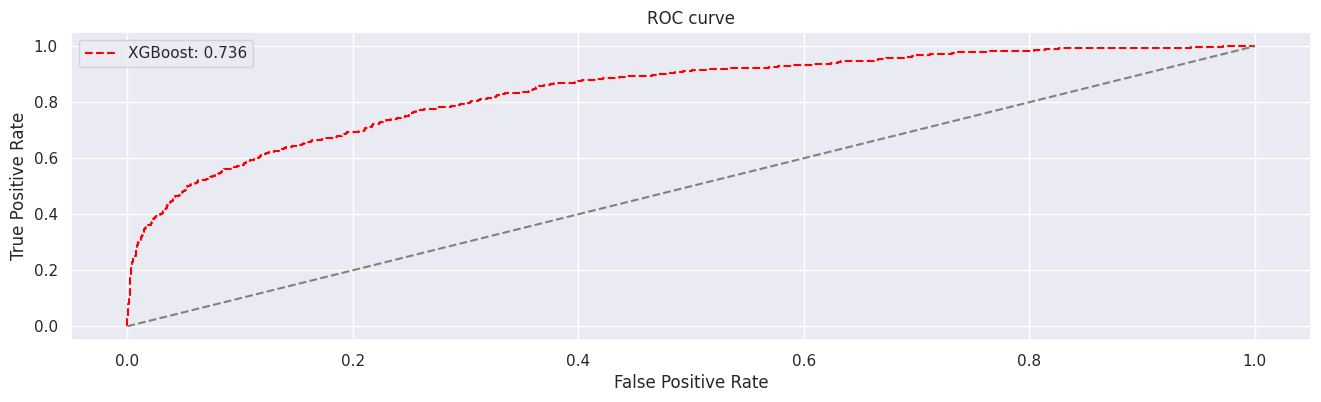

In [155]:
plt.plot(fpr1, tpr1, linestyle='--',color='red', label=f'XGBoost: {roc_auc_score_xgb:.3f}')
plt.plot(p_fpr, p_tpr, linestyle='--', color='gray')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.show();

## Hyperparameter Optimization

### RandomSearch

In [156]:
def xgb_fit(params):
    learning_rate = params[0]
    max_depth = params[1]
    min_child_weight= params[2]
    gamma = params[3]
    subsample = params[4]
    colsample_bytree = params[5]
    reg_alpha = params[6]
    n_estimators = params[7]
    
    print(f"Parameters: {params}")
    
    model = XGBClassifier(learning_rate= learning_rate, max_depth= max_depth, 
                          min_child_weight= min_child_weight,gamma= gamma, 
                          subsample= subsample, colsample_bytree= colsample_bytree, 
                          reg_alpha= reg_alpha, random_state= 0, n_jobs= -1,
                          n_estimators= n_estimators)

    
    model.fit(X_train_model, y_train_model)
    predict = model.predict_proba(X_test_model)[:,1]
    
    return -roc_auc_score(y_test_model, predict)

space = [(0.05, 0.3, 'log-uniform'),
         (3, 10),
         (3, 10),
         (0, 5),
         (0.5, 0.9),
         (0.5, 0.9),
         (0.1, 100),
         (400, 1400)]
    
result_dummy = dummy_minimize(xgb_fit, space, random_state= 33, verbose= 1, n_calls= 30)

Iteration No: 1 started. Evaluating function at random point.
Parameters: [0.17204710274875218, 5, 5, 1, 0.6041198763547599, 0.8481582753387799, 18.585488723474313, 1338]
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 3.3222
Function value obtained: -0.8471
Current minimum: -0.8471
Iteration No: 2 started. Evaluating function at random point.
Parameters: [0.27589527613928644, 4, 8, 4, 0.8860107279463817, 0.6573594956486534, 8.047801371560734, 992]
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 2.2982
Function value obtained: -0.8530
Current minimum: -0.8530
Iteration No: 3 started. Evaluating function at random point.
Parameters: [0.060582899728671424, 9, 3, 4, 0.8522512736860965, 0.6976253872446254, 40.155828187736006, 995]
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 3.9301
Function value obtained: -0.8516
Current minimum: -0.8530
Iteration No: 4 started. Evaluating function at random point.
Parameters: [0.2215558171108

Iteration No: 28 ended. Evaluation done at random point.
Time taken: 1.5970
Function value obtained: -0.8434
Current minimum: -0.8540
Iteration No: 29 started. Evaluating function at random point.
Parameters: [0.10284473211592722, 4, 5, 5, 0.551425483394254, 0.549548706557145, 84.14766571412164, 1090]
Iteration No: 29 ended. Evaluation done at random point.
Time taken: 1.8247
Function value obtained: -0.8413
Current minimum: -0.8540
Iteration No: 30 started. Evaluating function at random point.
Parameters: [0.15987040429313057, 7, 5, 5, 0.796175200979174, 0.5356979353044922, 57.179782105131196, 1145]
Iteration No: 30 ended. Evaluation done at random point.
Time taken: 3.1275
Function value obtained: -0.8500
Current minimum: -0.8540


### Bayesian Optimization

In [157]:
result_gp = gp_minimize(xgb_fit, space, random_state= 33, verbose= 1, n_calls= 50, n_random_starts= 30)

Iteration No: 1 started. Evaluating function at random point.
Parameters: [0.17204710274875218, 8, 9, 1, 0.80036945696187, 0.7451825500120564, 85.06114826448172, 1280]
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 1.6673
Function value obtained: -0.8456
Current minimum: -0.8456
Iteration No: 2 started. Evaluating function at random point.
Parameters: [0.05245688158546086, 9, 5, 5, 0.6853299926263315, 0.5428605889190291, 74.60206943093513, 1364]
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 3.7452
Function value obtained: -0.8456
Current minimum: -0.8456
Iteration No: 3 started. Evaluating function at random point.
Parameters: [0.05961204343626095, 4, 6, 4, 0.8095972604983102, 0.5830209929429888, 25.63776549049197, 822]
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 1.8062
Function value obtained: -0.8530
Current minimum: -0.8530
Iteration No: 4 started. Evaluating function at random point.
Parameters: [0.13658690671312165

Iteration No: 28 ended. Evaluation done at random point.
Time taken: 0.8548
Function value obtained: -0.8393
Current minimum: -0.8530
Iteration No: 29 started. Evaluating function at random point.
Parameters: [0.14568434890262874, 5, 10, 3, 0.552777082920787, 0.8715345004585491, 91.901452790907, 1050]
Iteration No: 29 ended. Evaluation done at random point.
Time taken: 1.1642
Function value obtained: -0.8391
Current minimum: -0.8530
Iteration No: 30 started. Evaluating function at random point.
Parameters: [0.05609845144737929, 6, 6, 2, 0.6413226594016204, 0.7152710869027069, 15.522959557644727, 1305]
Iteration No: 30 ended. Evaluation done at random point.
Time taken: 4.5103
Function value obtained: -0.8516
Current minimum: -0.8530
Iteration No: 31 started. Searching for the next optimal point.
Parameters: [0.05, 6, 5, 5, 0.9, 0.5474387516306021, 0.1, 887]
Iteration No: 31 ended. Search finished for the next optimal point.
Time taken: 3.2095
Function value obtained: -0.8575
Current mi

### Plot Convergence

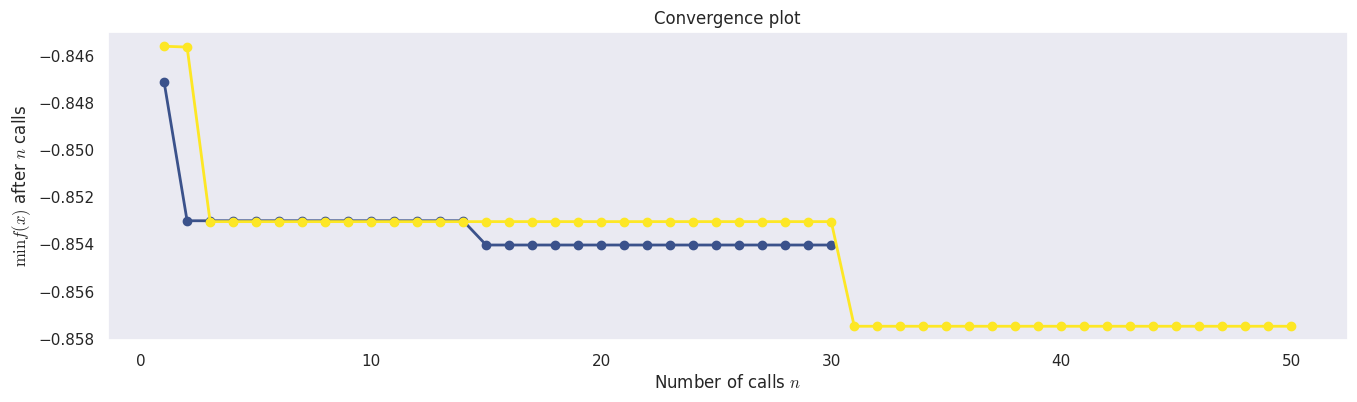

In [158]:
plot_convergence(result_dummy, result_gp);

In [159]:
#Amarelo - Otimização Baysiana
#Azul - Otimização Randômica

## Final Model

In [161]:
# Instanciando o Modelo
parameters = [0.05, 3, 3, 5, 0.9, 0.6790341117122642, 0.1, 1400]
xg_boost_final = XGBClassifier(learning_rate= parameters[0], max_depth= parameters[1], 
                          min_child_weight= parameters[2], gamma= parameters[3], 
                          subsample= parameters[4], colsample_bytree= parameters[5], 
                          reg_alpha= parameters[6], random_state= 33, n_jobs= -1,
                          n_estimators= parameters[7])

# Treinando o modelo
xg_boost_final.fit(X_train_model, y_train_model)

#Testando o modelo
yhat_xgb_final = xg_boost_final.predict(X_test_model)

# Metrics
print(classification_report(y_test_model, yhat_xgb_final))

              precision    recall  f1-score   support

           0       0.90      0.92      0.91      2657
           1       0.64      0.58      0.61       643

    accuracy                           0.85      3300
   macro avg       0.77      0.75      0.76      3300
weighted avg       0.85      0.85      0.85      3300



### Confusion Matrix

In [162]:
matrix_absolute = confusion_matrix(y_test_model, yhat_xgb_final)
matrix_percentage = confusion_matrix(y_test_model, yhat_xgb_final, normalize= 'true')

print('- Matriz Absoluta')
print(matrix_absolute)

- Matriz Absoluta
[[2444  213]
 [ 271  372]]


In [163]:
print('- Matriz Percentual')
print(matrix_percentage)

- Matriz Percentual
[[0.9198344 0.0801656]
 [0.4214619 0.5785381]]


In [164]:
true_negative_abs = matrix_absolute[0][0]
false_positive_abs = matrix_absolute[0][1]
false_negative_abs = matrix_absolute[1][0]
true_positive_abs = matrix_absolute[1][1]

print(f'True Negative: {true_negative_abs}')
print(f'False Positive: {false_positive_abs}')
print(f'False Negative: {false_negative_abs}')
print(f'True Positive: {true_positive_abs}')

True Negative: 2444
False Positive: 213
False Negative: 271
True Positive: 372


In [165]:
true_negative_perc = matrix_percentage[0][0]
false_positive_perc = matrix_percentage[0][1]
false_negative_perc = matrix_percentage[1][0]
true_positive_perc = matrix_percentage[1][1]

print(f'True Negative: {true_negative_perc * 100:.2f}%')
print(f'False Positive: {false_positive_perc * 100:.2f}%')
print(f'False Negative: {false_negative_perc * 100:.2f}%')
print(f'True Positive: {true_positive_perc * 100 :.2f}%')

True Negative: 91.98%
False Positive: 8.02%
False Negative: 42.15%
True Positive: 57.85%


### ROC Curve

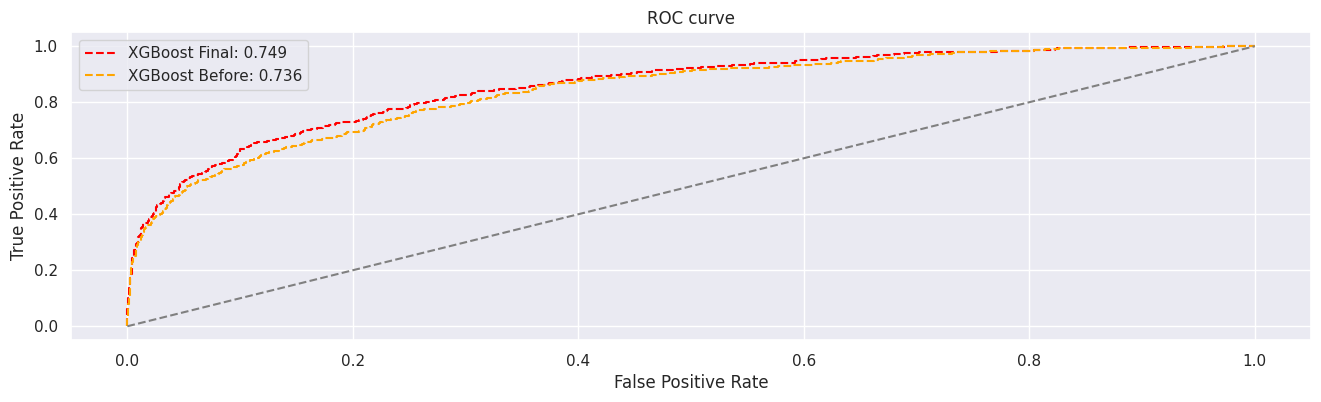

In [166]:
roc_auc_score_xgb_final = roc_auc_score(y_test, yhat_xgb_final)

pred_prob_xgb_final = xg_boost_final.predict_proba(X_test_model)

fpr1, tpr1, thresh1 = roc_curve(y_test, pred_prob_xgb_final[:,1], pos_label=1)
fpr2, tpr2, thresh2 = roc_curve(y_test, pred_prob_xgb[:,1], pos_label=1)

random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

plt.plot(fpr1, tpr1, linestyle='--',color='red', label=f'XGBoost Final: {roc_auc_score_xgb_final:.3f}' )
plt.plot(fpr2, tpr2, linestyle='--',color='orange', label=f'XGBoost Before: {roc_auc_score_xgb:.3f}')
plt.plot(p_fpr, p_tpr, linestyle='--', color='gray')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.show();

## Note:

Observações importantes:
- Em relação ao último ciclo, a performance real do modelo final aumentou 4% > (86% - 90,0%) de Acurácia;
- Com a adição de novas features, conseguimos melhorar a performance real do modelo Random Forest em 2.2% (86% - 88%).
- Com a adição de novas features e com a mudança de modelo para o XGBoost, conseguimos aumentar a acurácia do modelo final em 2% (82% - 84%), para dados de teste, mantendo o mesmo valor da métrica Recall do primeiro ciclo, e aumentando a precisão (Precision) para clientes positivos para churn em 8% (53% para 61%).
- Após a hiperparametrização, o modelo aumentou a performance em 1% (84% - 85%), porém aumentou ainda mais o valor da métrica central para esse problema (Recall) em 1.85% (56 - 57,85%).


Para a próxima versão:
1. Melhorar a visualização das métricas;
2. Estudar sobre parametrização da Random Forest e aplicar hiperparametrização para Feature Importance, Boruta e Machine Learning;
3. Estudar sobre parametrização do CatBoost e aplicar hiperparametrização.

# Business Translation

In [ ]:
df8 = df7.copy()

## Qual é a atual taxa de rotatividade (churn) do Top Bank?

- Foi respondida na análise univariada da variável resposta. 20.37% de Churn Rate.

In [ ]:
sns.countplot(x=df3['Churn']);

In [ ]:
percentage_no_churn = df8[['id_cliente', 'Churn']].loc[df8['Churn'] == 0].shape[0] / df8.shape[0] * 100
percentage_yes_churn = df8[['id_cliente', 'Churn']].loc[df8['Churn'] == 1].shape[0] / df8.shape[0] * 100
print(f'R: Clientes que irão dar Churn correspondem a {percentage_yes_churn:.2f}% da base de dados e clientes que não irão dar Churn correspondem a {percentage_no_churn:.2f}% da base de dados.')

## Qual é o desempenho do modelo na classificação de clientes como churns?

    R: O modelo escolhido (XGBoost) possui uma precisão real de 90% nesse segundo ciclo.

## Qual é o retorno esperado, em termos de receita, se a empresa utilizar seu modelo para evitar o churn de clientes?

Condiderando a base de dados atual, que temos 20,37% dos clientes como positivos para rotatividade e 79,63% negativos para rotatividade, e considerando o modelo XGBoost que acerta aproximadamente 58% dos clientes que são positivos para rotatividade, temos que:

In [167]:
receita_não_churn = df3.loc[df3['Churn'] == 'no']['salario_estimado'].sum()
recall = 0.5785
receita_sim_churn = df3.loc[df3['Churn'] == 'yes']['salario_estimado'].sum() * recall
print(f'Se a empresa usar o modelo desenvolvido com um recall de {(recall * 100):.2f}% para clientes com rotatividade positiva, a receita média anual será de US${(receita_não_churn + receita_sim_churn):.2f}')

Se a empresa usar o modelo desenvolvido com um recall de 57.85% para clientes com rotatividade positiva, a receita média anual será de US$913784424.68


# Deploy

## Note:
Próxima versão: criação da classe para deploy.

# Referências

- **Alura - Lidando com desbalanceamento de dados** (https://www.alura.com.br/artigos/lidando-com-desbalanceamento-dados#:~:text=%C3%89%20uma%20t%C3%A9cnica%20que%20consiste%20em%20aumentar%20a%20quantidade%20de,da%20classe%20com%20menor%20frequ%C3%AAncia)
- **Imbalanced Learn - Over-sampling** (https://imbalanced-learn.org/stable/over_sampling.html#from-random-over-sampling-to-smote-and-adasyn)
- **Mastering XGBoost Parameter Tuning** (https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/?utm_source=reading_list&utm_medium=https://wwUnderstandw.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/#)
- **Understand Random Forest Algorithms With Examples (Updated 2023)** (https://www.analyticsvidhya.com/blog/2021/06/understanding-random-forest/?utm_source=reading_list&utm_medium=https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/)
- **Feature Engineering for Machine Learning** - Alice Zheng, Amanda Casari

In [ ]:
#def xgb_fit(params):
#    learning_rate = params[0]
#    max_depth = params[1]
#    min_child_weight= params[2]
#    gamma = params[3]
#    subsample = params[4]
#    colsample_bytree = params[5]
#    reg_alpha = params[6]
#    
#    print(f"Parameters: {params}")
#    
#    model = XGBClassifier(learning_rate= learning_rate, max_depth= max_depth, 
#                          min_child_weight= min_child_weight,gamma= gamma, 
#                          subsample= subsample, colsample_bytree= colsample_bytree, 
#                          reg_alpha= reg_alpha, random_state= 0, n_jobs= -1,
#                          n_estimators= 700)
#    
#    xgb_params = model.get_xgb_params()
#    xgtrain = xgb.DMatrix(X_train_model.values, label= y_train.values)
#    cvresult = xgb.cv(params= xgb_params, dtrain= xgtrain, num_boost_round= model.get_params()['n_estimators'], 
#                      nfold= 5, metrics='auc', early_stopping_rounds= 50)
#    
#    model.set_params(n_estimators= cvresult.shape[0])
#    
#    print(f"n_estimators: {cvresult.shape[0]} => for learning_rate: {learning_rate}")
#    
#    model.fit(X_train_model, y_train_model)
#    predict = model.predict_proba(X_test_model)[:,1]
#    
#    return -roc_auc_score(y_test_model, predict)
#
#
## Acredito que essa função possa ter erro de sincronicidade ao executar dentro da gp_minimize e dummy_minimize